# HomeWork №1. Bulk-RNA_seq_Differential_Expression
                              
>* Имя файла: ``HW1_Imanalieva_Aminat_Bulk-RNA_seq_DE.ipynb``
>* Автор и учебная группа: ``Иманалиева Аминат,  БКМБ-211``
>* Дата создания: ``10.10.2024``
>* Дата последней модификации:  ``13.10.2024``
>* Связанные файлы: ``'TCGA-THYM.htseq_counts.tsv.gz', 'gencode.v22.annotation.gene.probeMap', 'gencode.v29.annotation.gtf', 'TCGA-THYM.htseq_fpkm.tsv.gz',  'THYM-ann-shorts.tsv'``
>* Версия Python: ``3.6``

# Установка пакетов и импорт данных

## Python пакеты

In [337]:
#для анализа датасета и статистики
import pandas as pd
import numpy as np
import scipy

#создание итераторов, работы с регуляторками, для работы с операционной системой, 
#поверхностное и глубокое копирование объектов, интерпретатор

import itertools
import re
import os
from glob import glob
import copy
import sys


#визуализация 
import seaborn as sns
import matplotlib.pyplot as plt

In [287]:
#синхронизовала R с питоном 
os.environ['R_HOME'] = r'C:\Users\Admin\anaconda3\envs\jupyter\lib\R'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import rpy2.robjects as robjects
# Проверка версии R
print(robjects.r('R.version.string'))
# Пример выполнения R кода из Python
robjects.r('x <- rnorm(100)')
robjects.r('summary(x)')

[1] "R version 4.1.3 (2022-03-10)"



<rpy2.robjects.vectors.FloatVector object at 0x000002326FF13F00> [RTYPES.REALSXP]
R classes: ('summaryDefault', 'table')
[-2.360172, -0.469285, 0.038807, 0.112497, 0.654777, 2.894138]

# Для работы c R

In [5]:
import rpy2
%load_ext rpy2.ipython
print(rpy2.__version__)

3.5.11


In [6]:
%load_ext autoreload
%load_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 150)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
  %reload_ext rpy2.ipython

## R пакеты

In [318]:
''''%%R

(!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install("edgeR")
BiocManager::install("DESeq2")
BiocManager::install("biomaRt")
BiocManager::install("fgsea")
BiocManager::install("ComplexHeatmap") # для всех пакетов из bioconductor

install.packages("ggrepel")
install.packages("circlize")
# для отсальных пакетов (не из Bioconductor)'''

'\'%%R\n\n(!requireNamespace("BiocManager", quietly = TRUE))\n  install.packages("BiocManager")\n\nBiocManager::install("edgeR")\nBiocManager::install("DESeq2")\nBiocManager::install("biomaRt")\nBiocManager::install("fgsea")\nBiocManager::install("ComplexHeatmap") # для всех пакетов из bioconductor\n\ninstall.packages("ggrepel")\ninstall.packages("circlize")\n# для отсальных пакетов (не из Bioconductor)'

In [319]:
'''%%R
BiocManager::install("ComplexHeatmap")
suppressMessages(library(edgeR)) #bioconductor package
suppressMessages(library(ggplot2))
suppressMessages(library(DESeq2)) #bioconductor package
suppressMessages(library(biomaRt)) #bioconductor package
suppressMessages(library(ggrepel))
suppressMessages(library(fgsea))
suppressMessages(library(limma))
suppressMessages(library(matrixStats))
suppressMessages(library(circlize))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(data.table))'''

'%%R\nBiocManager::install("ComplexHeatmap")\nsuppressMessages(library(edgeR)) #bioconductor package\nsuppressMessages(library(ggplot2))\nsuppressMessages(library(DESeq2)) #bioconductor package\nsuppressMessages(library(biomaRt)) #bioconductor package\nsuppressMessages(library(ggrepel))\nsuppressMessages(library(fgsea))\nsuppressMessages(library(limma))\nsuppressMessages(library(matrixStats))\nsuppressMessages(library(circlize))\nsuppressMessages(library(ComplexHeatmap))\nsuppressMessages(library(data.table))'

# Obtaining gene counts

- **Каунты** - это количество ридов, которые откартировались на определенный ген или причислены к одному транскрипту.
- Каунты представлены логарифмическим преобразованием **`log_2(count+1)`**
- **Каунты для TCGA когорты с образцами тимомы** были взяты из сайта, приведенного по ссылке: <html>
 <head></head>
 <body>
     <a href="https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Thymoma%20(THYM)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443">TCGAcogorts</a>
 </body>
</html>

Например, **TCGA-XU-A92T-01A** - уникальный идентификатор образца, связанный с проектом **`The Cancer Genome Atlas (TCGA)`**
- **TCGA:** название проекта
- **XU:** тип рака или группа образцов
- **A92Т:** уникальный номер образца
- **01A:** тип образца

**ENS — это Ensembl ID.**
- *G* — объект типа "ген"
- *00000139618* — уникальный номер гена
- *".12"* — версия аннотации гена

In [486]:
expr_counts = pd.read_csv('TCGA-THYM.htseq_counts.tsv.gz', sep = '\t', index_col=0)
expr_counts.head(4)

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  \
Ensembl_ID                                                                 
ENSG00000000003.13         12.529919         10.977995         11.023061   
ENSG00000000005.5           3.169925          4.584963          2.000000   
ENSG00000000419.11         11.310613         10.790348         11.384784   
ENSG00000000457.12         10.619303          9.603626         10.894060   

                    TCGA-XM-A8RH-01A  TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  \
Ensembl_ID                                                                 
ENSG00000000003.13         10.507795         10.450180         11.343741   
ENSG00000000005.5           5.700440          2.584963          6.714246   
ENSG00000000419.11         11.228217         11.429407         10.924813   
ENSG00000000457.12         10.317413         10.740624          9.548822   

                    TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  TCGA-X7-A8M1-01A  \
Ensembl_ID                                                                 
ENSG00000000003.13          9.758223         10.393390         11.418907   
ENSG00000000005.5           2.000000          4.643856          5.426265   
ENSG00000000419.11         10.658211         10.686501         11.002815   
ENSG00000000457.12          9.049849          9.082149         10.299208   

                    TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  TCGA-3G-AB0T-01A  \
Ensembl_ID                            ...                                       
ENSG00000000003.13         10.018200  ...         11.879966         10.131857   
ENSG00000000005.5           1.000000  ...          6.149747          2.000000   
ENSG00000000419.11         10.099348  ...         10.986553          9.703904   
ENSG00000000457.12          8.954196  ...          9.837628          8.794416   

                    TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  TCGA-YT-A95E-01A  \
Ensembl_ID                                                                 
ENSG00000000003.13         10.023754          8.625709         10.461479   
ENSG00000000005.5           3.459432          4.169925          4.169925   
ENSG00000000419.11          9.896332         11.152919         10.597121   
ENSG00000000457.12          8.820179         10.215533          9.611025   

                    TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  TCGA-X7-A8D6-11A  \
Ensembl_ID                                                                 
ENSG00000000003.13          9.169925          8.903882         11.163021   
ENSG00000000005.5           1.000000          5.000000         11.624795   
ENSG00000000419.11          8.353147          9.667112         10.818582   
ENSG00000000457.12          7.339850          8.247928         10.323055   

                    TCGA-ZB-A96R-01A  TCGA-ZB-A96H-01A  
Ensembl_ID                                              
ENSG00000000003.13          9.036174         12.590821  
ENSG00000000005.5           2.584963          5.357552  
ENSG00000000419.11         10.852530         10.787903  
ENSG00000000457.12          9.620220         10.669771  

[4 rows x 121 columns]

In [417]:
expr_counts.isna().sum()

TCGA-XU-A92T-01A    0
TCGA-ZB-A96A-01A    0
TCGA-X7-A8M3-01A    0
TCGA-XM-A8RH-01A    0
TCGA-4X-A9FB-01A    0
                   ..
TCGA-5U-AB0F-01A    0
TCGA-X7-A8DD-01A    0
TCGA-X7-A8D6-11A    0
TCGA-ZB-A96R-01A    0
TCGA-ZB-A96H-01A    0
Length: 121, dtype: int64

In [418]:
expr_counts.shape

(60488, 121)

In [419]:
expr_counts.describe()

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  TCGA-XM-A8RH-01A  \
count      60488.000000      60488.000000      60488.000000      60488.000000   
mean           3.574197          3.185069          3.211472          3.340637   
std            4.397073          4.298222          4.226987          4.357899   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            1.584963          0.000000          1.000000          1.000000   
75%            6.700440          6.108524          5.977280          6.228819   
max           23.966406         24.097984         23.634661         24.143488   

       TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  \
count      60488.000000      60488.000000      60488.000000      60488.000000   
mean           3.529844          3.171392          3.120741          3.095223   
std            4.427269          4.247246          4.245654          4.212532   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            1.000000          1.000000          0.000000          0.000000   
75%            6.643856          6.022368          5.930737          5.906891   
max           24.099808         23.798159         24.267580         23.903300   

       TCGA-X7-A8M1-01A  TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  \
count      60488.000000      60488.000000  ...      60488.000000   
mean           3.468955          3.137071  ...          3.205476   
std            4.393393          4.007092  ...          4.285885   
min            0.000000          0.000000  ...          0.000000   
25%            0.000000          0.000000  ...          0.000000   
50%            1.000000          1.000000  ...          1.000000   
75%            6.603612          5.882643  ...          6.022368   
max           24.070440         23.435446  ...         23.480599   

       TCGA-3G-AB0T-01A  TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  TCGA-YT-A95E-01A  \
count      60488.000000      60488.000000      60488.000000      60488.000000   
mean           3.142679          3.057477          3.228038          3.195749   
std            4.177292          4.121447          4.297916          4.227728   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            1.000000          1.000000          1.000000          1.000000   
75%            5.906891          5.754888          5.857981          6.044394   
max           24.388083         23.762983         23.934516         24.150428   

       TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  TCGA-X7-A8D6-11A  TCGA-ZB-A96R-01A  \
count      60488.000000      60488.000000      60488.000000      60488.000000   
mean           2.646474          2.879784          3.764872          3.092220   
std            3.901254          4.027235          4.471758          4.189722   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          1.584963          1.000000   
75%            4.954196          5.459432          7.139551          5.727920   
max           23.790472         23.877756         24.202554         23.725190   

       TCGA-ZB-A96H-01A  
count      60488.000000  
mean           3.611175  
std            4.446038  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            6.857981  
max           24.217650  

[8 rows x 121 columns]

In [420]:
expr_counts.columns #образцы, их вышло 121

Index(['TCGA-XU-A92T-01A', 'TCGA-ZB-A96A-01A', 'TCGA-X7-A8M3-01A',
       'TCGA-XM-A8RH-01A', 'TCGA-4X-A9FB-01A', 'TCGA-XU-A92O-01A',
       'TCGA-XU-AAY1-01A', 'TCGA-X7-A8DF-01A', 'TCGA-X7-A8M1-01A',
       'TCGA-XM-A8R9-01A',
       ...
       'TCGA-XM-AAZ3-01A', 'TCGA-3G-AB0T-01A', 'TCGA-4V-A9QU-01A',
       'TCGA-XM-A8RL-01A', 'TCGA-YT-A95E-01A', 'TCGA-5U-AB0F-01A',
       'TCGA-X7-A8DD-01A', 'TCGA-X7-A8D6-11A', 'TCGA-ZB-A96R-01A',
       'TCGA-ZB-A96H-01A'],
      dtype='object', length=121)

In [487]:
expr_counts.tail()

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  \
Ensembl_ID                                                                     
__no_feature                   22.356250         21.154605         21.480446   
__ambiguous                    21.270984         21.496767         20.968419   
__too_low_aQual                 0.000000          0.000000          0.000000   
__not_aligned                   0.000000          0.000000          0.000000   
__alignment_not_unique         23.966406         24.097984         23.634661   

                        TCGA-XM-A8RH-01A  TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  \
Ensembl_ID                                                                     
__no_feature                   21.488714         21.820019         21.069003   
__ambiguous                    21.342217         21.486819         21.208164   
__too_low_aQual                 0.000000          0.000000          0.000000   
__not_aligned                   0.000000          0.000000          0.000000   
__alignment_not_unique         24.143488         24.099808         23.798159   

                        TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  TCGA-X7-A8M1-01A  \
Ensembl_ID                                                                     
__no_feature                   20.960065         20.838113         21.742808   
__ambiguous                    21.461097         21.163693         21.142915   
__too_low_aQual                 0.000000          0.000000          0.000000   
__not_aligned                   0.000000          0.000000          0.000000   
__alignment_not_unique         24.267580         23.903300         24.070440   

                        TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  \
Ensembl_ID                                ...                     
__no_feature                   21.321538  ...         21.267560   
__ambiguous                    20.502144  ...         20.969101   
__too_low_aQual                 0.000000  ...          0.000000   
__not_aligned                   0.000000  ...          0.000000   
__alignment_not_unique         23.435446  ...         23.480599   

                        TCGA-3G-AB0T-01A  TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  \
Ensembl_ID                                                                     
__no_feature                   21.244364         21.045086         21.623345   
__ambiguous                    21.412866         20.864741         21.255389   
__too_low_aQual                 0.000000          0.000000          0.000000   
__not_aligned                   0.000000          0.000000          0.000000   
__alignment_not_unique         24.388083         23.762983         23.934516   

                        TCGA-YT-A95E-01A  TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  \
Ensembl_ID                                                                     
__no_feature                   21.239743         20.155272         20.627886   
__ambiguous                    21.196978         21.148196         21.150922   
__too_low_aQual                 0.000000          0.000000          0.000000   
__not_aligned                   0.000000          0.000000          0.000000   
__alignment_not_unique         24.150428         23.790472         23.877756   

                        TCGA-X7-A8D6-11A  TCGA-ZB-A96R-01A  TCGA-ZB-A96H-01A  
Ensembl_ID                                                                    
__no_feature                   22.565387         20.887200         22.102766  
__ambiguous                    21.493023         21.127862         21.414624  
__too_low_aQual                 0.000000          0.000000          0.000000  
__not_aligned                   0.000000          0.000000          0.000000  
__alignment_not_unique         24.202554         23.725190         24.217650  

[5 rows x 121 columns]

In [422]:
print([i for i in expr_counts.index if not i.startswith('ENS')])

['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']


Видим **техническую информацию** о `log2(числе ридов + 1)`, которые:
- `__no_feature` - замапились не всей длиной рида
- `__ambiguous` - замапились больше чем на один ген
- `__too_low_aQual` - качество выравнивания ниже порога.

Отфильтруем табличку так, чтобы убрать всю техническую информацию

In [488]:
expr_counts = expr_counts.loc[[ind for ind in expr_counts.index if ind.startswith('ENS')]]
display(expr_counts.shape)

(60483, 121)

Как было сказано ранее, каунты считаются в ``log2(X + 1)``, как я понимаю, потому что:
1. логарифмическое преобразование может помочь, например, уменьшить влияние *высоких значений (выбросов)* на анализ данных
2. позволяет *уменьшить асимметрию* распределения и сделать его более нормальным
3. логарифмическое преобразование делает эти сравнения *более линейными*, чтобы сравнивать после уровень экспрессии в образцах
4. каждое изменение уровня экспрессии *можно интерпретировать как изменение в два раза* (увеличение или снижение экспрессии в два раза)
5. добавление +1 потому что log(0) не определен

Нам нужно построить обратное преобразование для интерпретации результатов

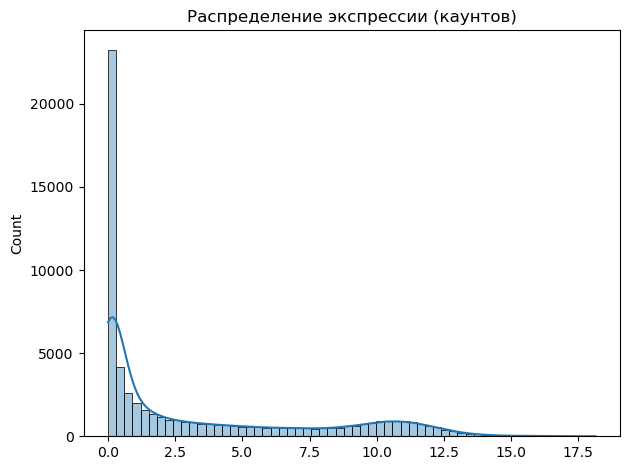

In [424]:
sns.histplot(expr_counts.T.mean(), kde = True, alpha = 0.4).set_title('Распределение экспрессии (каунтов)')
plt.tight_layout()
plt.style.use('default')
plt.show()

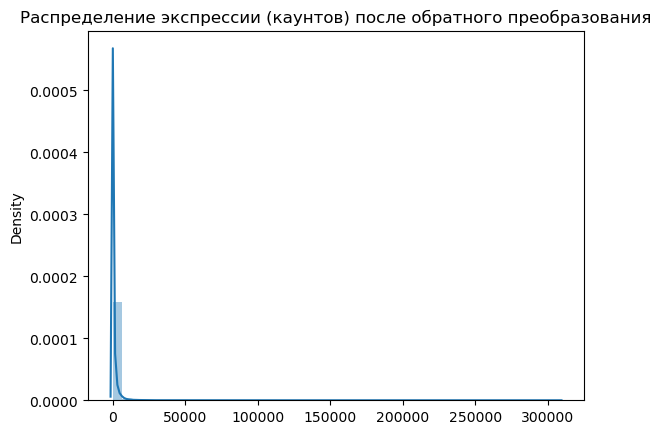

In [425]:
expr_counts = pow(2,expr_counts) - 1 #избавляюсь от логарифма путем возведения 2 в степень
sns.distplot(expr_counts.T.mean()).set_title('Распределение экспрессии (каунтов) после обратного преобразования')
plt.show()

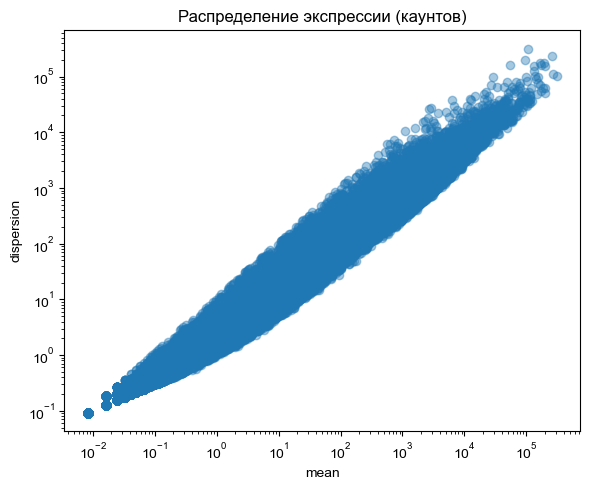

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
plt.scatter(expr_counts.T.mean(), expr_counts.T.std(), alpha = 0.4)
plt.title('Распределение экспрессии (каунтов)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean')
ax.set_ylabel('dispersion')
plt.tight_layout()

## Ensembl ID to Gene

### **Референсы**

1. <head></head>
 <body>
     <a href="https://www.ensembl.org/index.html">Ensembl</a>
 </body>
</html>


2. <head></head>
 <body>
     <a href="https://asia.ensembl.org/Help/Faq?id=488">ENSG = Gene ENST = Transcript</a>
 </body>
</html>


3. <head></head>
 <body>
     <a href="https://www.ncbi.nlm.nih.gov/refseq/">Refseq</a>
 </body>
</html>


4. <head></head>
 <body>
     <a href="https://www.gencodegenes.org/human/">Gencode</a>
 </body>
</html>

5. <head></head>
 <body>
     <a href="https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Thymoma%20(THYM)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443">Cайт xena</a>
 </body>
</html>


In [ ]:
# в терминале скачала аннотацию, часто используется для анализа  RNA-seq
wget -O gencode.v22.annotation.gene.probeMap https://gdc-hub.s3.us-east-1.amazonaws.com/download/gencode.v22.annotation.gene.probeMap

In [489]:
df_gene_names = pd.read_csv('gencode.v22.annotation.gene.probeMap',  sep = '\t')
df_gene_names.head()

#Каждому id присвоено имя гена, номер хромосомы, координаты [start:end], sense(+) или antisense(-) цепь

id          gene chrom  chromStart  chromEnd strand
0  ENSG00000223972.5       DDX11L1  chr1       11869     14409      +
1  ENSG00000227232.5        WASH7P  chr1       14404     29570      -
2  ENSG00000278267.1     MIR6859-3  chr1       17369     17436      -
3  ENSG00000243485.3  RP11-34P13.3  chr1       29554     31109      +
4  ENSG00000274890.1     MIR1302-9  chr1       30366     30503      +

In [85]:
df_gene_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60483 entries, 0 to 60482
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          60483 non-null  object
 1   gene        60483 non-null  object
 2   chrom       60483 non-null  object
 3   chromStart  60483 non-null  int64 
 4   chromEnd    60483 non-null  int64 
 5   strand      60483 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


In [429]:
df_gene_names.isna().sum() #нет незаполненных данных в таблице

id            0
gene          0
chrom         0
chromStart    0
chromEnd      0
strand        0
dtype: int64

In [490]:
dict_gene_names = dict(zip(*df_gene_names[['id', 'gene']].values.T))

# # replace gene ids -> gene names
expr_counts.index = pd.Series(expr_counts.index).map(dict_gene_names).fillna(pd.Series(expr_counts.index))

In [491]:
display(expr_counts.shape)
expr_counts.head(3)

(60483, 121)

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  \
Ensembl_ID                                                         
TSPAN6             12.529919         10.977995         11.023061   
TNMD                3.169925          4.584963          2.000000   
DPM1               11.310613         10.790348         11.384784   

            TCGA-XM-A8RH-01A  TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  \
Ensembl_ID                                                         
TSPAN6             10.507795         10.450180         11.343741   
TNMD                5.700440          2.584963          6.714246   
DPM1               11.228217         11.429407         10.924813   

            TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  TCGA-X7-A8M1-01A  \
Ensembl_ID                                                         
TSPAN6              9.758223         10.393390         11.418907   
TNMD                2.000000          4.643856          5.426265   
DPM1               10.658211         10.686501         11.002815   

            TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  TCGA-3G-AB0T-01A  \
Ensembl_ID                    ...                                       
TSPAN6             10.018200  ...         11.879966         10.131857   
TNMD                1.000000  ...          6.149747          2.000000   
DPM1               10.099348  ...         10.986553          9.703904   

            TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  TCGA-YT-A95E-01A  \
Ensembl_ID                                                         
TSPAN6             10.023754          8.625709         10.461479   
TNMD                3.459432          4.169925          4.169925   
DPM1                9.896332         11.152919         10.597121   

            TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  TCGA-X7-A8D6-11A  \
Ensembl_ID                                                         
TSPAN6              9.169925          8.903882         11.163021   
TNMD                1.000000          5.000000         11.624795   
DPM1                8.353147          9.667112         10.818582   

            TCGA-ZB-A96R-01A  TCGA-ZB-A96H-01A  
Ensembl_ID                                      
TSPAN6              9.036174         12.590821  
TNMD                2.584963          5.357552  
DPM1               10.852530         10.787903  

[3 rows x 121 columns]

Теперь вместо идентификатора (ID) гена мы видим его название

In [492]:
expr_counts = expr_counts.astype(int)
expr_counts.head(5)

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  \
Ensembl_ID                                                         
TSPAN6                    12                10                11   
TNMD                       3                 4                 2   
DPM1                      11                10                11   
SCYL3                     10                 9                10   
C1orf112                   8                 9                10   

            TCGA-XM-A8RH-01A  TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  \
Ensembl_ID                                                         
TSPAN6                    10                10                11   
TNMD                       5                 2                 6   
DPM1                      11                11                10   
SCYL3                     10                10                 9   
C1orf112                  10                10                 8   

            TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  TCGA-X7-A8M1-01A  \
Ensembl_ID                                                         
TSPAN6                     9                10                11   
TNMD                       2                 4                 5   
DPM1                      10                10                11   
SCYL3                      9                 9                10   
C1orf112                   9                 8                 9   

            TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  TCGA-3G-AB0T-01A  \
Ensembl_ID                    ...                                       
TSPAN6                    10  ...                11                10   
TNMD                       1  ...                 6                 2   
DPM1                      10  ...                10                 9   
SCYL3                      8  ...                 9                 8   
C1orf112                   7  ...                 7                 8   

            TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  TCGA-YT-A95E-01A  \
Ensembl_ID                                                         
TSPAN6                    10                 8                10   
TNMD                       3                 4                 4   
DPM1                       9                11                10   
SCYL3                      8                10                 9   
C1orf112                   8                10                 9   

            TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  TCGA-X7-A8D6-11A  \
Ensembl_ID                                                         
TSPAN6                     9                 8                11   
TNMD                       1                 5                11   
DPM1                       8                 9                10   
SCYL3                      7                 8                10   
C1orf112                   6                 8                 8   

            TCGA-ZB-A96R-01A  TCGA-ZB-A96H-01A  
Ensembl_ID                                      
TSPAN6                     9                12  
TNMD                       2                 5  
DPM1                      10                10  
SCYL3                      9                10  
C1orf112                   9                 8  

[5 rows x 121 columns]

## Gene selection

Выберем из gtf гены с половых хромосом, выкинем их рассмотрения (для простоты, в случае дисбаланса в выборке, они могут определиться как дифференциально экспрессированные, это можно скорректировать, учтя пол в модели)

In [20]:
!pip install gtfparse==1.3.0
from gtfparse import read_gtf

Файлик брала отсюда:  <head></head>
 <body>
     <a href="https://www.gencodegenes.org/human/release_29.html">GenCode v29 annotation</a>
 </body>
</html>

In [501]:
df = read_gtf("gencode.v29.annotation.gtf")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [502]:
df.head(2)

seqname  source     feature  start    end  score strand frame  \
0    chr1  HAVANA        gene  11869  14409    NaN      +     0   
1    chr1  HAVANA  transcript  11869  14409    NaN      +     0   

             gene_id                           gene_type  ...  \
0  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   
1  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   

        transcript_type transcript_name transcript_support_level    tag  \
0                                                                         
1  processed_transcript     DDX11L1-202                        1  basic   

      havana_transcript exon_number exon_id ont protein_id ccdsid  
0                                                                  
1  OTTHUMT00000362751.1                                            

[2 rows x 24 columns]

In [503]:
df = df[['seqname','gene_name', 'gene_type']].drop_duplicates()

In [504]:
df.head(2)

seqname gene_name                           gene_type
0     chr1   DDX11L1  transcribed_unprocessed_pseudogene
12    chr1    WASH7P              unprocessed_pseudogene

In [505]:
df['gene_type'].unique()

array(['transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene',
       'miRNA', 'lincRNA', 'protein_coding', 'processed_pseudogene',
       'antisense', 'processed_transcript', 'snRNA',
       'transcribed_processed_pseudogene', 'sense_intronic', 'misc_RNA',
       'TEC', 'transcribed_unitary_pseudogene', 'snoRNA', 'scaRNA',
       'rRNA_pseudogene', 'unitary_pseudogene',
       '3prime_overlapping_ncRNA', 'polymorphic_pseudogene',
       'bidirectional_promoter_lncRNA', 'sense_overlapping', 'pseudogene',
       'rRNA', 'IG_V_pseudogene', 'scRNA', 'IG_V_gene', 'IG_C_gene',
       'IG_J_gene', 'sRNA', 'ribozyme', 'translated_processed_pseudogene',
       'vaultRNA', 'TR_C_gene', 'TR_J_gene', 'TR_V_gene',
       'TR_V_pseudogene', 'TR_D_gene', 'IG_C_pseudogene', 'non_coding',
       'macro_lncRNA', 'TR_J_pseudogene', 'IG_J_pseudogene', 'IG_D_gene',
       'IG_pseudogene', 'Mt_tRNA', 'Mt_rRNA'], dtype=object)

In [506]:
sex_genes = df[df.seqname.isin(["chrX", "chrY"])].gene_name.unique()

In [507]:
target_genes = list(set(df[df.gene_type=="protein_coding"].gene_name) - set(sex_genes)) # отфильтровали и выкинули половые(

In [508]:
len(target_genes)

19018

In [509]:
# remove non-coding
expr_counts = expr_counts.loc[list(set(target_genes) & set(expr_counts.index))]
display(expr_counts.shape)
expr_counts.head(3)

(17871, 121)

TCGA-XU-A92T-01A  TCGA-ZB-A96A-01A  TCGA-X7-A8M3-01A  \
Ensembl_ID                                                         
MARC1                     10                 7                 9   
KDM3A                     12                11                10   
LRRC61                    10                11                 9   

            TCGA-XM-A8RH-01A  TCGA-4X-A9FB-01A  TCGA-XU-A92O-01A  \
Ensembl_ID                                                         
MARC1                      8                 7                 8   
KDM3A                     12                12                10   
LRRC61                    11                11                11   

            TCGA-XU-AAY1-01A  TCGA-X7-A8DF-01A  TCGA-X7-A8M1-01A  \
Ensembl_ID                                                         
MARC1                      7                 9                 9   
KDM3A                     10                10                12   
LRRC61                    11                11                10   

            TCGA-XM-A8R9-01A  ...  TCGA-XM-AAZ3-01A  TCGA-3G-AB0T-01A  \
Ensembl_ID                    ...                                       
MARC1                      8  ...                 9                 7   
KDM3A                     10  ...                11                10   
LRRC61                     9  ...                 9                11   

            TCGA-4V-A9QU-01A  TCGA-XM-A8RL-01A  TCGA-YT-A95E-01A  \
Ensembl_ID                                                         
MARC1                      8                 5                 8   
KDM3A                     11                12                11   
LRRC61                    10                11                11   

            TCGA-5U-AB0F-01A  TCGA-X7-A8DD-01A  TCGA-X7-A8D6-11A  \
Ensembl_ID                                                         
MARC1                      6                 7                12   
KDM3A                      8                10                12   
LRRC61                    10                11                10   

            TCGA-ZB-A96R-01A  TCGA-ZB-A96H-01A  
Ensembl_ID                                      
MARC1                      6                 8  
KDM3A                     11                11  
LRRC61                    11                11  

[3 rows x 121 columns]

In [510]:
expr_counts.index.value_counts(ascending = False)

Ensembl_ID
GPR75-ASB3    2
IL12RB2       2
PRICKLE4      2
OR5H6         2
SIGLEC5       2
             ..
KCNA6         1
SPIRE2        1
TGM5          1
C6orf62       1
ADI1          1
Name: count, Length: 17765, dtype: int64

In [535]:
expr_counts[expr_counts.index.value_counts() == 2].shape[0] #в таблице их 212 всего

212

Как видно, некоторым генам соответствует несколько **Ensemble ID**. Это могут быть гены,  которые:
1. подвергаются **альтернативному сплайсингу**, могут кодировать различные **изоформы** белков. Каждая изоформа может иметь собственный **Ensemble ID**.
2. являются **паралогами**, возникшими в результате дубликации. Они часто имеют разные функции и могут быть представлены несколькими Ensemble ID. Примеры таких генов включают семейства генов, как например, гены, связанные с иммунным ответом.
3. может быть вариантом оказаться гены **с высоким уровнем мутаций и полиморфизма**
4. и дополнительно может выступать **тканевая специфичность**

In [34]:
expr_counts = expr_counts.iloc[~expr_counts.index.duplicated()]
expr_counts.shape

(17765, 121)

https://asia.ensembl.org/info/genome/genebuild/haplotypes_patches.html

# Load annotation

In [98]:
ann = pd.read_csv('THYM_ann_short.tsv', sep = '\t', index_col = 0)
#ann.index = ann['Sample ID']

In [99]:
ann.head(2)

Patient_ID        Sample_ID  Aneuploidy_score  \
Sample ID                                                           
TCGA-3G-AB0O-01A  TCGA-3G-AB0O  TCGA-3G-AB0O-01               0.0   
TCGA-3G-AB0Q-01A  TCGA-3G-AB0Q  TCGA-3G-AB0Q-01               0.0   

                 Neoadjuvant_therapy_before_resection  Mutation_count Relapse  \
Sample ID                                                                       
TCGA-3G-AB0O-01A                                   No              10      No   
TCGA-3G-AB0Q-01A                                  Yes              23      No   

                 Sample_type    Site         Histology MG_status  
Sample ID                                                         
TCGA-3G-AB0O-01A     Primary  Thymus  Thymoma, Type B1        NO  
TCGA-3G-AB0Q-01A     Primary  Thymus   Thymoma, Type A       NaN

In [42]:
ann.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, TCGA-3G-AB0O-01A to TCGA-ZT-A8OM-01A
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient_ID                            123 non-null    object 
 1   Sample_ID                             123 non-null    object 
 2   Aneuploidy_score                      106 non-null    float64
 3   Neoadjuvant_therapy_before_resection  123 non-null    object 
 4   Mutation_count                        123 non-null    int64  
 5   Relapse                               121 non-null    object 
 6   Sample_type                           123 non-null    object 
 7   Site                                  123 non-null    object 
 8   Histology                             123 non-null    object 
 9   MG_status                             113 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 10.6+ KB


In [100]:
ann.describe()

Aneuploidy_score  Mutation_count
count        106.000000      123.000000
mean           3.839623       22.154472
std            8.033426       55.453870
min            0.000000        1.000000
25%            0.000000       10.000000
50%            0.000000       14.000000
75%            2.750000       24.000000
max           39.000000      620.000000

In [101]:
ann['Histology'].value_counts()

Histology
Thymoma, Type Ab                     38
Thymoma, Type B2                     27
Thymoma, Type A                      15
Thymoma, Type B1                     14
Thymoma, Type B3                     12
Thymoma, Type C                      11
Thymoma, Type B2|Thymoma, Type B3     3
Thymoma, Type A|Thymoma, Type Ab      2
Thymoma, Type B1|Thymoma, Type B2     1
Name: count, dtype: int64

In [102]:
ann['Histology'].value_counts(normalize = True, ascending= False)

Histology
Thymoma, Type Ab                     0.308943
Thymoma, Type B2                     0.219512
Thymoma, Type A                      0.121951
Thymoma, Type B1                     0.113821
Thymoma, Type B3                     0.097561
Thymoma, Type C                      0.089431
Thymoma, Type B2|Thymoma, Type B3    0.024390
Thymoma, Type A|Thymoma, Type Ab     0.016260
Thymoma, Type B1|Thymoma, Type B2    0.008130
Name: proportion, dtype: float64

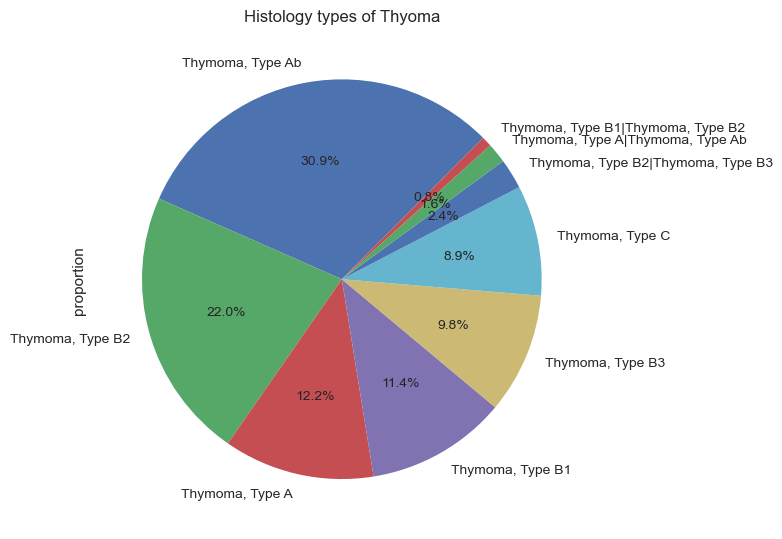

In [103]:
ann['Histology'].value_counts(normalize = True, ascending= False).plot(kind = 'pie', autopct='%1.1f%%', startangle=45)
plt.title('Histology types of Thyoma')
plt.tight_layout()

In [104]:
ann['Relapse'].value_counts()

Relapse
No     107
Yes     14
Name: count, dtype: int64

In [105]:
relapse = ann['Relapse'].value_counts()[1]/ann['Relapse'].value_counts()[0]
print(f'Доля рецидива составляет: {round(relapse* 100,2)}%')

Доля рецидива составляет: 13.08%


In [106]:
ann['MG_status'].value_counts() #статус аннотации гена

MG_status
NO     82
YES    31
Name: count, dtype: int64

*Какие закономерности есть в распределениях?*

Как мы можем увидеть из полученных данных, в распределении наиболее встречается **конкретный (одиночный) тип тимомы** (Thymoma, Type Ab (31%), Thymoma, Type B2 (22%)) и **реже всего можно увидеть смешанные типы тимомы** (к примеру, hymoma, Type B2|Thymoma, Type B3, Thymoma, Type A|Thymoma, Type Ab, и Thymoma, Type B1|Thymoma, Type B2, встречаются значительно реже, с частотой менее 3%)

Если посмотреть, то в выборке пациентов преобладает группа с отрицательным статусом рецидива и отрицательным MG статусом. Можно предположить, что отрицательный статус рецедива может быть связан с отрицательным статусом аннотации гена

In [107]:
ann = ann[(ann['Histology'] != 'Thymoma, Type B1|Thymoma, Type B2') &
          (ann['Histology'] != 'Thymoma, Type A|Thymoma, Type Ab') &
         (ann['Histology'] != 'Thymoma, Type B2|Thymoma, Type B3')]

R не переваривает пробелы в названиях, так что уберем их

In [108]:
ann['Histology'].unique()

array(['Thymoma, Type B1', 'Thymoma, Type A', 'Thymoma, Type B2',
       'Thymoma, Type C', 'Thymoma, Type B3', 'Thymoma, Type Ab'],
      dtype=object)

In [109]:
ann['Histology'] = ann['Histology'].replace({'Thymoma, Type Ab':'Ab',
                                            'Thymoma, Type B1':'B1',
                                            'Thymoma, Type A':'A',
                                           'Thymoma, Type B2':'B2',
                                            'Thymoma, Type B3':'B3',
                                            'Thymoma, Type C':'C'})

Обязательно надо проверить, что образцы совпадают между таблицей экспрессии и аннотацией, иначеничего работать не будет:

In [110]:
expr = expr_counts[list(set(ann.index) & set(expr_counts.columns))]
expr.index.name = None
ann = ann.loc[expr.columns]

display(expr.shape)
display(ann.shape)

(17765, 112)

(112, 10)

In [112]:
ann.head(2)

Patient_ID        Sample_ID  Aneuploidy_score  \
TCGA-4V-A9QL-01A  TCGA-4V-A9QL  TCGA-4V-A9QL-01               0.0   
TCGA-ZB-A96H-01A  TCGA-ZB-A96H  TCGA-ZB-A96H-01               0.0   

                 Neoadjuvant_therapy_before_resection  Mutation_count Relapse  \
TCGA-4V-A9QL-01A                                   No              12      No   
TCGA-ZB-A96H-01A                                   No              23      No   

                 Sample_type    Site Histology MG_status  
TCGA-4V-A9QL-01A     Primary  Thymus        Ab        NO  
TCGA-ZB-A96H-01A     Primary  Thymus         A        NO

In [113]:
expr.head()

TCGA-4V-A9QL-01A  TCGA-ZB-A96H-01A  TCGA-ZB-A964-01A  \
MARC1                504               370               890   
KDM3A               2867              3897              4623   
LRRC61              3628              2539              2024   
DONSON              1012               567               406   
ADI1                4641              7879              6168   

        TCGA-XH-A853-01A  TCGA-4V-A9QU-01A  TCGA-ZB-A96L-01A  \
MARC1                471               383               326   
KDM3A               3795              2235              7768   
LRRC61              2838              1802               760   
DONSON              1120              1020               754   
ADI1                4201              2155              8198   

        TCGA-X7-A8DD-01A  TCGA-ZB-A961-01A  TCGA-4X-A9FC-01A  \
MARC1                147               183               269   
KDM3A               1167              1729              3251   
LRRC61              2564               446              2437   
DONSON               497               426              1307   
ADI1                2026              4840              2628   

        TCGA-4V-A9QS-01A  ...  TCGA-ZB-A96P-01A  TCGA-5G-A9ZZ-01A  \
MARC1                415  ...                52               534   
KDM3A               2789  ...              7381              7331   
LRRC61              1741  ...              3829               762   
DONSON              1311  ...              1665               653   
ADI1                6277  ...              4045              8859   

        TCGA-4V-A9QJ-01A  TCGA-5U-AB0E-01A  TCGA-4X-A9F9-01A  \
MARC1                390               144                54   
KDM3A               2448              1220              1123   
LRRC61              1712              2047              1500   
DONSON              1210               606               585   
ADI1                4803              9149              2585   

        TCGA-ZB-A969-01A  TCGA-XU-A92X-01A  TCGA-XM-A8RF-01A  \
MARC1                941               164              1449   
KDM3A               6136               898              2512   
LRRC61                66              1836              1470   
DONSON               945               426               700   
ADI1                5115              3035              5798   

        TCGA-3G-AB14-01A  TCGA-ZB-A966-01A  
MARC1                577              1005  
KDM3A               1762              1638  
LRRC61               862              2386  
DONSON              1006               518  
ADI1                4604              3375  

[5 rows x 112 columns]

# Load FPKM, FPKM -> TPM

In [ ]:
!wget https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-THYM.htseq_fpkm.tsv.gz

In [390]:
expr_fpkm = pd.read_csv('TCGA-THYM.htseq_fpkm.tsv.gz', sep = '\t', index_col=0)
expr_fpkm.shape

(60483, 121)

In [391]:
# обратное преобразование из log2 в числа
expr_fpkm = pow(2, expr_fpkm) - 1

# заменим id гена на имя гена
expr_fpkm.index = pd.Series(expr_fpkm.index).map(dict_gene_names).fillna(pd.Series(expr_fpkm.index))

# отфильтруем
expr_fpkm = expr_fpkm.loc[list(set(target_genes) & set(expr_fpkm.index))]
expr_fpkm = expr_fpkm.iloc[~expr_fpkm.index.duplicated()]

# выберем образцы
expr_fpkm = expr_fpkm[list(set(ann.index) & set(expr_fpkm.columns))]
expr_fpkm.index.name = None

print(expr_fpkm.shape)

(17765, 109)


In [392]:
#tpm 
expr_tpm = expr_fpkm / expr_fpkm.sum() * 1e6

In [393]:
expr_tpm.sum()

TCGA-4V-A9QL-01A    1000000.0
TCGA-ZB-A96H-01A    1000000.0
TCGA-ZB-A964-01A    1000000.0
TCGA-XH-A853-01A    1000000.0
TCGA-4V-A9QU-01A    1000000.0
                      ...    
TCGA-ZB-A969-01A    1000000.0
TCGA-XU-A92X-01A    1000000.0
TCGA-XM-A8RF-01A    1000000.0
TCGA-3G-AB14-01A    1000000.0
TCGA-ZB-A966-01A    1000000.0
Length: 109, dtype: float64

Text(0.5, 1.0, 'TPM')

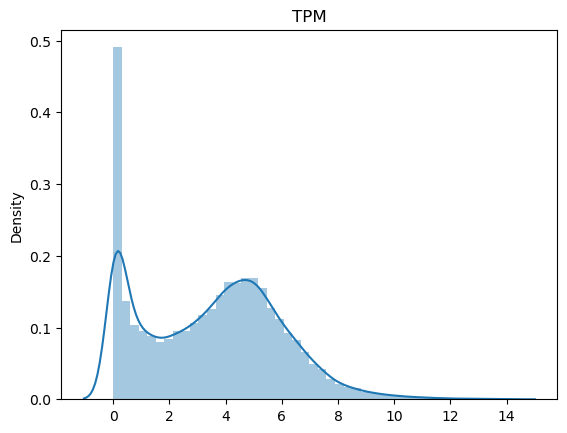

In [394]:
plt.style.use('default')
sns.distplot(np.log2(expr_tpm.T.mean() + 1)).set_title('TPM')

# Biological batches and other stuff

In [124]:
import sklearn
from sklearn.decomposition import PCA

Когда смотрим батчи на PCA, изпользуем TPM/FPKM - на каунтах можно увидеть в целом что угодно (в том числе ложные закономерности)

In [395]:
#for counts

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann.loc[ann.index == i, 'Histology'].values[0] for i in expr.columns]
color_mg = [ann.loc[ann.index == i, 'MG_status'].values[0] for i in expr.columns]

<Axes: xlabel='PC1', ylabel='PC2'>

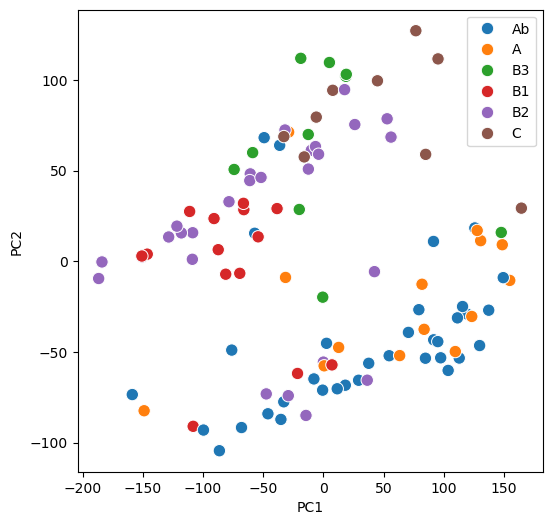

In [396]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

*Так выглядит правильный PCA для того, чтобы посмотреть на биологические батчи. А что такое технический батч?*

**Технический батч** - группа образцов, обработанных одновременно или в схожих условиях, что может привести к систематическим ошибкам или вариациям в результатах. Например, если у нас отличаются условия протокола, реагенты, какие-либо еще условия проведения эксперимента.

**Биологический батч** - различия между образцами, которые действительно отражают биологические вариации. То есть проблема технических батчей может быть в том, что они могут стать причиной ошибочной интерпретации (можно принять их за биологический батч). Если образцы с одинаковыми биологическими характеристиками (гистологическим статусом) располагаются близко друг к другу на PCA-графике, это указывает на то, что различия между группами действительно обусловлены биологическими факторами.


<Axes: xlabel='PC1', ylabel='PC2'>

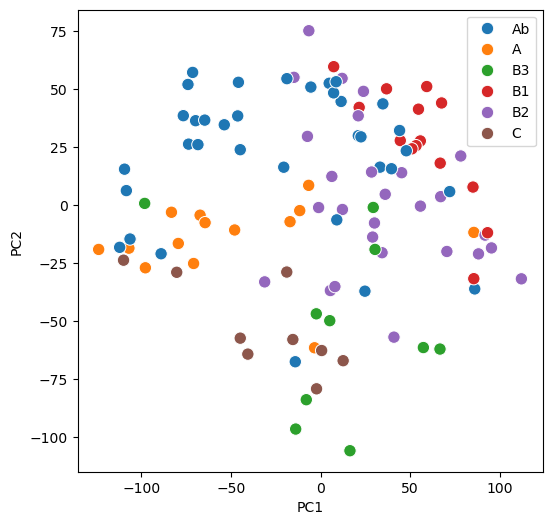

In [397]:
#for tpm

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr_tpm+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann.loc[ann.index == i, 'Histology'].values[0] for i in expr.columns]
color_mg = [ann.loc[ann.index == i, 'MG_status'].values[0] for i in expr.columns]

plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

In [145]:
pca_expr.explained_variance_ratio_

array([0.29180211, 0.13622988])

Первые два главных компонента вместе объясняют примерно 44% общей дисперсии в данных. В целом, такое небольшое значение может получиться, потому что у нас много генов

<Axes: xlabel='PC1', ylabel='PC2'>

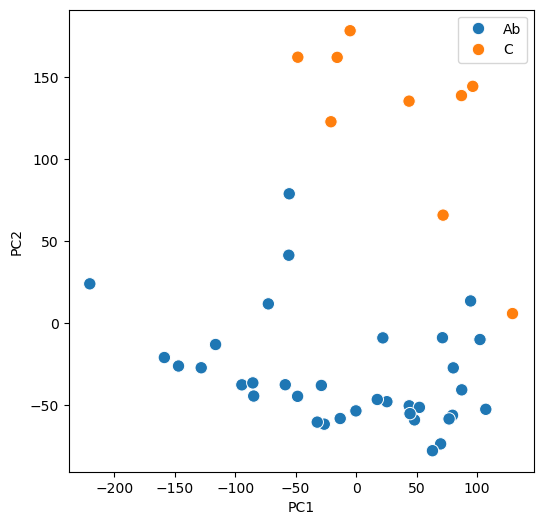

In [399]:
#for tpm C and B1 only
ann_sel = ann[(ann['Histology'] == 'Ab') | (ann['Histology'] == 'C')]
expr_tpm_sel = expr[ann_sel.index]

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr_tpm_sel+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann_sel.loc[ann_sel.index == i, 'Histology'].values[0] for i in expr_tpm_sel.columns]
color_mg = [ann_sel.loc[ann_sel.index == i, 'MG_status'].values[0] for i in expr_tpm_sel.columns]

plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

In [131]:
pca_expr.explained_variance_ratio_ * 100

array([27.72835472, 20.14395743])

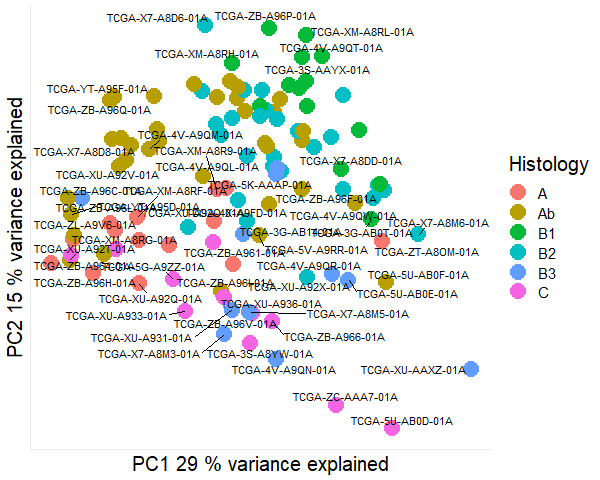

In [138]:
%%R -w 600 -i expr_tpm -i ann
library(ggplot2)
library(ggrepel)
expr_tpm_log = log(expr_tpm + 1, 2)
a <- prcomp(t(expr_tpm_log))
PC1_var <- round((summary(a)[[6]][2,1])*100)
PC2_var <- round((summary(a)[[6]][2,2])*100)
a <- as.data.frame(a$x[,1:2])
a$Patient  <- rownames(ann)
a$Histology <- factor(ann$Histology) # your factor here
p1 <- ggplot(data=a, aes(x=PC1,y=PC2), dpi=300)+
    geom_point(aes(color=Histology), alpha=1, size=7)+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=20),
         axis.title.y = element_text(size=20),
         legend.text = element_text(size = 15), legend.title = element_text(size=20),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab(paste("PC1", PC1_var, "% variance explained"))+
    ylab(paste("PC2", PC2_var, "% variance explained"))+
    geom_text_repel(data=a, aes(label=Patient), nudge_x = 0.1, nudge_y = 0.1, direction = "both")
p1

In [140]:
ann = ann.drop(index = ('TCGA-XU-AAXZ-01A'))
expr = expr.drop(columns = ('TCGA-XU-AAXZ-01A'))
expr_tpm = expr_tpm.drop(columns = ('TCGA-XU-AAXZ-01A'))

In [141]:
# #drop 2 samples more
ann = ann.drop(index = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr = expr.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr_tpm = expr_tpm.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr_fpkm = expr_fpkm.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])

In [142]:
expr_tpm.shape

(17765, 109)

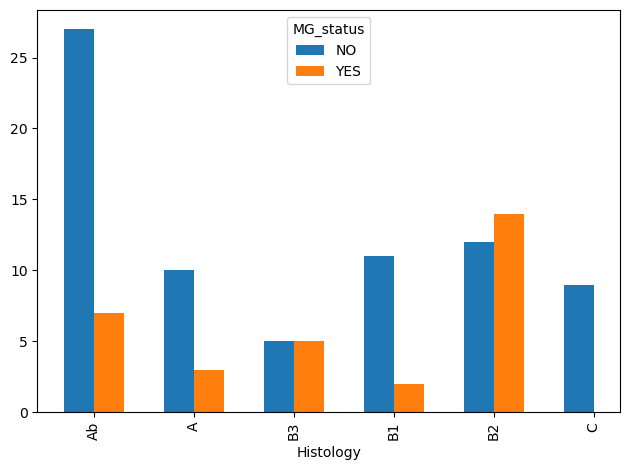

p_value = 0.006870247255942192


In [400]:
df = ann[['MG_status', 'Histology']].dropna()

groups = list(df['Histology'].unique())
markers = list(df['MG_status'].unique())

for i, marker in enumerate(markers):

    d = df[df['MG_status'] == marker]
    d = d['Histology'].value_counts()
    d = d.reindex(groups)

    width = 0.3
    x = np.arange(len(d)) - width / 2 + i * width
    plt.bar(x, d, width=width, label=marker)

plt.xticks(np.arange(len(groups)), groups, rotation=90)
plt.xlabel('Histology')
plt.legend(title='MG_status')
plt.tight_layout()
plt.show()

df_crosstab = pd.crosstab(df['MG_status'], df['Histology'], margins=False)
chi2, p, dof, ex = scipy.stats.chi2_contingency(df_crosstab)
print("p_value = {}".format(p))

In [158]:
scipy.stats.chi2_contingency(df_crosstab)

Chi2ContingencyResult(statistic=np.float64(15.990849629369551), pvalue=np.float64(0.006870247255942192), dof=5, expected_freq=array([[ 9.16190476, 23.96190476,  9.16190476, 18.32380952,  7.04761905,
         6.34285714],
       [ 3.83809524, 10.03809524,  3.83809524,  7.67619048,  2.95238095,
         2.65714286]]))

In [162]:
pat = ann[ann['Histology'] == 'C'].index[1]

In [163]:
np.log2(expr_tpm.T.mean() + 1).sort_values(ascending = False)[:20]

MT-CO3     13.967893
MT-CO2     13.839690
MT-CO1     13.601827
MT-ND4     13.396544
TMSB10     13.370787
MT-ND3     13.133317
MT-ATP6    13.073218
ACTB       12.858645
RPS12      12.842966
CCL25      12.822625
FTL        12.787282
RPS11      12.690018
MT-CYB     12.672178
MT-ND1     12.565570
RPL13A     12.472863
RPS27      12.466448
MT-ND2     12.368193
PLTP       12.340141
ACTG1      12.244341
RPS18      12.141792
dtype: float64

In [164]:
np.log2(expr_tpm.T.loc['TCGA-ZB-A963-01A'] + 1).sort_values(ascending = False)[:20]

MT-CO2     14.388766
MT-ND4     14.343739
MT-CO3     14.297221
MT-CO1     14.256052
MT-ATP6    13.715576
MT-ND3     13.631127
MT-CYB     13.407436
MT-ND1     13.288929
MT-ND4L    12.912353
MT-ATP8    12.903796
MT-ND2     12.893709
ACTB       12.784321
TMSB10     12.736128
FTL        12.638711
RPS12      12.392517
KRT14      12.321245
ACTG1      12.158212
MT-ND6     12.109800
KRT5       12.105601
RPS11      12.096812
Name: TCGA-ZB-A963-01A, dtype: float64

<Axes: ylabel='Density'>

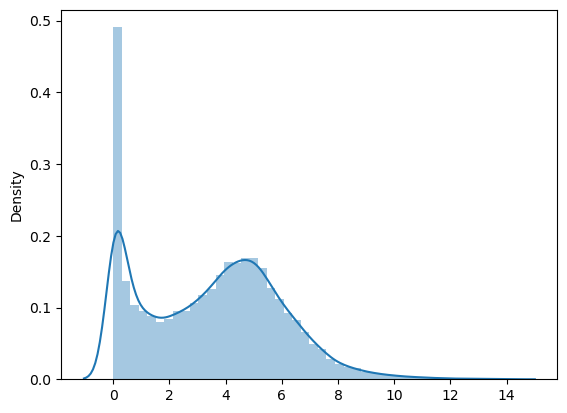

In [401]:
sns.distplot(np.log2(expr_tpm.T.mean() + 1))

In [168]:
expr_tpm = expr_tpm[~expr_tpm.index.str.startswith('MT-')]
expr_fpkm = expr_fpkm[~expr_fpkm.index.str.startswith('MT-')]
expr = expr[~expr.index.str.startswith('MT-')]
expr

TCGA-4V-A9QL-01A  TCGA-ZB-A96H-01A  TCGA-ZB-A964-01A  \
MARC1                  504               370               890   
KDM3A                 2867              3897              4623   
LRRC61                3628              2539              2024   
DONSON                1012               567               406   
ADI1                  4641              7879              6168   
...                    ...               ...               ...   
FUT3                    12               105                43   
MGRN1                 5624              4246              4993   
AQP1                 10512              5849              5841   
VRK3                  4253              1076              1839   
C19orf44              1285              1100              1390   

          TCGA-XH-A853-01A  TCGA-4V-A9QU-01A  TCGA-ZB-A96L-01A  \
MARC1                  471               383               326   
KDM3A                 3795              2235              7768   
LRRC61                2838              1802               760   
DONSON                1120              1020               754   
ADI1                  4201              2155              8198   
...                    ...               ...               ...   
FUT3                     6                10                58   
MGRN1                 4322              2098              7528   
AQP1                  5226              1000              4672   
VRK3                  4206              1167              2866   
C19orf44               987               474              1315   

          TCGA-X7-A8DD-01A  TCGA-ZB-A961-01A  TCGA-4X-A9FC-01A  \
MARC1                  147               183               269   
KDM3A                 1167              1729              3251   
LRRC61                2564               446              2437   
DONSON                 497               426              1307   
ADI1                  2026              4840              2628   
...                    ...               ...               ...   
FUT3                     3                 5                 1   
MGRN1                 1372              2346              2873   
AQP1                  4644              3842              4086   
VRK3                  3450              1914              2997   
C19orf44               769               554               581   

          TCGA-4V-A9QS-01A  ...  TCGA-ZB-A96P-01A  TCGA-5G-A9ZZ-01A  \
MARC1                  415  ...                52               534   
KDM3A                 2789  ...              7381              7331   
LRRC61                1741  ...              3829               762   
DONSON                1311  ...              1665               653   
ADI1                  6277  ...              4045              8859   
...                    ...  ...               ...               ...   
FUT3                    22  ...                 2              1747   
MGRN1                 2842  ...              5564              4786   
AQP1                  4512  ...              1764              1339   
VRK3                  3103  ...              6300              2470   
C19orf44               603  ...               991              1065   

          TCGA-4V-A9QJ-01A  TCGA-5U-AB0E-01A  TCGA-4X-A9F9-01A  \
MARC1                  390               144                54   
KDM3A                 2448              1220              1123   
LRRC61                1712              2047              1500   
DONSON                1210               606               585   
ADI1                  4803              9149              2585   
...                    ...               ...               ...   
FUT3                    29                27                 1   
MGRN1                 4279              3043              1444   
AQP1                  3406              5696              2526   
VRK3                  4822              3254              3774   
C19orf44               527              1127        

*Какие можно сделать выводы?*

Результаты оказались статистически значимыми (p_value = 0.006870247255942192 < p_value = 0.05), что дает основание утверждать, что отрицательный статус рецидива может быть непосредственно связан с отрицательным статусом аннотации гена.

# What is GLM

Проблема ненормальности остатков, нелинейности зависимости и гетероскедастичнсоти.

$$g(E(y_i))=g(\mu_i)=\beta_0+\beta_1x_1+...+\beta_nx_n$$

$$y_i\sim\text{exponential family distribution}({\overrightarrow\theta})$$

$g$ - функция связи (link-funсtion)

GLM состоит из 3 частей:
* Фиксированная часть - линейная комбинация предикторов
* Случайная часть - переменная отклика распределенная в соотвествии с распределением из семейства экспоененциальных
* Функция связи - функция связывающая (линеаризующая) мат.ожидание распределения отклика с линейной комбинацией предикторов

Коэффициенты оценивают с помощью метода максимального правдоподобия (MLE).

Значимость предикторов оценивают с помощью

- теста Вальда

- теста соотношения правдоподобий (likelihood ratio test, LRT)

In [178]:
%%R -i ann

fit <- glm(Mutation_count ~ MG_status + factor(Histology), data=ann, family="gaussian")
summary(fit)


Call:
glm(formula = Mutation_count ~ MG_status + factor(Histology), 
    family = "gaussian", data = ann)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-85.22   -5.27   -1.14    4.19  526.78  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)          21.2512    16.0897   1.321  0.18964   
MG_statusYES          2.5782    13.2350   0.195  0.84595   
factor(Histology)Ab  -3.4879    18.5761  -0.188  0.85145   
factor(Histology)B1 -14.1094    22.3637  -0.631  0.52957   
factor(Histology)B2 -12.5625    19.7714  -0.635  0.52666   
factor(Histology)B3  -0.4403    24.2210  -0.018  0.98553   
factor(Histology)C   71.9710    24.8865   2.892  0.00472 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 3244.134)

    Null deviance: 370582  on 104  degrees of freedom
Residual deviance: 317925  on  98  degrees of freedom
  (

Exception ignored from cffi callback <function _consolewrite_ex at 0x000002326C52BF40>:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\jupyter\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Admin\anaconda3\envs\jupyter\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xef in position 2: invalid continuation byte


)
AIC: 1155.6

Number of Fisher Scoring iterations: 2



# DE analysis

## edgeR

https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf

На вход edgeR принимает таблицу каунтов и таблицу с разметкой групп

In [179]:
%%R -i ann
ann$MG_status <- factor(ann$MG_status, levels=c('YES','NO'))

In [180]:
ann['Histology'].value_counts()

Histology
Ab    35
B2    27
A     14
B1    14
B3    10
C      9
Name: count, dtype: int64

In [181]:
%%R -i ann
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B3")
print(ann$Histology)

  [1] Ab A  A  Ab Ab B3 B1 A  Ab B2 Ab B1 B2 Ab B3 B2 A  Ab Ab Ab Ab Ab B1 Ab Ab
 [26] C  B2 B2 B2 B2 B1 Ab Ab A  B1 B1 Ab A  B2 C  Ab B2 B2 B2 Ab Ab B1 B2 B1 B3
 [51] B3 C  A  B1 Ab Ab C  B2 A  Ab B2 B2 B2 Ab C  Ab A  B2 B1 B1 A  B2 A  Ab B2
 [76] Ab B3 A  C  A  B3 B2 Ab Ab B3 B2 Ab B2 B1 B2 B2 Ab Ab B2 Ab Ab Ab B3 Ab B1
[101] C  B3 B3 B1 C  B2 A  B2 C 
Levels: B3 Ab B1 A B2 C


In [182]:
%%R
design <- model.matrix(~Histology, data=ann) #+Time
head(design)

                 (Intercept) HistologyAb HistologyB1 HistologyA HistologyB2
TCGA-4V-A9QL-01A           1           1           0          0           0
TCGA-ZB-A96H-01A           1           0           0          1           0
TCGA-ZB-A964-01A           1           0           0          1           0
TCGA-XH-A853-01A           1           1           0          0           0
TCGA-4V-A9QU-01A           1           1           0          0           0
TCGA-ZB-A96L-01A           1           0           0          0           0
                 HistologyC
TCGA-4V-A9QL-01A          0
TCGA-ZB-A96H-01A          0
TCGA-ZB-A964-01A          0
TCGA-XH-A853-01A          0
TCGA-4V-A9QU-01A          0
TCGA-ZB-A96L-01A          0


Таблицу каунтов мы загружаем в объект DGEList (rows=features, columns=samples), https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/DGEList

In [183]:
expr.shape

(17752, 109)

In [187]:
%%R -i expr
library(edgeR)
de_exp_table <- DGEList(expr, group = ann$Histology)
dim(design)

[1] 109   6


Отфильтровываем слабо экспрессированные гены. Они не представляют интереса при анализе дифференциальной экспрессии. Функция оставляет строки (гены), CPM которых > k минимум в n образцах.

Соответственно, пороги можно менять для более/менее строгой фильтрации.

In [188]:
%%R
keep <- filterByExpr(de_exp_table, design)
de_exp_table <- de_exp_table[keep, keep.lib.sizes=TRUE]
dim(de_exp_table)

[1] 15520   109


Дальше нужно нормализовать данные (TMM), чтобы учесть "закрытые" данные (на самом деле экспрессии у нас относительные) и глубину библиотеки. При этом нормировать на длину гена не обязательно, так как она одинакова между образцами. Основное допущение - большинство генов не являются дифференциально экспрессированными

Как работает нормализация данных в edgeR:

1) удаление генов с 0 каунтами во всех образцах

2) выбор образца относительно которого делается нормализация (наиболее "средний образец" - тот, чей 75ый квантиль ближе всех к среднему)
    
    - для каждого образца выбираем значение : 75% шкалированных значений меньше (квантиль)
    
    - усредняем 75th квантили
    
    - "средний" образец - тот, чем 75ый квантиль ближе всего к среднему

3) для каждого образца относительно среднего образца нужно выброать гены по которым считать коэффициенты для скэйлинга (разные наборы генов для разных образцов). При этом гены выбираются те, которые не сильно меняются по числу каунтов между референсом и образцом = выкидываются biased genes. Для каждого гены отдельно считает log2ratio, выкидываем по 30% biased genes с каждой стороны - by mean of the logs определяем гены, которые в обоих образцах сильно/мало экспрессируются гены, выкидываем по 5%. Используем гены, оставшиеся в пересечении

4) calculate weighted average of remaining log2 ratios -convert it to normal numbers -senter scaling factors around 1

Получаем набор коэффициентов, на которые нужно домножить глубину библиотеки.

In [189]:
%%R
de_exp_table <- calcNormFactors(de_exp_table)

In [190]:
%%R
head(de_exp_table$samples)

                 group lib.size norm.factors
TCGA-4V-A9QL-01A    Ab 60476932     1.024060
TCGA-ZB-A96H-01A     A 57834259     1.112193
TCGA-ZB-A964-01A     A 54158957     1.104491
TCGA-XH-A853-01A    Ab 50586038     1.033189
TCGA-4V-A9QU-01A    Ab 31330763     1.018352
TCGA-ZB-A96L-01A    B3 66127722     1.138645


Проверяем на батчи (Multidimencial Scaling похож на PCA, но с нелинейным преобразованием и в целом скорее класс методов):

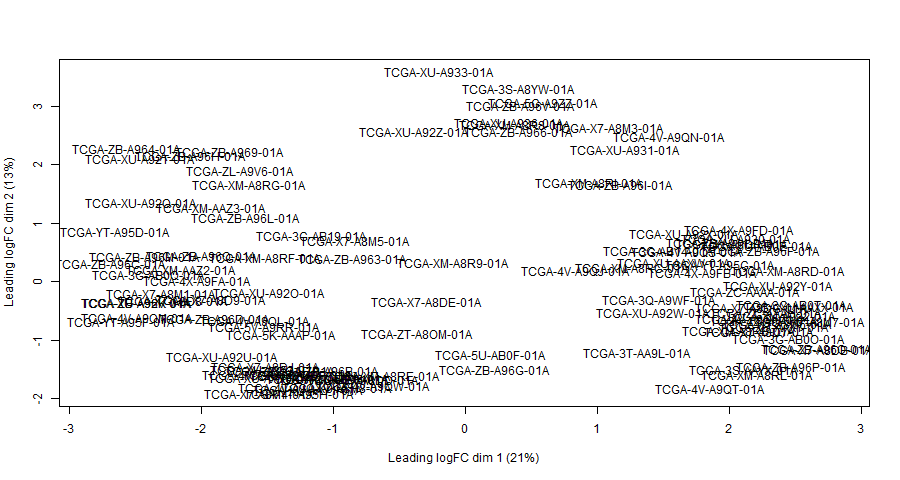

In [200]:
%%R -w 900
plotMDS(de_exp_table, labels = ann$Histology, cex = 0.4, pch = 19)
plotMDS(de_exp_table)

Оцениваем дисперсию NB-распределения (нужно понять, что у нас с вариабельностью внутри групп)

In [192]:
%%R
de_exp_table <- estimateDisp(de_exp_table, design)

На этом этапе оценивается парметр $\phi$ NB распределения. Метод оценки состоит из 3 этапов:
1. Оценка для каждого гена отдельно
2. Взятие среднего
3. Приведение значений для каждого гена ближе к среднему

(команду из предыдущей ячейке можно заменить на 3 последовательных)

Это нужно чтобы убрать существенные отличия в дисперсии между генами, которые могут возникать, например, из-за выбросов в данных.

Корень из $\phi$ называют "biological coefficient of variation" (BCV) или "dispersion"

$$BCV_g=\sqrt\phi_g$$


Оцениваем:
- дисперсию для каждого гена
- common (усредненную по всем генам)
- trend (предсказанную)

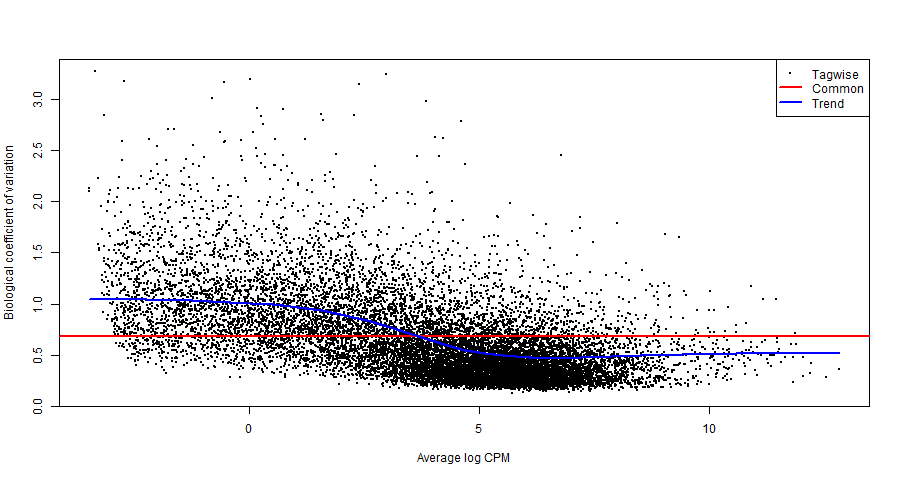

In [201]:
%%R -w 900
plotBCV(de_exp_table)

если реплик мало, можно еще внести допущение, что гены с похожей средней экспрессией имеют похожую дисперсию. Здесь не обязательно

In [202]:
%%R
names(de_exp_table)

 [1] "counts"             "samples"            "design"            
 [4] "common.dispersion"  "trended.dispersion" "tagwise.dispersion"
 [7] "AveLogCPM"          "trend.method"       "prior.df"          
[10] "prior.n"            "span"              


Оцениваем коэффициенты GLM:

In [206]:
%%R
library(statmod)
fit <- glmQLFit(de_exp_table, design, robust=TRUE)

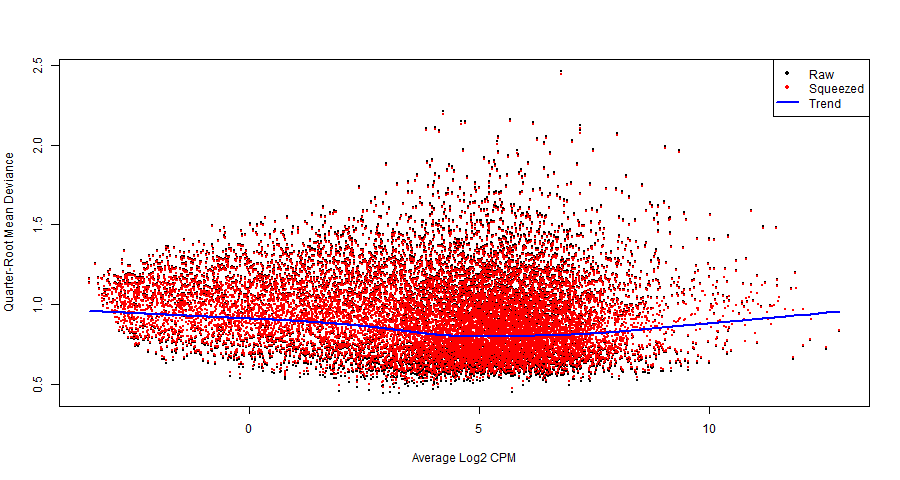

In [207]:
%%R -w 900
plotQLDisp(fit)

In [208]:
%%R
head(fit$coefficients)

       (Intercept) HistologyAb HistologyB1  HistologyA HistologyB2  HistologyC
MARC1   -10.824071 -0.55297396  -1.9600339 -0.33164709  -1.0964279  0.06302856
KDM3A    -9.798293  0.21922693   0.3522572  0.03029851   0.1869968  0.33094016
LRRC61  -10.566647  0.64898937   0.8746801  0.35655022   0.6471139  0.41549543
DONSON  -10.839604 -0.04014168   0.3490102 -0.58065661   0.1985678 -0.27764202
ADI1     -8.739548 -0.62006173  -0.6904049 -0.56016794  -0.5387478 -0.26760660
HCST    -10.591352  0.08181313   0.6370202 -0.08862855   0.4369176 -0.65440176


Делаем тест соотношения правдоподобий чтобы оценить значимость предикторов (если групп много, нужно использовать дополнительный аргумент coef, чтобы уточнить какой значимость какого коэффициента нужно посмотреть):

[1] 5.219566e-89

FALSE  TRUE 
15512     8 
[1] 5.191128e-39

FALSE  TRUE 
15512     8 
[1] 1.481266e-41

FALSE  TRUE 
15512     8 
[1] 1.613983e-37

FALSE  TRUE 
15512     8 
[1] 1.281444e-54

FALSE  TRUE 
15512     8 


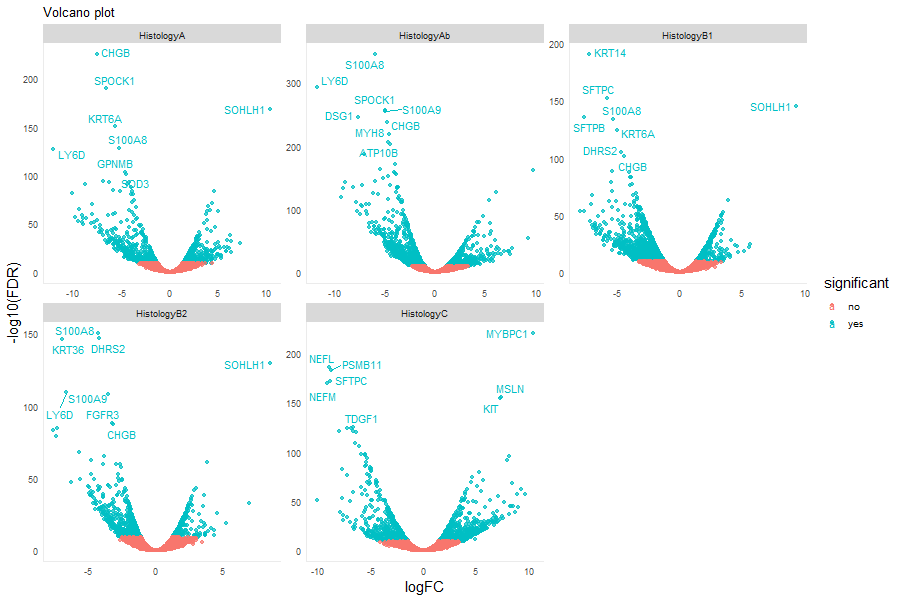

In [209]:
%%R -w 900 -h 600
VOLCANO <- data.frame()
for (i in seq(2,ncol(fit),1)){
    lrt <- glmLRT(fit, coef=i)
    todraw <- as.data.frame(topTags(lrt, n=20000))
    colnames(todraw)[1] <- "value"
    todraw$significant <- "no"
    todraw$significant[todraw$FDR<0.0001] <- "yes"

    todraw$BEST <- "no"
    x <- quantile(todraw$FDR, 0.0005)
    x <- x[[1]][1]
    print(x)
    todraw$BEST[as.numeric(todraw$FDR)<x] <- "yes"
    print(table(as.numeric(todraw$FDR)<x))

    todraw$FDR <- -log(todraw$FDR)

    todraw$logFC <- colnames(fit)[i]
    todraw$Gene <- rownames(todraw)
    VOLCANO <- rbind(VOLCANO, todraw)
}

#print(head(VOLCANO))

ggplot(data=VOLCANO, aes(x=value, y=FDR, color=significant, group=logFC))+
    geom_point(alpha=0.7)+
    geom_text_repel(data=VOLCANO[VOLCANO$BEST=="yes",], aes(label=Gene))+ # use this carefully  & abs(value)>3
    facet_wrap(~logFC, scales="free")+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          #axis.text.x = element_blank(),
          #axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=15),
         axis.title.y = element_text(size=15),
         legend.text = element_text(size = 10), legend.title = element_text(size=15),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab("logFC")+
    ggtitle("Volcano plot")+
    ylab("-log10(FDR)")

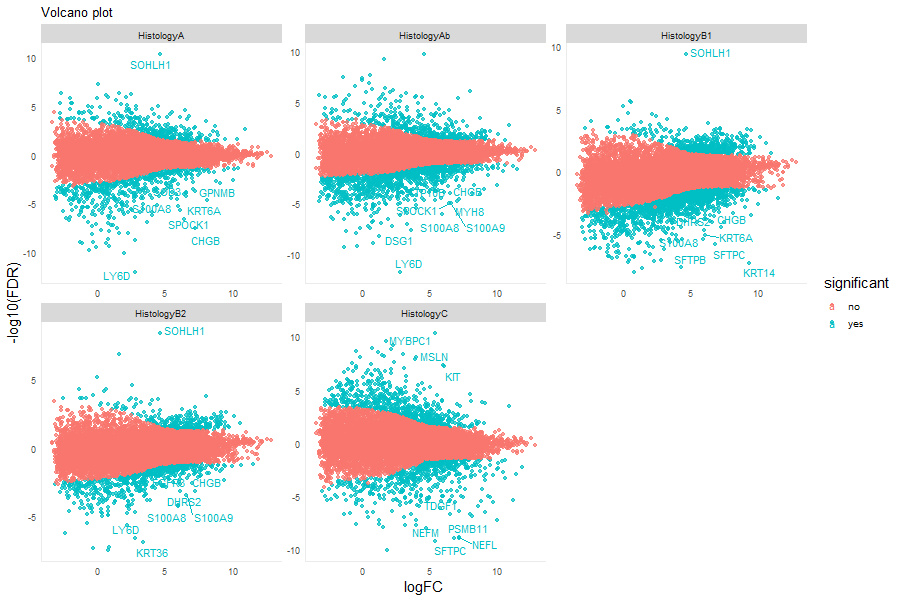

In [210]:
%%R -w 900 -h 600
ggplot(data=VOLCANO, aes(x=logCPM, y=value, color=significant, group=logFC))+
    geom_point(alpha=0.7)+
    geom_text_repel(data=VOLCANO[VOLCANO$BEST=="yes",], aes(label=Gene))+ # use this carefully  & abs(value)>3
    facet_wrap(~logFC, scales="free")+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          #axis.text.x = element_blank(),
          #axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=15),
         axis.title.y = element_text(size=15),
         legend.text = element_text(size = 10), legend.title = element_text(size=15),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab("logFC")+
    ggtitle("Volcano plot")+
    ylab("-log10(FDR)")

Экспортируем результат в Python (номер коэффициента берется из объекта fit, возьмем наличие карциномы тимуса):

In [211]:
%%R
colnames(fit)

[1] "(Intercept)" "HistologyAb" "HistologyB1" "HistologyA"  "HistologyB2"
[6] "HistologyC" 


Экспортируем результат для Thymic carcinoma VS Ab

In [212]:
%%R
lrt <- glmLRT(fit, coef=6)
edger_res <- as.data.frame(topTags(lrt, n=20000))

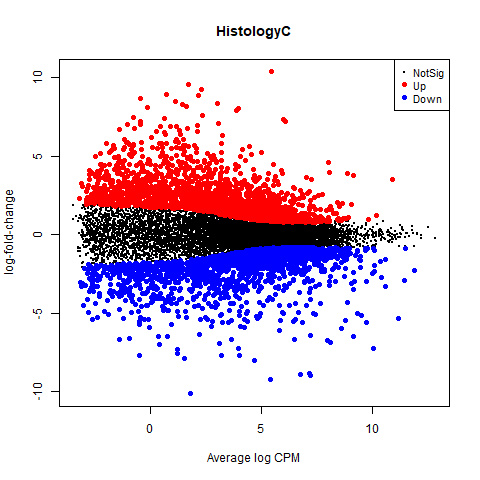

In [213]:
%%R
plotMD(lrt)

In [214]:
%R -o edger_res

In [215]:
edger_res

logFC    logCPM            LR         PValue           FDR
MYBPC1   10.347603  5.423698  4.538683e+02  1.038192e-100  1.611274e-96
NEFL     -8.930203  7.190604  3.834340e+02   2.225017e-85  1.726613e-81
PSMB11   -8.800845  7.150445  3.755084e+02   1.182680e-83  6.118396e-80
SFTPC    -8.898911  6.775383  3.542842e+02   4.945507e-79  1.918857e-75
NEFM     -9.177562  5.386352  3.487821e+02   7.804602e-78  2.422548e-74
...            ...       ...           ...            ...           ...
SNX11     0.000132  5.051100  1.482383e-07   9.996928e-01  9.999505e-01
SPECC1    0.000109  3.677125  5.842747e-08   9.998071e-01  9.999596e-01
WDR33    -0.000033  6.911326  1.109089e-08   9.999160e-01  9.999596e-01
CCL21    -0.000034  4.653404  8.647021e-09   9.999258e-01  9.999596e-01
ZFYVE16   0.000019  4.531823  2.565059e-09   9.999596e-01  9.999596e-01

[15520 rows x 5 columns]

In [216]:
edger_res = edger_res.sort_values(by = 'logFC', ascending = False)[edger_res['FDR'] < 0.01]

In [217]:
edger_res

logFC    logCPM          LR         PValue           FDR
MYBPC1   10.347603  5.423698  453.868285  1.038192e-100  1.611274e-96
IGF2BP3   9.574630  1.714077  119.377799   8.656729e-28  2.132578e-25
SOX14     9.221665  2.287420  129.859426   4.398505e-30  1.312784e-27
BARX1     8.932682  0.691321   94.246772   2.785406e-22  4.550474e-20
FOXI1     8.832107  2.145104  119.390053   8.603418e-28  2.132578e-25
...            ...       ...         ...            ...           ...
PSMB11   -8.800845  7.150445  375.508405   1.182680e-83  6.118396e-80
SFTPC    -8.898911  6.775383  354.284198   4.945507e-79  1.918857e-75
NEFL     -8.930203  7.190604  383.434004   2.225017e-85  1.726613e-81
NEFM     -9.177562  5.386352  348.782124   7.804602e-78  2.422548e-74
CFC1    -10.107548  1.812055  108.614545   1.971229e-25  4.134252e-23

[2438 rows x 5 columns]

### one comparison

In [218]:
#for tpm C and B1 only
ann_sel = ann[(ann['Histology'] == 'C') | (ann['Histology'] == 'B3')]
expr_sel = expr[ann_sel.index]

In [219]:
%%R -i ann_sel
ann_sel$Histology <- factor(ann_sel$Histology, levels=c('B3','C'))
ann_sel$Histology <- relevel(ann_sel$Histology, ref="B3")
print(ann_sel$Histology)

 [1] B3 B3 C  C  B3 B3 C  C  C  B3 C  B3 B3 B3 C  B3 B3 C  C 
Levels: B3 C


In [220]:
%%R
design <- model.matrix(~Histology, data=ann_sel) #+Time
head(design)

                 (Intercept) HistologyC
TCGA-ZB-A96L-01A           1          0
TCGA-XU-A931-01A           1          0
TCGA-XU-A92Z-01A           1          1
TCGA-3S-A8YW-01A           1          1
TCGA-X7-A8M3-01A           1          0
TCGA-XU-A930-01A           1          0


In [221]:
%%R -i expr_sel
de_exp_table <- DGEList(expr_sel, group = ann_sel$Histology)
dim(design)

[1] 19  2


In [222]:
%%R
keep <- filterByExpr(de_exp_table, design)
de_exp_table <- de_exp_table[keep, keep.lib.sizes=FALSE]
dim(de_exp_table)

[1] 14459    19


In [223]:
%%R
de_exp_table <- calcNormFactors(de_exp_table)

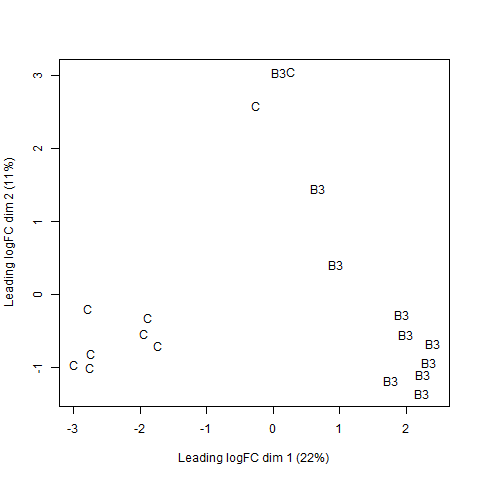

In [224]:
%%R
plotMDS(de_exp_table, labels = ann_sel$Histology)

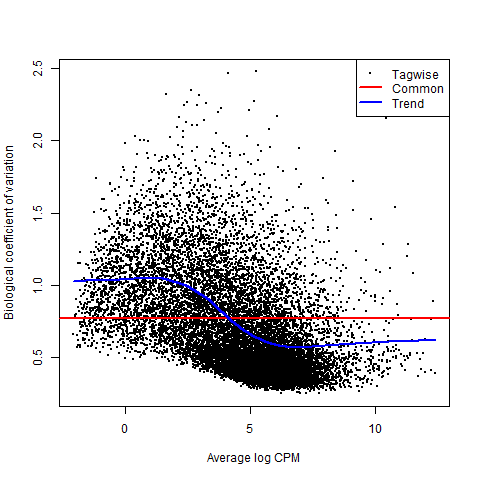

In [225]:
%%R
de_exp_table <- estimateDisp(de_exp_table, design, robust=TRUE)
plotBCV(de_exp_table)

In [226]:
%%R
fit <- glmFit(de_exp_table, design)
lrt <- glmLRT(fit)
topTags(lrt)

Coefficient:  HistologyC 
              logFC   logCPM       LR       PValue          FDR
KIAA1549L  8.307304 5.254282 91.66978 1.024171e-21 1.480849e-17
PSMB11    -8.787536 6.858270 74.78381 5.251861e-18 3.796833e-14
RAB27B     3.866962 4.524827 70.11364 5.598445e-17 2.698264e-13
CREB3L1    5.394486 5.417161 61.05300 5.555884e-15 2.008313e-11
FGD5       4.126681 6.263518 58.95907 1.609861e-14 4.655395e-11
NPTX1     -6.855760 8.247599 56.12581 6.797887e-14 1.606997e-10
CLEC1A    -5.030796 6.128204 55.86052 7.779916e-14 1.606997e-10
COX7A1    -4.954854 6.984693 55.35002 1.008687e-13 1.823076e-10
SULF1      3.487214 6.620966 53.63057 2.419652e-13 3.887305e-10
CCL20      7.870004 6.322493 53.22522 2.974163e-13 4.300342e-10


In [227]:
%%R
colnames(design)

[1] "(Intercept)" "HistologyC" 


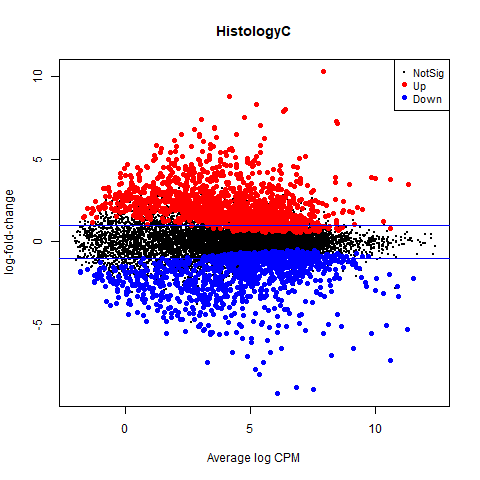

In [228]:
%%R
plotMD(lrt)
abline(h=c(-1, 1), col="blue")

### B1 Histology

In [566]:
hist_b1 = ann[(ann['Histology'] == 'B1') | (ann['Histology'] == 'B3')]
expr_hist_b1 = expr[hist_b1.index]

In [567]:
%%R -i hist_b1
hist_b1$Histology <- factor(hist_b1$Histology, levels=c('B3','B1'))
hist_b1$Histology <- relevel(hist_b1$Histology, ref="B3")
print(hist_b1$Histology)

 [1] B3 B1 B1 B3 B1 B1 B1 B1 B1 B1 B3 B3 B1 B1 B1 B3 B3 B3 B1 B3 B1 B3 B3 B1
Levels: B3 B1


In [568]:
%%R
desingb1 <- model.matrix(~Histology, data=hist_b1) 
head(desingb1)

                 (Intercept) HistologyB1
TCGA-ZB-A96L-01A           1           0
TCGA-X7-A8DD-01A           1           1
TCGA-3G-AB0O-01A           1           1
TCGA-XU-A931-01A           1           0
TCGA-3T-AA9L-01A           1           1
TCGA-3S-AAYX-01A           1           1


In [569]:
%%R -i expr_hist_b1
de_expb1 <- DGEList(expr_hist_b1, group = hist_b1$Histology)
dim(desingb1)

[1] 24  2


In [571]:
%%R
b1 <- filterByExpr(de_expb1, desingb1)
b1_table <- de_expb1[b1, keep.lib.sizes=FALSE]
dim(b1_table)

[1] 14237    24


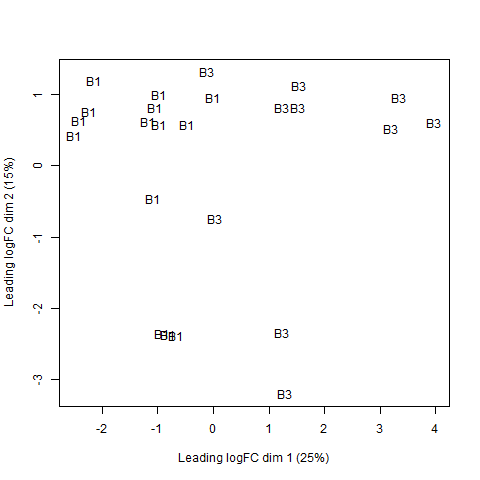

In [574]:
%%R
de_expb1 <- calcNormFactors(b1_table)
plotMDS(b1_table, labels = hist_b1$Histology)

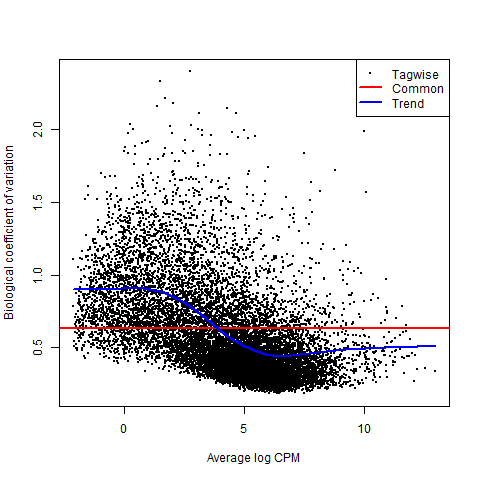

In [575]:
%%R
de_expb1 <- estimateDisp(de_expb1, desingb1, robust=TRUE)
plotBCV(de_expb1)

In [576]:
%%R
fitb1 <- glmFit(de_expb1, desingb1)
lrt_b1 <- glmLRT(fitb1)
topTags(lrt_b1)

Coefficient:  HistologyB1 
           logFC   logCPM       LR       PValue          FDR
FBXO27 -2.859050 3.807315 99.21726 2.262663e-23 3.221353e-19
CYFIP1 -1.783690 6.347683 97.08207 6.651237e-23 4.734683e-19
FBLN5   2.715395 6.127684 94.74345 2.167295e-22 1.028526e-18
PAX9   -2.143619 7.260301 88.99169 3.964748e-21 1.411153e-17
CPLX1   3.279774 4.874595 80.45859 2.968607e-19 8.434696e-16
GNA11  -1.515024 6.484694 80.10257 3.554694e-19 8.434696e-16
HDAC7   2.022602 8.962549 78.94259 6.394127e-19 1.300474e-15
IL10RB  1.146544 6.075523 78.48932 8.043188e-19 1.431386e-15
CD4     2.511438 9.016624 76.26367 2.482081e-18 3.926376e-15
SNAI2  -1.933919 4.680470 75.00693 4.690640e-18 6.678064e-15


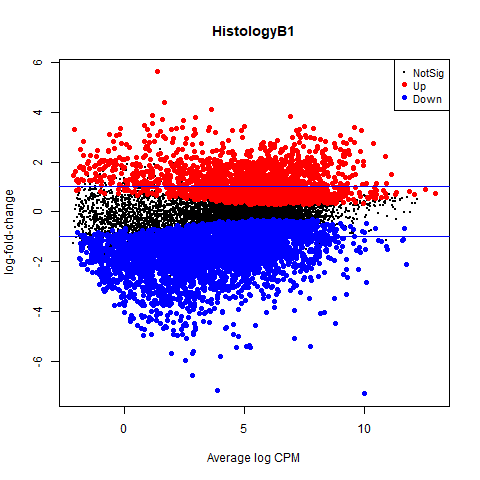

In [579]:
%%R
colnames(desingb1)
plotMD(lrt_b1)
abline(h=c(-1, 1), col="blue")

### Histology A

In [580]:
hist_a = ann[(ann['Histology'] == 'A') | (ann['Histology'] == 'B3')]
expr_hist_a = expr[hist_a.index]

In [585]:
%%R -i hist_a
hist_a$Histology <- factor(hist_a$Histology, levels=c('B3','A'))
hist_a$Histology <- relevel(hist_a$Histology, ref="B3")
print(hist_a$Histology)

 [1] A  A  B3 A  B3 A  A  A  B3 B3 A  A  A  A  A  B3 A  A  B3 B3 B3 B3 B3 A 
Levels: B3 A


In [586]:
%%R
desinga <- model.matrix(~Histology, data=hist_a) 
head(desinga)

                 (Intercept) HistologyA
TCGA-ZB-A96H-01A           1          1
TCGA-ZB-A964-01A           1          1
TCGA-ZB-A96L-01A           1          0
TCGA-ZB-A961-01A           1          1
TCGA-XU-A931-01A           1          0
TCGA-XM-A8R9-01A           1          1


In [587]:
%%R -i expr_hist_a
de_expa <- DGEList(expr_hist_a, group = hist_b1$Histology)
dim(desinga)

[1] 24  2


In [590]:
%%R
a <- filterByExpr(de_expa, desinga)
a_table <- de_expa[a, keep.lib.sizes=FALSE]
dim(a_table)

[1] 14474    24


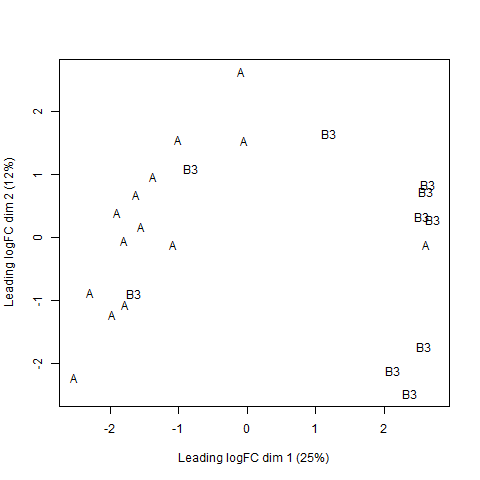

In [591]:
%%R
de_expa <- calcNormFactors(a_table)
plotMDS(a_table, labels = hist_a$Histology)

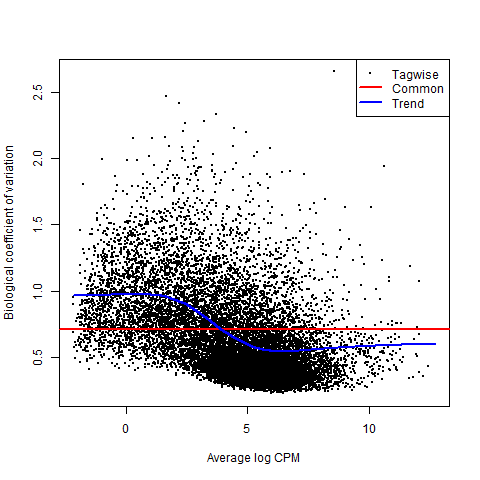

In [592]:
%%R
de_expa <- estimateDisp(de_expa, desinga, robust=TRUE)
plotBCV(de_expa)

In [593]:
%%R
fita <- glmFit(de_expa, desinga)
lrt_a <- glmLRT(fita)
topTags(lrt_a)

Coefficient:  HistologyA 
            logFC   logCPM       LR       PValue          FDR
CYP3A4  -6.338293 3.614543 69.42674 7.930616e-17 1.147877e-12
PTGES   -5.121537 4.763645 57.87453 2.793817e-14 2.021886e-10
SYT7    -4.736577 3.615771 56.17308 6.636391e-14 3.201838e-10
CHGB    -7.524088 8.808141 49.40031 2.087125e-12 6.442956e-09
TRIM67  -5.499423 1.627554 49.22576 2.281349e-12 6.442956e-09
CYP4F3  -8.030265 3.956254 48.91658 2.670840e-12 6.442956e-09
PLEKHD1 -5.916716 4.593253 47.33021 5.998067e-12 1.240229e-08
VAV3    -3.443852 5.213504 46.39759 9.653427e-12 1.746546e-08
RHBDL1  -3.875451 5.064731 43.10417 5.190139e-11 8.346896e-08
TDRD12  -5.655702 3.453837 42.59724 6.725413e-11 9.734363e-08


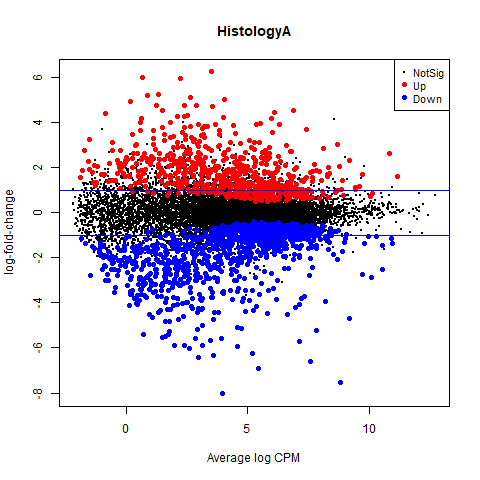

In [594]:
%%R
colnames(desinga)
plotMD(lrt_a)
abline(h=c(-1, 1), col="blue")

### Histology B2

In [596]:
hist_b2 = ann[(ann['Histology'] == 'B2') | (ann['Histology'] == 'B3')]
expr_hist_b2 = expr[hist_b2.index]

In [597]:
%%R -i hist_b2
hist_b2$Histology <- factor(hist_b2$Histology, levels=c('B3','B2'))
hist_b2$Histology <- relevel(hist_b2$Histology, ref="B3")
print(hist_b2$Histology)

 [1] B3 B2 B2 B3 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B3 B3 B2 B2 B2 B2 B2 B2 B2 B3 B3
[26] B2 B3 B2 B2 B2 B2 B2 B3 B3 B3 B2 B2
Levels: B3 B2


In [598]:
%%R
desing_b2 <- model.matrix(~Histology, data=hist_b2) 
head(desing_b2)

                 (Intercept) HistologyB2
TCGA-ZB-A96L-01A           1           0
TCGA-4V-A9QS-01A           1           1
TCGA-4V-A9QI-01A           1           1
TCGA-XU-A931-01A           1           0
TCGA-XM-A8RI-01A           1           1
TCGA-X7-A8DG-01A           1           1


In [599]:
%%R -i expr_hist_b2
de_expb2 <- DGEList(expr_hist_b2, group = hist_b2$Histology)
dim(desing_b2)

[1] 37  2


In [600]:
%%R
b2 <- filterByExpr(de_expb2, desing_b2)
b2_table <- de_expb2[b2, keep.lib.sizes=FALSE]
dim(b2_table)

[1] 14698    37


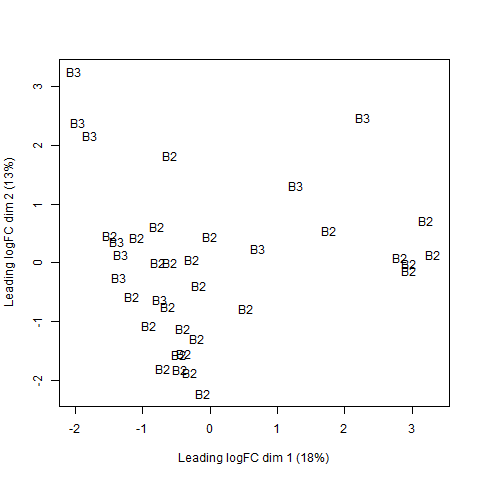

In [608]:
%%R
de_expb2 <- calcNormFactors(b2_table)
plotMDS(b2_table, labels = hist_b2$Histology)

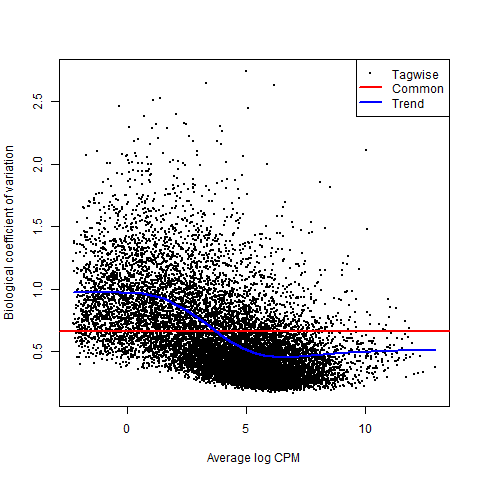

In [609]:
%%R
de_expb2 <- estimateDisp(de_expb2, desing_b2, robust=TRUE)
plotBCV(de_expb2)

In [610]:
%%R
fitb2 <- glmFit(de_expb2, desing_b2)
lrt_b2 <- glmLRT(fitb2)
topTags(lrt_b2)

Coefficient:  HistologyB2 
           logFC     logCPM       LR       PValue          FDR
PRR15L -4.579139  1.3051046 72.46720 1.698311e-17 2.496177e-13
FUT1   -2.772961  3.1099514 70.37820 4.895790e-17 3.597916e-13
KRT36  -6.885006  4.5645281 68.03036 1.609975e-16 7.887802e-13
IZUMO1 -3.340244 -0.7773621 64.80827 8.255195e-16 3.033371e-12
CYP3A7 -5.018536  1.5011992 61.96267 3.500301e-15 1.028948e-11
WWC1   -3.426502  3.7122279 60.58194 7.057842e-15 1.728936e-11
RHPN2  -2.141581  2.6158380 51.82963 6.053130e-13 1.270984e-09
IL1RN  -3.652724  2.6166356 50.23588 1.363319e-12 2.504758e-09
GPRC5D -3.562615  0.4150738 49.33035 2.162907e-12 2.974901e-09
FBXO27 -2.054440  3.6950906 49.31985 2.174515e-12 2.974901e-09


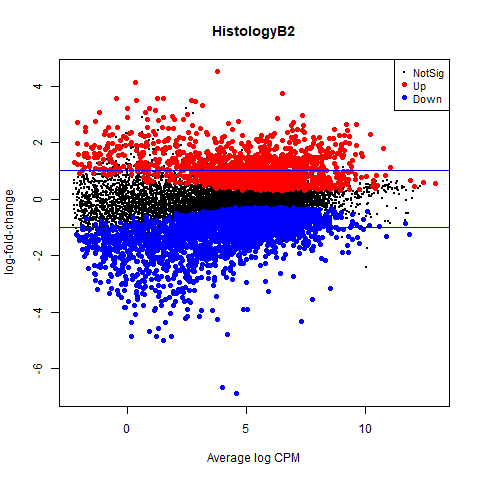

In [611]:
%%R
colnames(desing_b2)
plotMD(lrt_b2)
abline(h=c(-1, 1), col="blue")

### Histology Ab

In [612]:
hist_ab = ann[(ann['Histology'] == 'Ab') | (ann['Histology'] == 'B3')]
expr_hist_ab = expr[hist_ab.index]

In [613]:
%%R -i hist_ab
hist_ab$Histology <- factor(hist_ab$Histology, levels=c('B3','Ab'))
hist_ab$Histology <- relevel(hist_ab$Histology, ref="B3")
print(hist_ab$Histology)

 [1] Ab Ab Ab B3 Ab Ab Ab B3 Ab Ab Ab Ab Ab Ab Ab Ab Ab Ab Ab Ab Ab B3 B3 Ab Ab
[26] Ab Ab Ab Ab Ab B3 B3 Ab Ab B3 Ab Ab Ab Ab Ab Ab B3 Ab B3 B3
Levels: B3 Ab


In [614]:
%%R
desing_ab <- model.matrix(~Histology, data=hist_ab) 
head(desing_ab)

                 (Intercept) HistologyAb
TCGA-4V-A9QL-01A           1           1
TCGA-XH-A853-01A           1           1
TCGA-4V-A9QU-01A           1           1
TCGA-ZB-A96L-01A           1           0
TCGA-4X-A9FC-01A           1           1
TCGA-4V-A9QM-01A           1           1


In [615]:
%%R -i expr_hist_ab
de_expab <- DGEList(expr_hist_ab, group = hist_ab$Histology)
dim(desing_ab)

[1] 45  2


In [616]:
%%R
ab <- filterByExpr(de_expab, desing_ab)
ab_table <- de_expab[ab, keep.lib.sizes=FALSE]
dim(ab_table)

[1] 14907    45


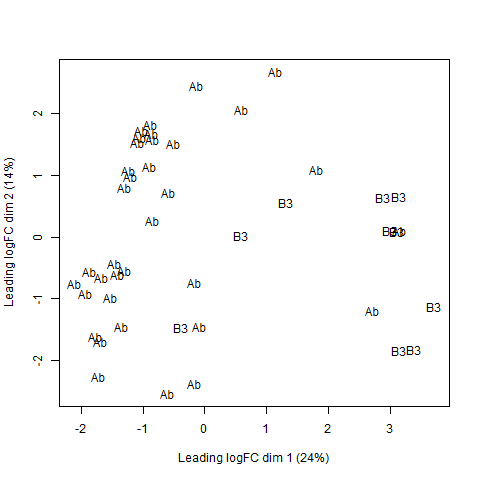

In [617]:
%%R
de_expab <- calcNormFactors(ab_table)
plotMDS(ab_table, labels = hist_ab$Histology)

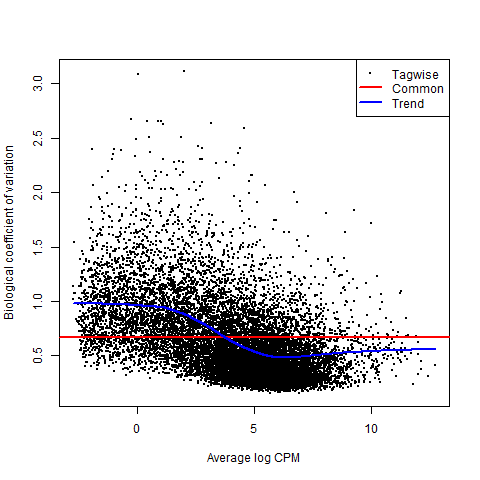

In [618]:
%%R
de_expab<- estimateDisp(de_expab, desing_ab, robust=TRUE)
plotBCV(de_expab)

In [619]:
%%R
fitab <- glmFit(de_expab, desing_ab)
lrt_ab <- glmLRT(fitab)
topTags(lrt_ab)

Coefficient:  HistologyAb 
            logFC   logCPM        LR       PValue          FDR
GPX2    -7.012417 3.686736 168.37868 1.672205e-38 2.492756e-34
AHNAK2  -4.628409 4.555563 117.54437 2.181641e-27 1.626086e-23
CYP3A7  -5.604871 1.197018 113.70040 1.515623e-26 7.531131e-23
CYP4F3  -7.265412 3.070422 110.32532 8.315963e-26 3.099152e-22
CEL     -4.236144 4.050028 106.32425 6.260555e-25 1.866522e-21
CCDC171 -2.541478 4.694865 105.51147 9.434996e-25 2.344125e-21
CYP3A5  -4.518775 2.377183 101.98880 5.583665e-24 1.189081e-20
CFAP45  -3.720458 1.679565 100.29987 1.309851e-23 2.440744e-20
IL1RN   -4.602237 2.270137  94.30233 2.708314e-22 4.485872e-19
RHCE    -3.307282 1.013908  93.10319 4.963777e-22 7.399503e-19


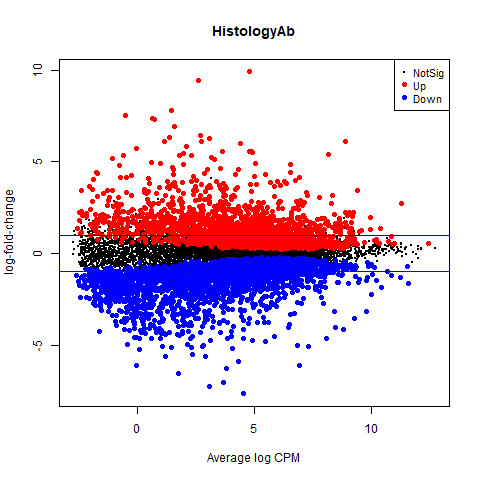

In [620]:
%%R
colnames(desing_ab)
plotMD(lrt_ab)
abline(h=c(-1, 1), col="blue")

### Histology B1

In [539]:
ann['Histology'].value_counts()

Histology
Ab    35
B2    27
A     14
B1    14
B3    10
C      9
Name: count, dtype: int64

In [630]:
hist_b1 = ann[(ann['Histology'] == 'B1') | (ann['Histology'] == 'B3')]
expr_hist_b1 = expr[hist_b1.index]

In [631]:
%%R -i hist_b1
hist_b1$Histology <- factor(hist_b1$Histology, levels=c('B3','B1'))
hist_b1$Histology <- relevel(hist_b1$Histology, ref="B3")
print(hist_b1$Histology)

 [1] B3 B1 B1 B3 B1 B1 B1 B1 B1 B1 B3 B3 B1 B1 B1 B3 B3 B3 B1 B3 B1 B3 B3 B1
Levels: B3 B1


In [632]:
%%R
desing_b1 <- model.matrix(~Histology, data=hist_b1) 
head(desing_b1)

                 (Intercept) HistologyB1
TCGA-ZB-A96L-01A           1           0
TCGA-X7-A8DD-01A           1           1
TCGA-3G-AB0O-01A           1           1
TCGA-XU-A931-01A           1           0
TCGA-3T-AA9L-01A           1           1
TCGA-3S-AAYX-01A           1           1


In [633]:
%%R -i expr_hist_b1
de_expb1 <- DGEList(expr_hist_b1, group = hist_b1$Histology)
dim(desing_b1)

[1] 24  2


In [635]:
%%R
b1 <- filterByExpr(de_expb1, desing_b1)
b1_table <- de_expb1[b1, keep.lib.sizes=FALSE]
dim(b1_table)

[1] 14237    24


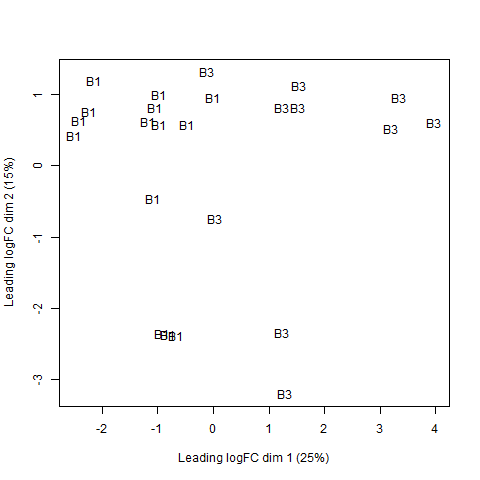

In [636]:
%%R
de_expb1 <- calcNormFactors(b1_table)
plotMDS(b1_table, labels = hist_b1$Histology)

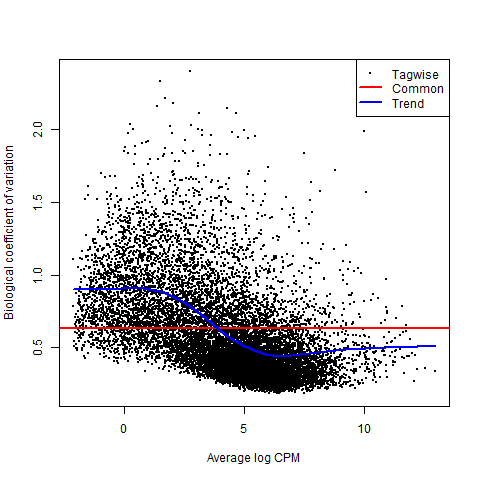

In [637]:
%%R
de_expb1<- estimateDisp(de_expb1, desing_b1, robust=TRUE)
plotBCV(de_expb1)

In [638]:
%%R
fitb1 <- glmFit(de_expb1, desing_b1)
lrt_b1 <- glmLRT(fitb1)
topTags(lrt_b1)

Coefficient:  HistologyB1 
           logFC   logCPM       LR       PValue          FDR
FBXO27 -2.859050 3.807315 99.21726 2.262663e-23 3.221353e-19
CYFIP1 -1.783690 6.347683 97.08207 6.651237e-23 4.734683e-19
FBLN5   2.715395 6.127684 94.74345 2.167295e-22 1.028526e-18
PAX9   -2.143619 7.260301 88.99169 3.964748e-21 1.411153e-17
CPLX1   3.279774 4.874595 80.45859 2.968607e-19 8.434696e-16
GNA11  -1.515024 6.484694 80.10257 3.554694e-19 8.434696e-16
HDAC7   2.022602 8.962549 78.94259 6.394127e-19 1.300474e-15
IL10RB  1.146544 6.075523 78.48932 8.043188e-19 1.431386e-15
CD4     2.511438 9.016624 76.26367 2.482081e-18 3.926376e-15
SNAI2  -1.933919 4.680470 75.00693 4.690640e-18 6.678064e-15


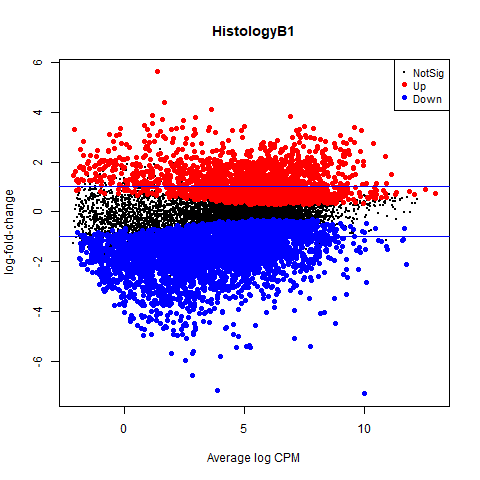

In [639]:
%%R
colnames(desing_b1)
plotMD(lrt_b1)
abline(h=c(-1, 1), col="blue")

## DESeq2

In [697]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B3")
condition <- ann$Histology

In [642]:
'''%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")'''

'%%R\nif (!requireNamespace("BiocManager", quietly = TRUE))\n    install.packages("BiocManager")\nBiocManager::install("DESeq2")'

In [698]:
%%R -i expr
library(DESeq2)
pats <- rownames(ann)#colnames(expr_matrix)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
print(dds)

class: DESeqDataSet 
dim: 17752 109 
metadata(1): version
assays(1): counts
rownames(17752): MARC1 KDM3A ... VRK3 C19orf44
rowData names(0):
colnames(109): TCGA-4V-A9QL-01A TCGA-ZB-A96H-01A ... TCGA-3G-AB14-01A
  TCGA-ZB-A966-01A
colData names(1): condition


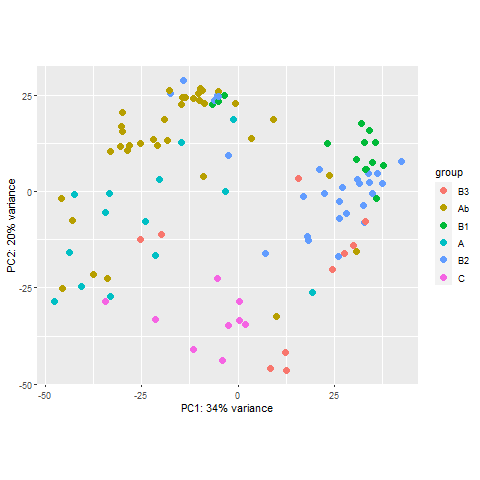

In [700]:
%%R

vsdata = vst(dds, blind = FALSE)
plotPCA(vsdata, intgroup = 'condition')

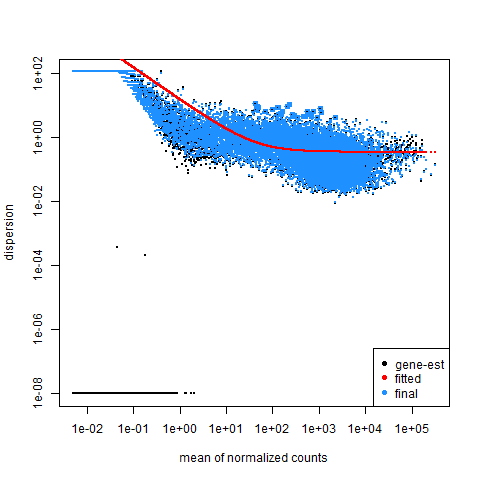

o{'rect': o{'w': [1.63702541], 'h': [1.79675532], 'left': [4.17307323], 'top': [-6.60474174], }, 'text': o{'x': [4.63833308 4.63833308 4.63833308], 'y': [-7.05393057 -7.5031194  -7.95230823], }, }

In [241]:
%R plotDispEsts(dds)

## C vs B3

In [703]:
%%R -o deseq_res_c_b3
res_c_b3 <- results(dds, contrast = c("condition", 'C', 'B3'))
deseq_res_c_b3 <- as.data.frame(res_c_b3)
head(res_c_b3)

log2 fold change (MLE): condition C vs B3 
Wald test p-value: condition C vs B3 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat    pvalue      padj
       <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
MARC1    482.027      0.0877508  0.499940  0.175523 0.8606691 0.9313965
KDM3A   2923.994      0.4931592  0.208043  2.370465 0.0177657 0.0579018
LRRC61  1998.942      0.6155390  0.359203  1.713626 0.0865975 0.1910919
DONSON   858.024     -0.3821865  0.205684 -1.858121 0.0631519 0.1515327
ADI1    4228.549     -0.3792231  0.208975 -1.814679 0.0695733 0.1625645
HCST    1342.986     -0.9240380  0.603535 -1.531043 0.1257587 0.2504111


In [704]:
deseq_res_c_b3

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
MARC1      482.026716        0.087751  0.499940  0.175523  0.860669  0.931397
KDM3A     2923.993604        0.493159  0.208043  2.370465  0.017766  0.057902
LRRC61    1998.942211        0.615539  0.359203  1.713626  0.086598  0.191092
DONSON     858.023742       -0.382187  0.205684 -1.858121  0.063152  0.151533
ADI1      4228.548803       -0.379223  0.208975 -1.814679  0.069573  0.162564
...               ...             ...       ...       ...       ...       ...
FUT3        32.076381        2.869528  0.880978  3.257207  0.001125  0.006460
MGRN1     3369.742763        0.412265  0.120171  3.430651  0.000602  0.003881
AQP1      4957.311003       -0.228901  0.466532 -0.490643  0.623679  0.764739
VRK3      3038.705820       -0.423712  0.279131 -1.517970  0.129022  0.254814
C19orf44   818.425284       -0.014715  0.206055 -0.071411  0.943070  0.975332

[17752 rows x 6 columns]

In [719]:
deseq_res_c_b3= deseq_res_c_b3.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res_c_b3['padj']< 0.01]
deseq_res_c_b3

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
MYBPC1   1864.730093       10.328908  0.927451  11.136875  8.298046e-29   
IGF2BP3   140.930720        9.658944  0.689890  14.000705  1.543322e-44   
LBX1       39.643835        9.554854  1.712337   5.580007  2.405083e-08   
SOX14     208.706853        9.162113  1.979487   4.628528  3.682738e-06   
NEUROG2    15.481781        8.982190  1.480477   6.067092  1.302471e-09   
...              ...             ...       ...        ...           ...   
PSMB11   6115.048539       -8.790501  0.689068 -12.757086  2.846530e-37   
NEFL     6219.818255       -8.908805  1.231121  -7.236336  4.609679e-13   
SALL3      21.810127       -9.039222  1.661970  -5.438859  5.362301e-08   
NEFM     1770.829739       -9.176830  1.238470  -7.409814  1.264770e-13   
CFC1      148.280851      -10.609055  1.279685  -8.290365  1.129018e-16   

                 padj  
MYBPC1   2.039186e-25  
IGF2BP3  2.654822e-40  
LBX1     7.910563e-07  
SOX14    5.616175e-05  
NEUROG2  6.293569e-08  
...               ...  
PSMB11   1.632200e-33  
NEFL     5.394265e-11  
SALL3    1.558147e-06  
NEFM     1.648226e-11  
CFC1     3.291758e-14  

[3311 rows x 6 columns]

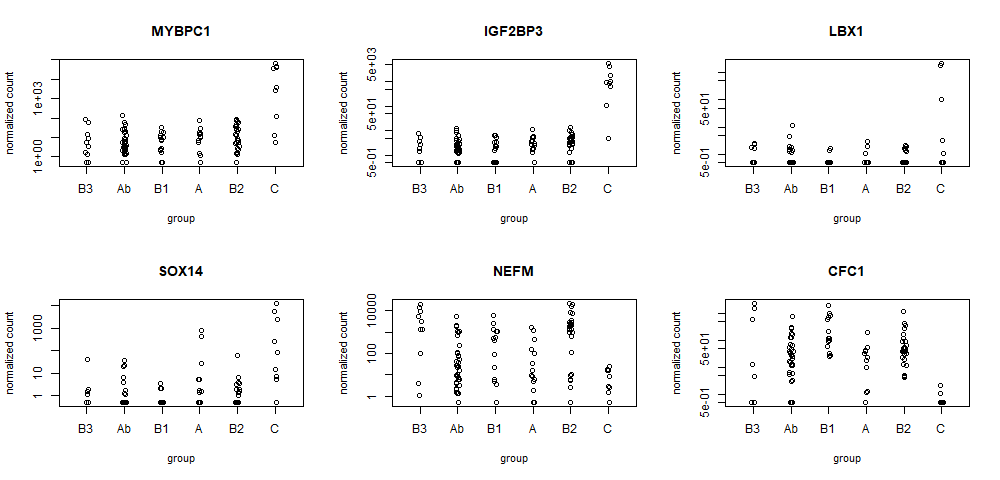

In [706]:
%%R -w 1000
#Задаём размер текста и композицию графика
par(mfrow=c(2,3), cex=1.0, cex.main=1.2, cex.axis=1, cex.lab=0.9)

plotCounts(dds, gene="MYBPC1", intgroup="condition")
plotCounts(dds, gene="IGF2BP3", intgroup="condition")
plotCounts(dds, gene="LBX1", intgroup="condition")
plotCounts(dds, gene="SOX14", intgroup="condition")
plotCounts(dds, gene="NEFM", intgroup="condition") # down
plotCounts(dds, gene="CFC1", intgroup="condition") #down

In [709]:
%%R
head(deseq_res_c_b3)

        baseMean log2FoldChange     lfcSE       stat     pvalue      padj
MARC1   482.0267     0.08775078 0.4999402  0.1755225 0.86066906 0.9313965
KDM3A  2923.9936     0.49315918 0.2080432  2.3704654 0.01776571 0.0579018
LRRC61 1998.9422     0.61553904 0.3592028  1.7136255 0.08659752 0.1910919
DONSON  858.0237    -0.38218651 0.2056844 -1.8581208 0.06315186 0.1515327
ADI1   4228.5488    -0.37922313 0.2089753 -1.8146788 0.06957328 0.1625645
HCST   1342.9862    -0.92403802 0.6035349 -1.5310432 0.12575872 0.2504111


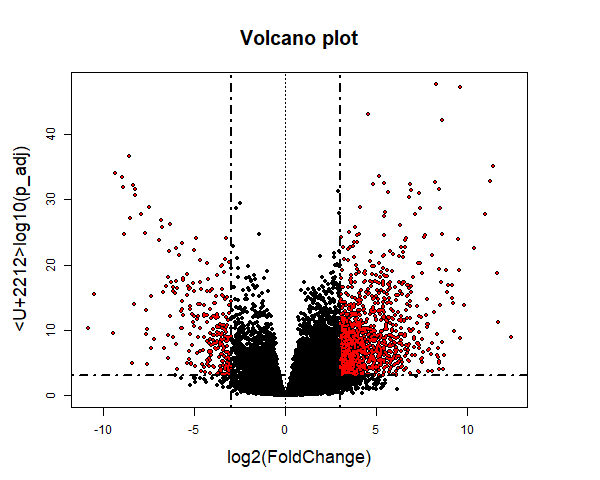

In [708]:
%%R -w 600

#Задаём размер текста и композицию графика
par(mar=c(5,5,5,5), cex=1.0, cex.main=1.7, cex.axis=1, cex.lab=1.5)

#Отрисовываем все точки чёрным цветом
with(res, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab="log2(FoldChange)", ylab="−log10(p_adj)"))

#Отрисовываем точки, прошедшие порог, красным цветом
with(subset(res, padj<0.001 & abs(log2FoldChange)>3), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))

#Отрисовываем линии с порогами
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-3, col="black", lty=4, lwd=2.0)
abline(v=3, col="black", lty=4, lwd=2.0)
abline(h=3, col="black", lty=4, lwd=2.0)

In [710]:
deseq_res_c_b3.shape

(3311, 6)

## Сравнение B1 с B3

In [717]:
%%R -o deseq_res_b1_b3
res_b1_b3 <- results(dds, contrast = c("condition", 'B1', 'B3'))
deseq_res_b1_b3 <- as.data.frame(res_b1_b3)
head(res_b1_b3)

log2 fold change (MLE): condition B1 vs B3 
Wald test p-value: condition B1 vs B3 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue        padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
MARC1    482.027      -2.852664  0.451842  -6.31341 2.72950e-10 1.49431e-08
KDM3A   2923.994       0.470408  0.187502   2.50882 1.21135e-02 2.97102e-02
LRRC61  1998.942       1.250880  0.323669   3.86468 1.11233e-04 5.67505e-04
DONSON   858.024       0.479293  0.185081   2.58964 9.60757e-03 2.44791e-02
ADI1    4228.549      -1.027947  0.188363  -5.45725 4.83565e-08 9.44828e-07
HCST    1342.986       0.909616  0.543673   1.67309 9.43089e-02 1.63554e-01


In [718]:
deseq_res_b1_b3 = deseq_res_b1_b3.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res_b1_b3['padj']< 0.01]
deseq_res_b1_b3

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NMUR2    154.211987        9.661166  1.443942  6.690826  2.219148e-11   
SOHLH1  1058.243101        9.554979  1.739252  5.493729  3.935337e-08   
SOX1      62.302686        5.881958  1.530087  3.844199  1.209469e-04   
HTR5A     54.698146        5.664512  1.223190  4.630935  3.640176e-06   
DBX2      38.549066        5.543622  1.480006  3.745676  1.799086e-04   
...             ...             ...       ...       ...           ...   
ADH7      51.381056       -7.368019  1.156070 -6.373331  1.849660e-10   
SALL3     21.810127       -7.754374  1.461750 -5.304858  1.127608e-07   
FIBCD1   111.784705       -7.776513  1.361486 -5.711781  1.117996e-08   
CAPNS2    73.462738       -8.033854  1.059376 -7.583575  3.361602e-14   
HOXA13    17.693869       -9.302525  1.292114 -7.199462  6.045055e-13   

                padj  
NMUR2   2.044769e-09  
SOHLH1  8.023900e-07  
SOX1    6.096880e-04  
HTR5A   3.217117e-05  
DBX2    8.526191e-04  
...              ...  
ADH7    1.064470e-08  
SALL3   1.884396e-06  
FIBCD1  2.992325e-07  
CAPNS2  1.242049e-11  
HOXA13  1.274146e-10  

[5603 rows x 6 columns]

## Сравнение B2 с B3

In [721]:
%%R -o deseq_res_b2_b3
res_b2_b3 <- results(dds, contrast = c("condition", 'B2', 'B3'))
deseq_res_b2_b3 <- as.data.frame(res_b2_b3)
head(res_b2_b3)

log2 fold change (MLE): condition B2 vs B3 
Wald test p-value: condition B2 vs B3 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue        padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
MARC1    482.027      -1.620705  0.403088  -4.02072 5.80208e-05 8.45570e-04
KDM3A   2923.994       0.237337  0.167669   1.41551 1.56920e-01 2.97150e-01
LRRC61  1998.942       0.927512  0.289439   3.20452 1.35286e-03 8.91939e-03
DONSON   858.024       0.264396  0.165554   1.59704 1.10257e-01 2.31176e-01
ADI1    4228.549      -0.807601  0.168383  -4.79622 1.61691e-06 6.28577e-05
HCST    1342.986       0.626238  0.486116   1.28825 1.97660e-01 3.50149e-01


In [722]:
deseq_res_b2_b3 = deseq_res_b2_b3.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res_b2_b3['padj']< 0.01]
deseq_res_b2_b3

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
SOHLH1     1058.243101        8.590795  1.563817  5.493478  3.940949e-08   
SERPINB12   126.427224        7.347674  1.696006  4.332341  1.475323e-05   
DBX2         38.549066        5.567924  1.351968  4.118383  3.815401e-05   
SOX1         62.302686        4.579300  1.393914  3.285211  1.019061e-03   
HTR5A        54.698146        4.175874  1.098831  3.800289  1.445274e-04   
...                ...             ...       ...       ...           ...   
KRT36       429.272485       -6.898278  0.732737 -9.414398  4.758006e-21   
CAPNS2       73.462738       -7.379505  0.932223 -7.916026  2.452222e-15   
CYP4F8       31.616417       -7.554197  1.119863 -6.745642  1.523516e-11   
HOXB13       69.545677       -7.717160  1.397800 -5.520931  3.372078e-08   
HOXA13       17.693869       -7.964484  1.099223 -7.245556  4.306673e-13   

                   padj  
SOHLH1     4.255710e-06  
SERPINB12  3.219986e-04  
DBX2       6.335483e-04  
SOX1       7.288709e-03  
HTR5A      1.635535e-03  
...                 ...  
KRT36      7.861178e-17  
CAPNS2     6.752602e-12  
CYP4F8     1.048814e-08  
HOXB13     3.782801e-06  
HOXA13     5.473450e-10  

[2599 rows x 6 columns]

## Сравнение Ab с B3

In [723]:
%%R -o deseq_res_ab_b3
res_ab_b3 <- results(dds, contrast = c("condition", 'Ab', 'B3'))
deseq_res_ab_b3 <- as.data.frame(res_ab_b3)
head(res_ab_b3)

log2 fold change (MLE): condition Ab vs B3 
Wald test p-value: condition Ab vs B3 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue        padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
MARC1    482.027     -0.7939358  0.390234 -2.034510 4.19002e-02 1.02647e-01
KDM3A   2923.994      0.3100841  0.162396  1.909430 5.62066e-02 1.28859e-01
LRRC61  1998.942      0.9473418  0.280356  3.379065 7.27327e-04 4.08705e-03
DONSON   858.024     -0.0653322  0.160383 -0.407351 6.83750e-01 7.90334e-01
ADI1    4228.549     -0.8987753  0.163090 -5.510914 3.56976e-08 1.17826e-06
HCST    1342.986      0.1353952  0.470875  0.287540 7.73699e-01 8.56494e-01


In [724]:
deseq_res_ab_b3 = deseq_res_ab_b3.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res_ab_b3['padj']< 0.01]
deseq_res_ab_b3

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
SOHLH1     1058.243101        9.944849  1.517488   6.553494  5.620611e-11   
SERPINB12   126.427224        9.786609  1.650013   5.931231  3.006724e-09   
SOX1         62.302686        8.010654  1.355924   5.907895  3.465070e-09   
LRRTM1       40.007105        7.765564  1.305896   5.946541  2.738684e-09   
DBX2         38.549066        7.617575  1.317488   5.781894  7.386424e-09   
...                ...             ...       ...        ...           ...   
IVL          17.072458       -7.823254  1.286978  -6.078778  1.211023e-09   
CAPNS2       73.462738       -9.043865  0.916938  -9.863119  6.015128e-23   
SPRR1A       15.061946       -9.289757  1.395903  -6.655014  2.832734e-11   
CYP4F8       31.616417       -9.616772  1.114296  -8.630355  6.116173e-18   
LY6D        297.126487      -11.913495  1.183090 -10.069812  7.512128e-24   

                   padj  
SOHLH1     5.960675e-09  
SERPINB12  1.517945e-07  
SOX1       1.698488e-07  
LRRTM1     1.403638e-07  
DBX2       3.177293e-07  
...                 ...  
IVL        7.165004e-08  
CAPNS2     2.535677e-19  
SPRR1A     3.227403e-09  
CYP4F8     6.445682e-15  
LY6D       7.797391e-20  

[3710 rows x 6 columns]

## Сравнение A с B3

In [725]:
%%R -o deseq_res_a_b3
res_a_b3 <- results(dds, contrast = c("condition", 'A', 'B3'))
deseq_res_a_b3 <- as.data.frame(res_a_b3)
head(res_a_b3)

log2 fold change (MLE): condition A vs B3 
Wald test p-value: condition A vs B3 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue        padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
MARC1    482.027     -0.4478687  0.450609 -0.993919 3.20262e-01 0.536259958
KDM3A   2923.994      0.0720662  0.187535  0.384282 7.00770e-01 0.850655547
LRRC61  1998.942      0.5769583  0.323719  1.782281 7.47034e-02 0.206719701
DONSON   858.024     -0.8045107  0.185569 -4.335381 1.45508e-05 0.000380295
ADI1    4228.549     -0.7795239  0.188339 -4.138951 3.48898e-05 0.000738549
HCST    1342.986     -0.0664120  0.543737 -0.122140 9.02788e-01 0.965283353


In [726]:
deseq_res_a_b3 = deseq_res_a_b3.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res_a_b3['padj']< 0.01]
deseq_res_a_b3

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
SOHLH1   1058.243101       10.588814  1.739230  6.088221  1.141725e-09   
LRRTM1     40.007105        7.695296  1.463747  5.257259  1.462183e-07   
SOX1       62.302686        6.551973  1.529456  4.283858  1.836803e-05   
CYP26A1   125.906522        6.403821  0.937195  6.832964  8.317769e-12   
TRIM48      4.247974        6.381004  1.348394  4.732299  2.219916e-06   
...              ...             ...       ...       ...           ...   
CAPNS2     73.462738       -9.560361  1.104328 -8.657172  4.836144e-18   
CYP2C9     24.893236       -9.732422  1.298875 -7.492962  6.733624e-14   
IVL        17.072458      -10.111600  1.545367 -6.543171  6.022793e-11   
UGT2B7    158.004007      -10.361830  1.584577 -6.539179  6.185744e-11   
LY6D      297.126487      -12.390454  1.419811 -8.726833  2.619024e-18   

                 padj  
SOHLH1   2.324416e-07  
LRRTM1   1.039359e-05  
SOX1     4.488166e-04  
CYP26A1  4.615557e-09  
TRIM48   8.791407e-05  
...               ...  
CAPNS2   2.773045e-14  
CYP2C9   1.188207e-10  
IVL      2.252263e-08  
UGT2B7   2.263982e-08  
LY6D     2.252623e-14  

[1874 rows x 6 columns]

# Determine intersected genes between tools

In [249]:
edger_res.head()

logFC    logCPM          LR         PValue           FDR
MYBPC1   10.347603  5.423698  453.868285  1.038192e-100  1.611274e-96
IGF2BP3   9.574630  1.714077  119.377799   8.656729e-28  2.132578e-25
SOX14     9.221665  2.287420  129.859426   4.398505e-30  1.312784e-27
BARX1     8.932682  0.691321   94.246772   2.785406e-22  4.550474e-20
FOXI1     8.832107  2.145104  119.390053   8.603418e-28  2.132578e-25

In [250]:
deseq_res

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
MYBPC1   1864.730093       10.328908  0.927451  11.136875  8.298046e-29   
IGF2BP3   140.930720        9.658944  0.689890  14.000705  1.543322e-44   
LBX1       39.643835        9.554854  1.712337   5.580007  2.405083e-08   
SOX14     208.706853        9.162113  1.979487   4.628528  3.682738e-06   
NEUROG2    15.481781        8.982190  1.480477   6.067092  1.302471e-09   
...              ...             ...       ...        ...           ...   
PSMB11   6115.048539       -8.790501  0.689068 -12.757086  2.846530e-37   
NEFL     6219.818255       -8.908805  1.231121  -7.236336  4.609679e-13   
SALL3      21.810127       -9.039222  1.661970  -5.438859  5.362301e-08   
NEFM     1770.829739       -9.176830  1.238470  -7.409814  1.264770e-13   
CFC1      148.280851      -10.609055  1.279685  -8.290365  1.129018e-16   

                 padj  
MYBPC1   2.039186e-25  
IGF2BP3  2.654822e-40  
LBX1     7.910563e-07  
SOX14    5.616175e-05  
NEUROG2  6.293569e-08  
...               ...  
PSMB11   1.632200e-33  
NEFL     5.394265e-11  
SALL3    1.558147e-06  
NEFM     1.648226e-11  
CFC1     3.291758e-14  

[3311 rows x 6 columns]

In [251]:
edger_top = edger_res[edger_res['logFC'] > 0].index
edger_down = edger_res[edger_res['logFC'] < 0].index

deseq_top = deseq_res[deseq_res['log2FoldChange'] > 0].index
deseq_down = deseq_res[deseq_res['log2FoldChange'] < 0].index

In [252]:
top_genes = set(edger_top) & set(deseq_top)
len(top_genes)

down_genes = set(edger_down) & set(deseq_down)
len(top_genes)

1023

In [253]:
len(deseq_top)

1860

In [255]:
from matplotlib_venn import venn2

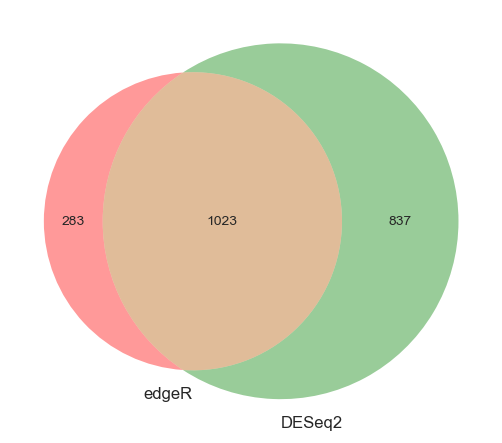

In [256]:
venn2(subsets = (len(edger_top) - len(top_genes), len(deseq_top) - len(top_genes),len(top_genes)),
     set_labels = ('edgeR', 'DESeq2'))

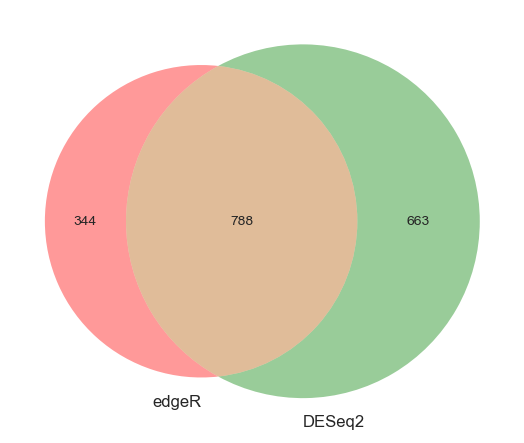

In [257]:
venn2(subsets = (len(edger_down) - len(down_genes), len(deseq_down) - len(down_genes),len(down_genes)),
     set_labels = ('edgeR', 'DESeq2'))

In [258]:
len(edger_down)

1132

In [259]:
len(deseq_down)

1451

# GO

Очень часто после нахождения дифференциально экспрессированных генов делают gene set enrichment analysis (GSEA), чтобы оценить, какие пути сигнальные меняют свою активность в сравнивемых группах.
Для этого есть разные пакеты, здесь используется пакет питоновский gseapy (однако если есть любовь к R, есть gseapy в Bioconductor). На вход нужно подать набор генсетов в формате gmt и дифференциально экспрессированные гены.

идем в mSIGdb http://www.gsea-msigdb.org/gsea/msigdb и в GSEAPY https://gseapy.readthedocs.io/en/latest/introduction.html

In [263]:
import gseapy
names = gseapy.get_library_name(organism='Human')

In [264]:
names[:20]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020']

In [265]:
gene_sets=['Panther_2016','GO_Biological_Process_2021']

In [267]:
enr_top = gseapy.enrichr(gene_list=list(top_genes),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'g', 'l', 'minus', 'nonmarkingreturn', 'o', 'one', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 74, 79, 82, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 10 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'g', 'l', 'minus', 'nonmarkingreturn', 'o', 'one', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 74, 79, 82, 3228]
INFO:fontTools.subset:Closing glyph list over 'GSUB': 10 glyphs before
INFO:fontTools.subse

In [268]:
enr_top.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0     extracellular matrix organization (GO:0030198)  62/300  1.829793e-21   
1  extracellular structure organization (GO:0043062)  47/216  1.663019e-17   
2  external encapsulating structure organization ...  47/217  2.020747e-17   
3                 inflammatory response (GO:0006954)  47/230  2.277056e-16   
4   cytokine-mediated signaling pathway (GO:0019221)  78/621  1.675742e-13   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      6.993468e-18            0                     0    5.079696   
1      2.574432e-14            0                     0    5.359249   
2      2.574432e-14            0                     0    5.327441   
3      2.175727e-13            0                     0    4.945568   
4      1.280937e-10            0                     0    2.802093   

   Combined Score                                              Genes  
0      242.555931  VIT;COLGALT2;SPARC;ITGAM;COL14A1;ITGB4;ITGB3;S...  
1      207.056265  VIT;COL15A1;SPARC;ITGAM;COL14A1;ITGB4;ITGB3;SE...  
2      204.789382  VIT;COL15A1;SPARC;ITGAM;COL14A1;ITGB4;ITGB3;SE...  
3      178.131832  PTGFR;CIITA;CXCL9;CCL11;CXCL8;TNFAIP6;FPR1;FPR...  
4       82.430151  CSF3;CIITA;CXCL9;ITGAM;CXCL8;IL5RA;CXCL1;TNFRS...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

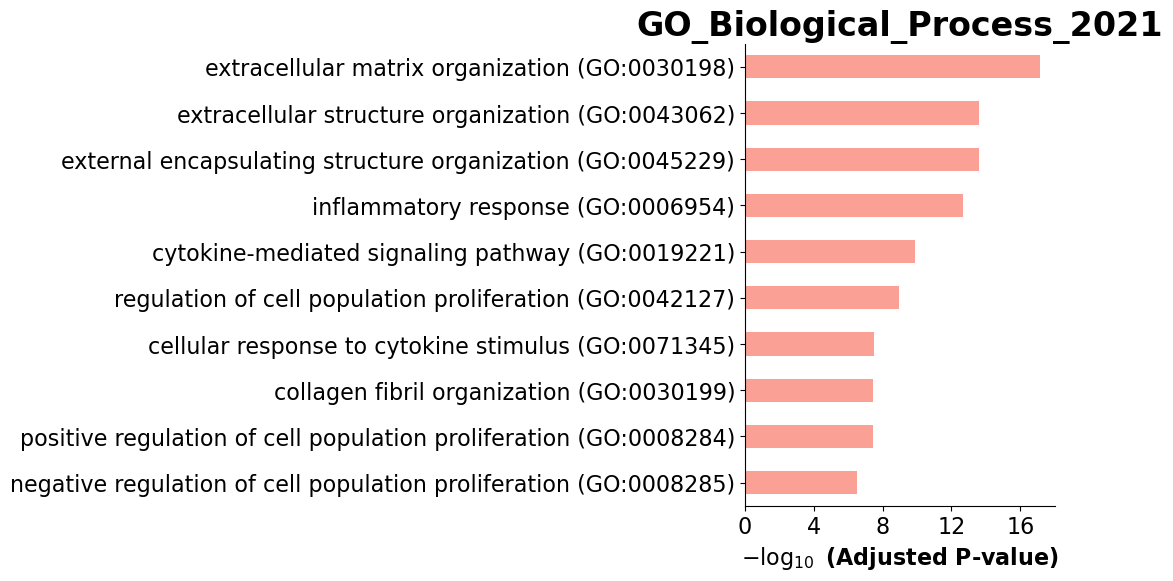

In [402]:
from gseapy.plot import barplot, dotplot

barplot(enr_top.res2d,title=gene_sets[1])#'GO_Biological_Process_2021')

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

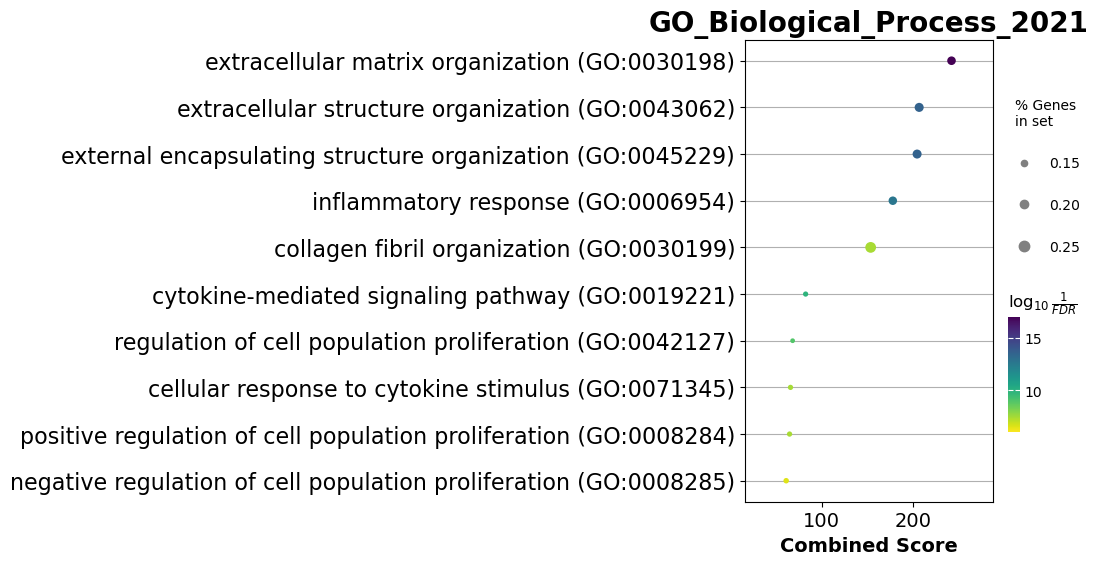

In [403]:
dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

In [271]:
enr_down = gseapy.enrichr(gene_list=list(down_genes),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'g', 'l', 'minus', 'nonmarkingreturn', 'o', 'one', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 74, 79, 82, 3228]
INFO:fontTools.subset:Closed glyph list over 'MATH': 10 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'g', 'l', 'minus', 'nonmarkingreturn', 'o', 'one', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 74, 79, 82, 3228]
INFO:fontTools.subset:Closing glyph list over 'GSUB': 10 glyphs before
INFO:fontTools.subse

In [272]:
enr_down.results.head(5)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0  antigen processing and presentation of lipid a...     5/5  9.378258e-08   
1  antigen processing and presentation, endogenou...     5/5  9.378258e-08   
2  antigen processing and presentation, exogenous...     5/5  9.378258e-08   
3      aerobic electron transport chain (GO:0019646)   12/70  1.673676e-05   
4  mitochondrial ATP synthesis coupled electron t...   12/71  1.942782e-05   

   Adjusted P-value  Old P-value  Old Adjusted P-value    Odds Ratio  \
0          0.000094            0                     0  96060.000000   
1          0.000094            0                     0  96060.000000   
2          0.000094            0                     0  96060.000000   
3          0.011645            0                     0      5.106825   
4          0.011645            0                     0      5.020007   

   Combined Score                                              Genes  
0    1.554470e+06                           CD1E;CD1D;CD1C;CD1B;CD1A  
1    1.554470e+06                           CD1E;CD1D;CD1C;CD1B;CD1A  
2    1.554470e+06                           CD1E;CD1D;CD1C;CD1B;CD1A  
3    5.616437e+01  NDUFA8;NDUFA6;NDUFS7;NDUFB6;NDUFA4;UQCRQ;COX4I...  
4    5.446107e+01  NDUFA8;NDUFA6;NDUFS7;NDUFB6;NDUFA4;UQCRQ;COX4I...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

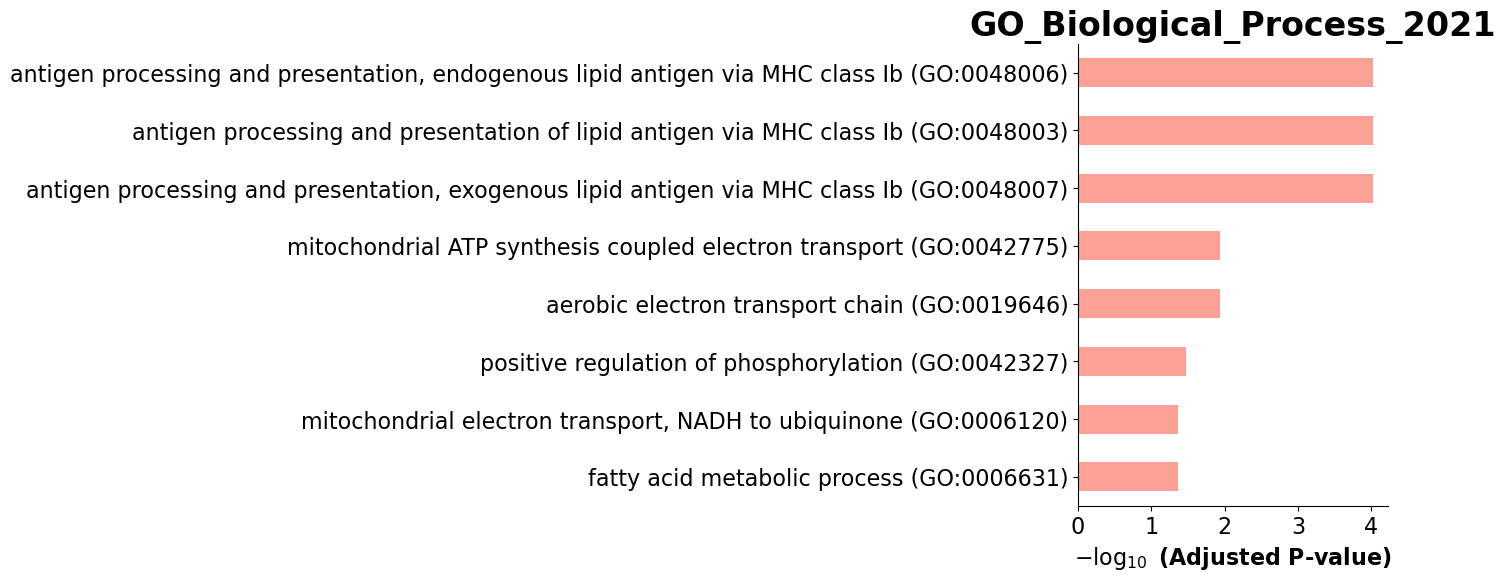

In [404]:
from gseapy.plot import barplot, dotplot

barplot(enr_down.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

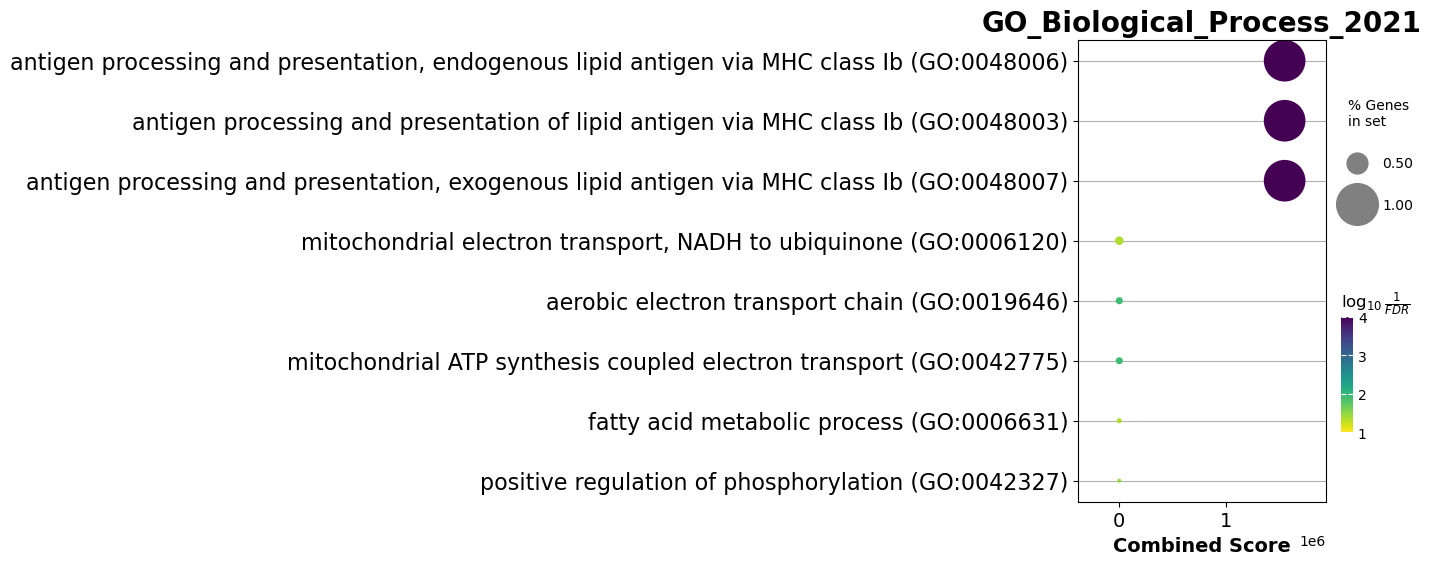

In [405]:
dotplot(enr_down.res2d, title=gene_sets[1],cmap='viridis_r')

## **Задача**: изучите гены, которые являются дифференциально экспрессированными в каждом из гистологических типов. 
## Какие процессы в них различаются? Есть ли этому какое-то объяснение в статьях?

### Histology Ab

In [765]:
deseq_top_ab_b3 = deseq_res_ab_b3[deseq_res_ab_b3['log2FoldChange'] > 0].index
deseq_down_ab_b3 = deseq_res_ab_b3[deseq_res_ab_b3['log2FoldChange'] < 0].index

In [728]:
enr_top_ab_b3 = gseapy.enrichr(gene_list=list(deseq_top_ab_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [736]:
enr_top_ab_b3.results.head(2)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   

                                                Term   Overlap       P-value  \
0  regulation of transcription, DNA-templated (GO...  218/2244  4.145514e-10   
1  negative regulation of transcription, DNA-temp...   105/948  5.023603e-08   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000002            0                     0    1.654914   
1          0.000096            0                     0    1.857922   

   Combined Score                                              Genes  
0       35.752475  GFI1;FOXI2;FOXI1;IKZF1;IKZF2;TIAL1;SOX1;CREB3L...  
1       31.225225  NAB1;GFI1;RORC;IKZF1;ETS2;SOX1;CREB3L1;MYB;DPF...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

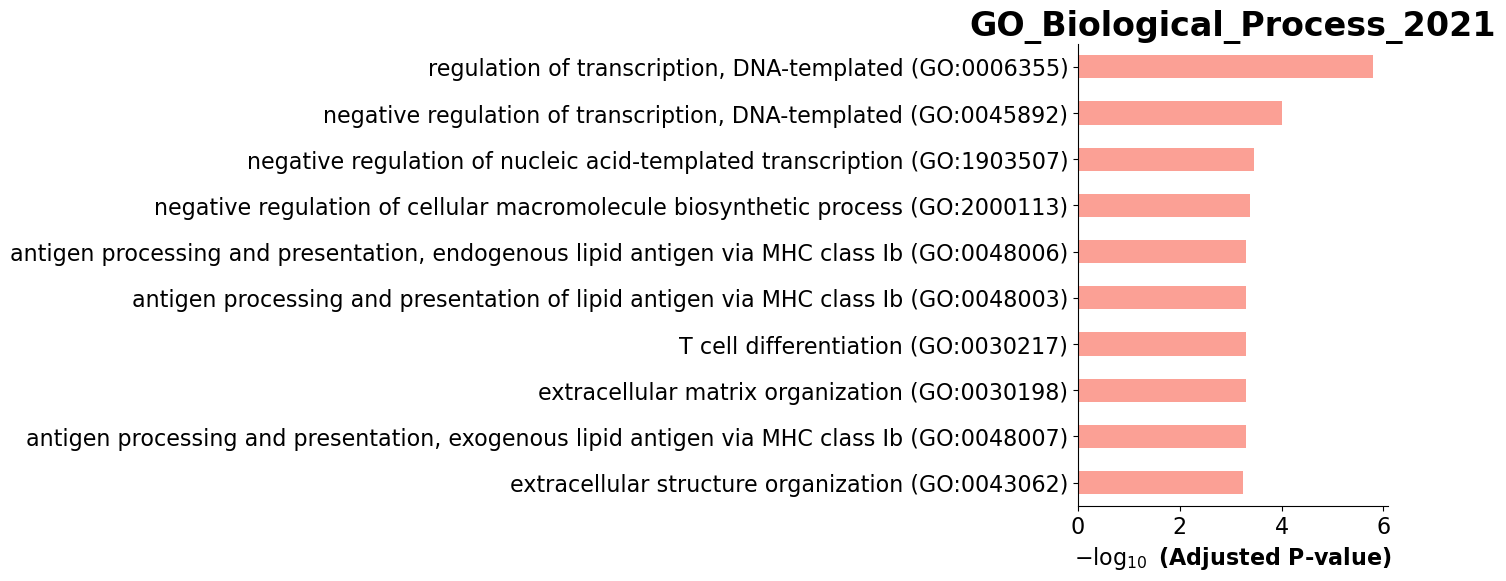

In [737]:
barplot(enr_top_ab_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

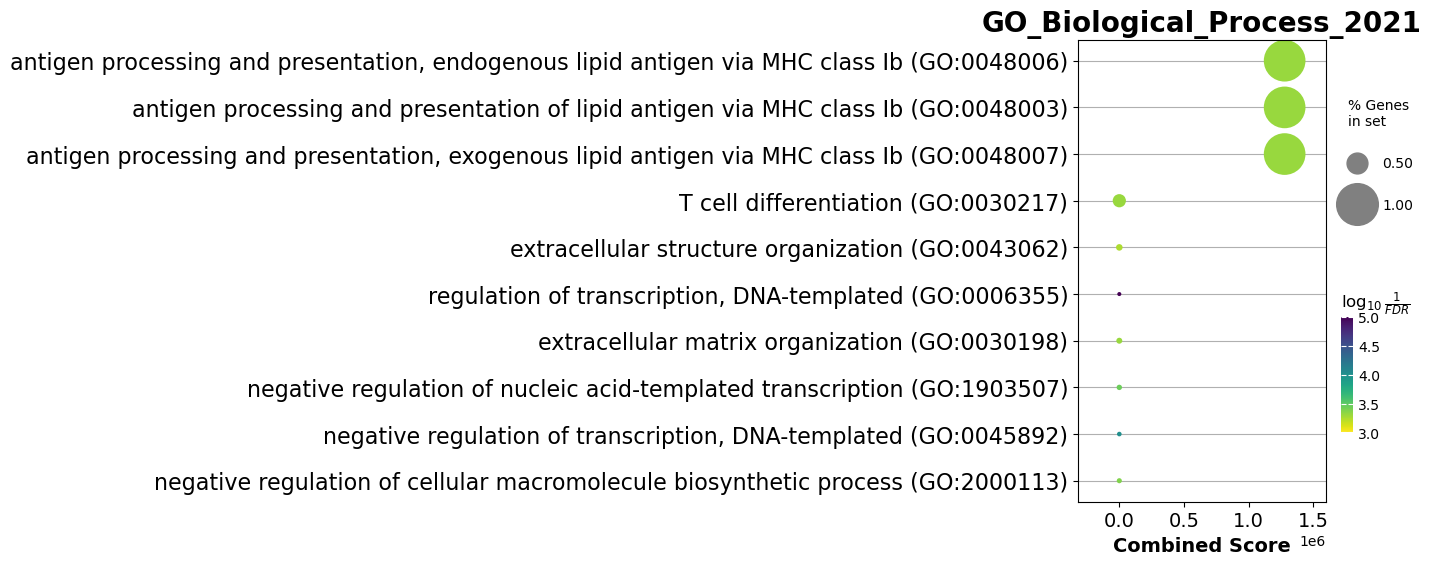

In [738]:
dotplot(enr_top_ab_b3.res2d, title = gene_sets[1],cmap='viridis_r')

In [739]:
enr_down_ab_b3 = gseapy.enrichr(gene_list=list(deseq_down_ab_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [740]:
enr_down_ab_b3.results.head(2)

Gene_set                                     Term  \
0  GO_Biological_Process_2021  acyl-CoA metabolic process (GO:0006637)   
1  GO_Biological_Process_2021       epidermis development (GO:0008544)   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   17/37  3.257755e-07          0.001557            0                     0   
1   27/83  7.433003e-07          0.001776            0                     0   

   Odds Ratio  Combined Score  \
0    6.246842       93.309441   
1    3.550969       50.111863   

                                               Genes  
0  ACOT7;ACSM3;ACSM1;OXSM;ACOT11;DLST;BAAT;ACACA;...  
1  CALML5;BNC1;LAMC2;ATP2C1;HOXB13;EVPL;KRT85;KRT...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

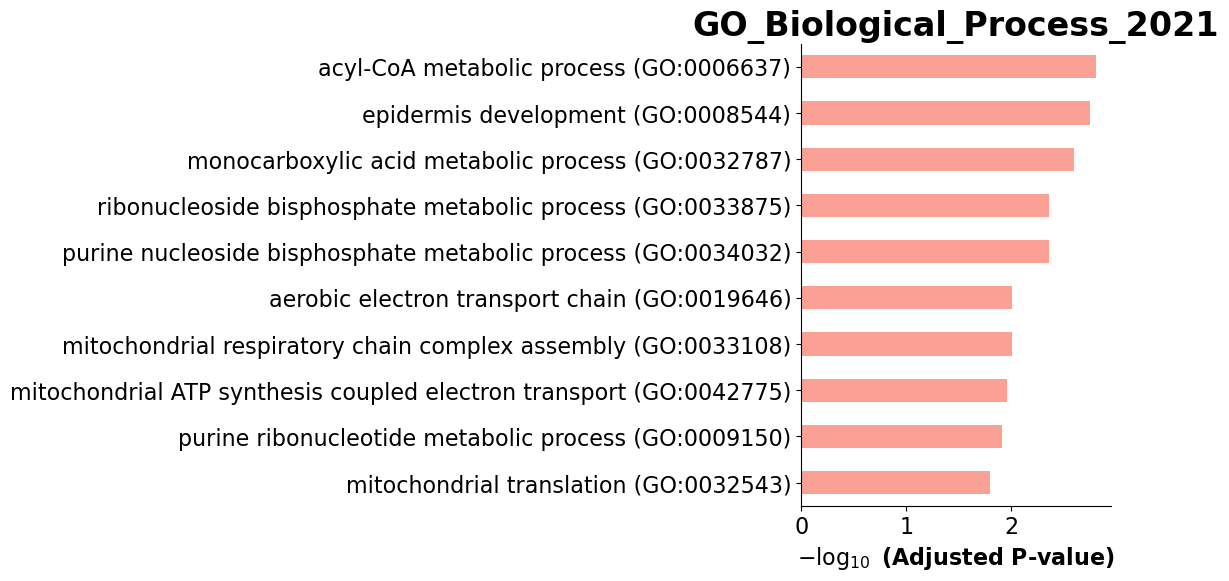

In [741]:
barplot(enr_down_ab_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

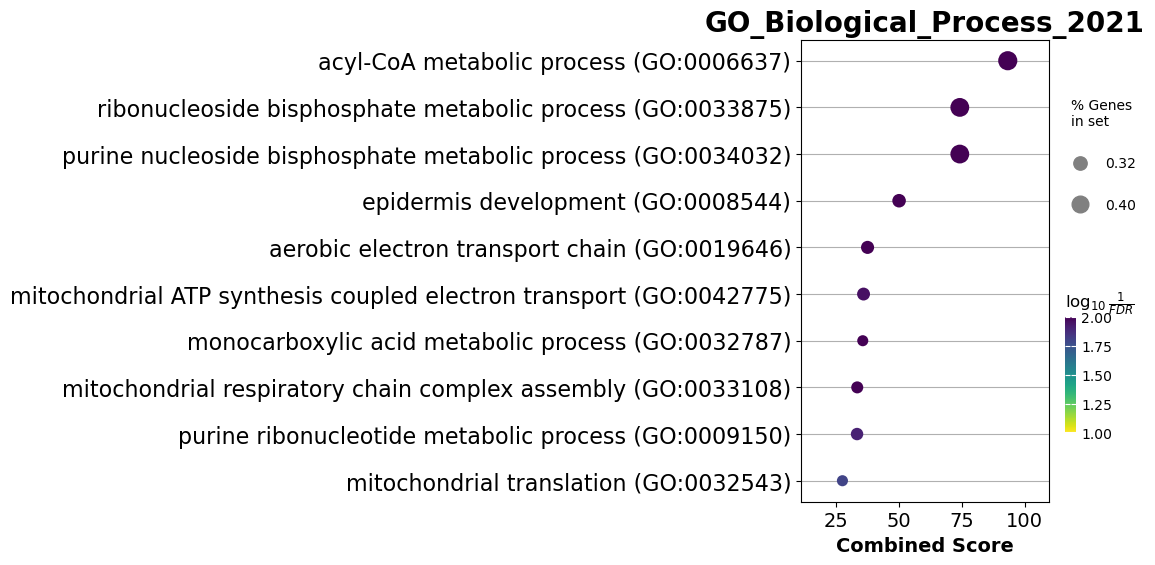

In [742]:
dotplot(enr_down_ab_b3.res2d, title=gene_sets[1],cmap='viridis_r')

### Histology A

In [749]:
deseq_top_a_b3 = deseq_res_a_b3[deseq_res_a_b3['log2FoldChange'] > 0].index
deseq_down_a_b3 = deseq_res_a_b3[deseq_res_a_b3['log2FoldChange'] < 0].index

enr_top_a_b3 = gseapy.enrichr(gene_list=list(deseq_top_a_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [750]:
enr_top_a_b3.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0           skeletal system development (GO:0001501)  19/158  0.000002   
1  branching involved in blood vessel morphogenes...    5/14  0.000066   
2  regulation of protein kinase C signaling (GO:0...    5/14  0.000066   
3                           hemopoiesis (GO:0030097)   12/94  0.000072   
4  positive regulation of cell differentiation (G...  21/258  0.000180   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.004370            0                     0    4.016779   
1          0.050410            0                     0   16.091121   
2          0.050410            0                     0   16.091121   
3          0.050410            0                     0    4.267406   
4          0.077099            0                     0    2.598476   

   Combined Score                                              Genes  
0       53.694340  WNT5A;BMP8B;PTH1R;ETS2;RAB33B;PAPSS1;VCAN;COL2...  
1      154.983675                        SFRP2;KDR;CTNNB1;TGFBR2;ENG  
2      154.983675                        DGKD;WNT11;FLT4;WNT5A;MYADM  
3       40.693067  CD164;KITLG;SNRK;WNT2B;SFRP2;MECOM;FLT4;RTKN2;...  
4       22.406353  SMAD4;TGFB1I1;LRP5;TWIST1;ADRA2C;GDF5;ACVR2B;T...

### Histology B2

In [766]:
deseq_top_b2_b3 = deseq_res_b2_b3[deseq_res_b2_b3['log2FoldChange'] > 0].index
deseq_down_b2_b3 = deseq_res_b2_b3[deseq_res_b2_b3['log2FoldChange'] < 0].index

enr_top_b2_b3 = gseapy.enrichr(gene_list=list(deseq_top_b2_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [767]:
enr_top_b2_b3.results.head(2)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0  mitotic sister chromatid segregation (GO:0000070)  30/102  6.546961e-15   
1                     T cell activation (GO:0042110)   27/92  1.563535e-13   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.246917e-11            0                     0    7.570649   
1      2.683027e-10            0                     0    7.528397   

   Combined Score                                              Genes  
0      247.255686  SEH1L;SET;NCAPG2;MIS12;KIF14;CDCA8;NCAPG;PDS5B...  
1      221.987265  LMBR1L;ITK;CD3G;PTPN22;NLRC3;GATA3;CD3E;CD1C;R...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

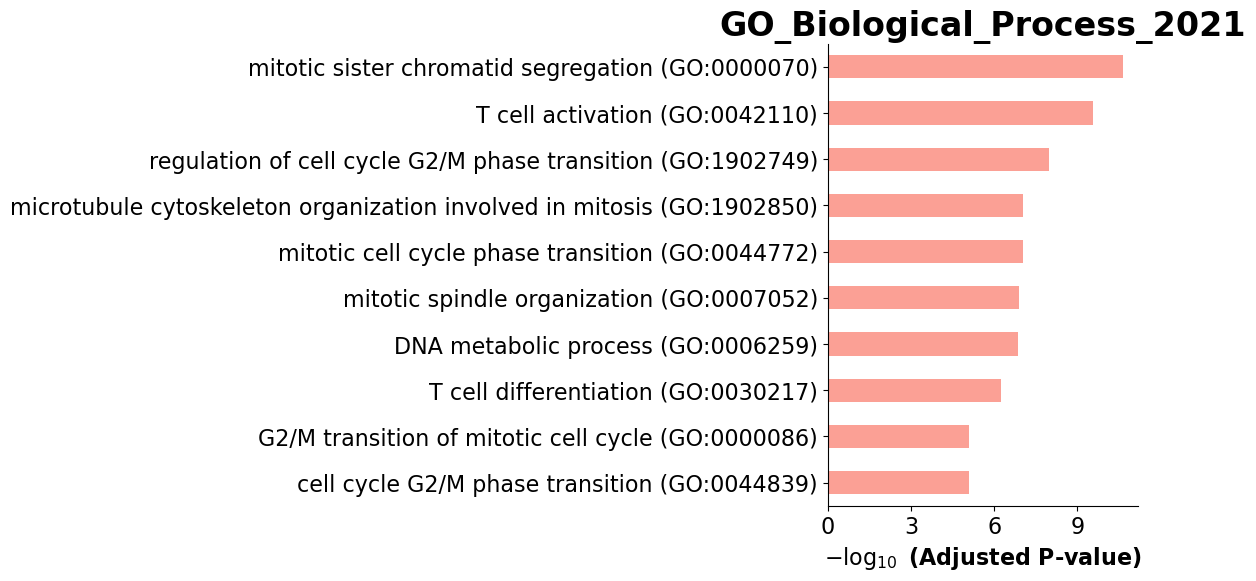

In [768]:
barplot(enr_top_b2_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

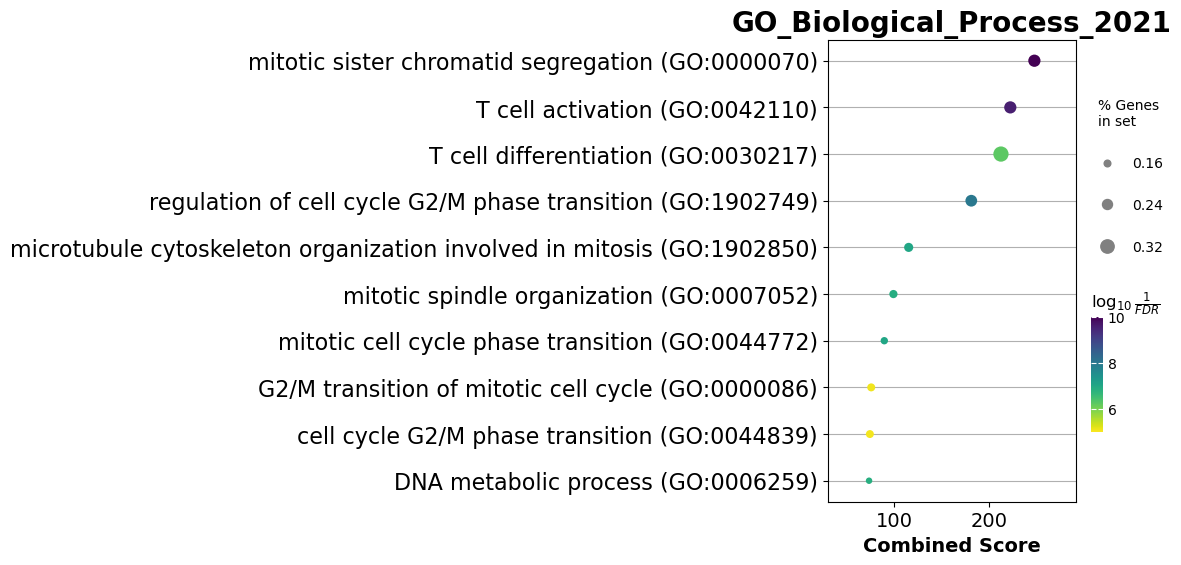

In [769]:
dotplot(enr_top_b2_b3.res2d, title = gene_sets[1],cmap='viridis_r')

In [759]:
enr_down_b2_b3 = gseapy.enrichr(gene_list=list(deseq_down_b2_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [770]:
enr_down_b2_b3.results.head(2)

Gene_set                                    Term Overlap  \
0  GO_Biological_Process_2021           skin development (GO:0043588)   21/80   
1  GO_Biological_Process_2021  defense response to virus (GO:0051607)  28/133   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  3.990866e-07          0.001585            0                     0   
1  7.536135e-07          0.001585            0                     0   

   Odds Ratio  Combined Score  \
0    4.339544       63.939225   
1    3.258195       45.935287   

                                               Genes  
0  RYR1;CERS3;DSP;CSTA;ST14;WNT10A;JAG1;ABCB6;ITG...  
1  IFITM3;CD40;IFIT5;IFI6;IFIT1;ZDHHC1;IFI44L;IFI...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

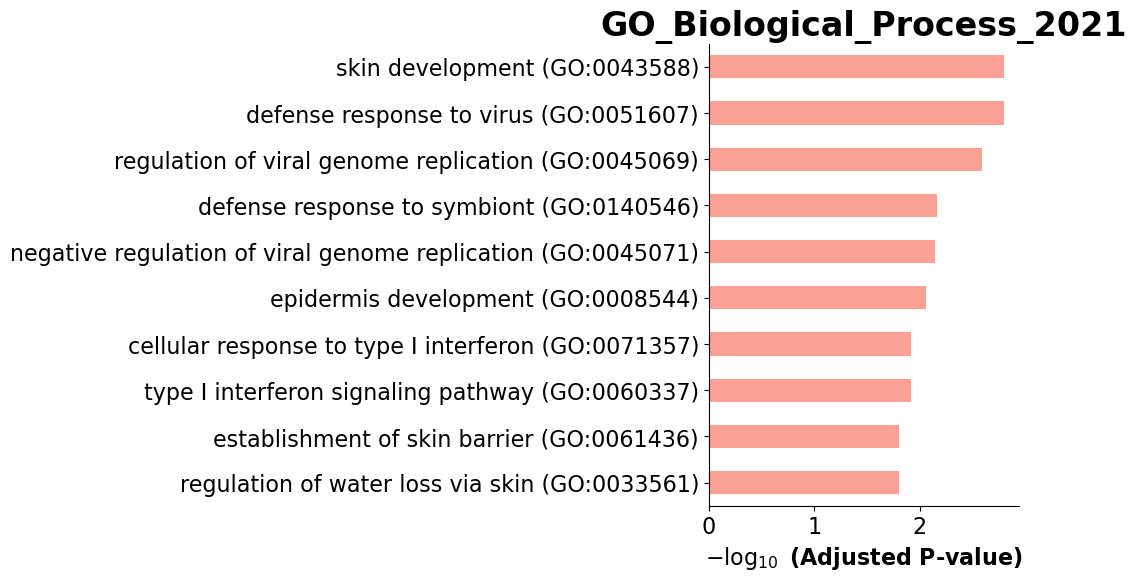

In [764]:
barplot(enr_down_b2_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

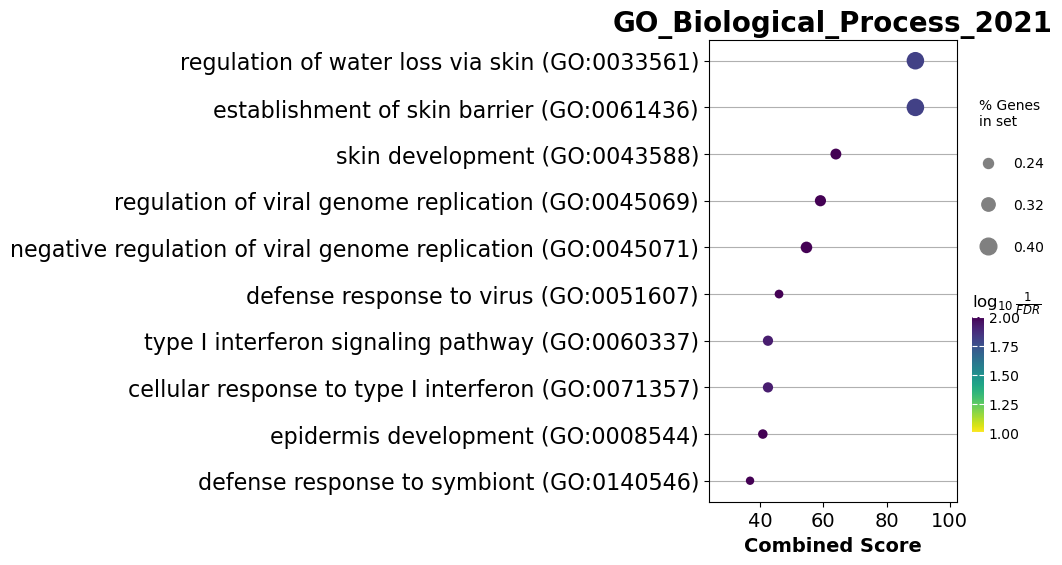

In [763]:
dotplot(enr_down_b2_b3.res2d, title = gene_sets[1],cmap='viridis_r')

### Histology B1

In [771]:
deseq_top_b1_b3 = deseq_res_b1_b3[deseq_res_b1_b3['log2FoldChange'] > 0].index
deseq_down_b1_b3 = deseq_res_b1_b3[deseq_res_b1_b3['log2FoldChange'] < 0].index

enr_top_b1_b3 = gseapy.enrichr(gene_list=list(deseq_top_b1_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [773]:
enr_top_b1_b3.results.head(2)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0                 DNA metabolic process (GO:0006259)  98/277  4.680944e-31   
1  microtubule cytoskeleton organization involved...  58/128  2.719068e-25   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.016082e-27            0                     0    5.214556   
1      5.855512e-22            0                     0    7.774026   

   Combined Score                                              Genes  
0      364.167070  DCLRE1B;SMARCB1;GMNN;TRIM28;CHEK1;KPNA2;ZNF445...  
1      439.732635  GPSM2;NUP107;ZWILCH;BUB1B;KIF11;CDC20;STMN1;NU...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

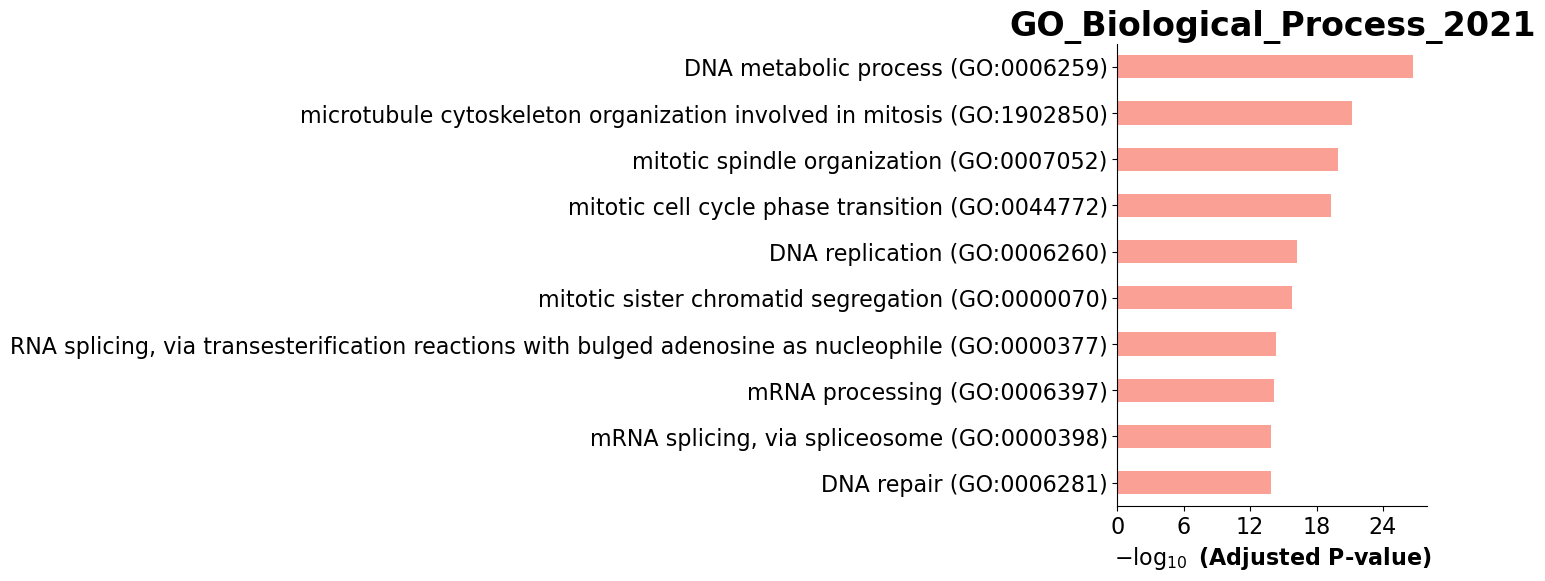

In [774]:
barplot(enr_top_b1_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

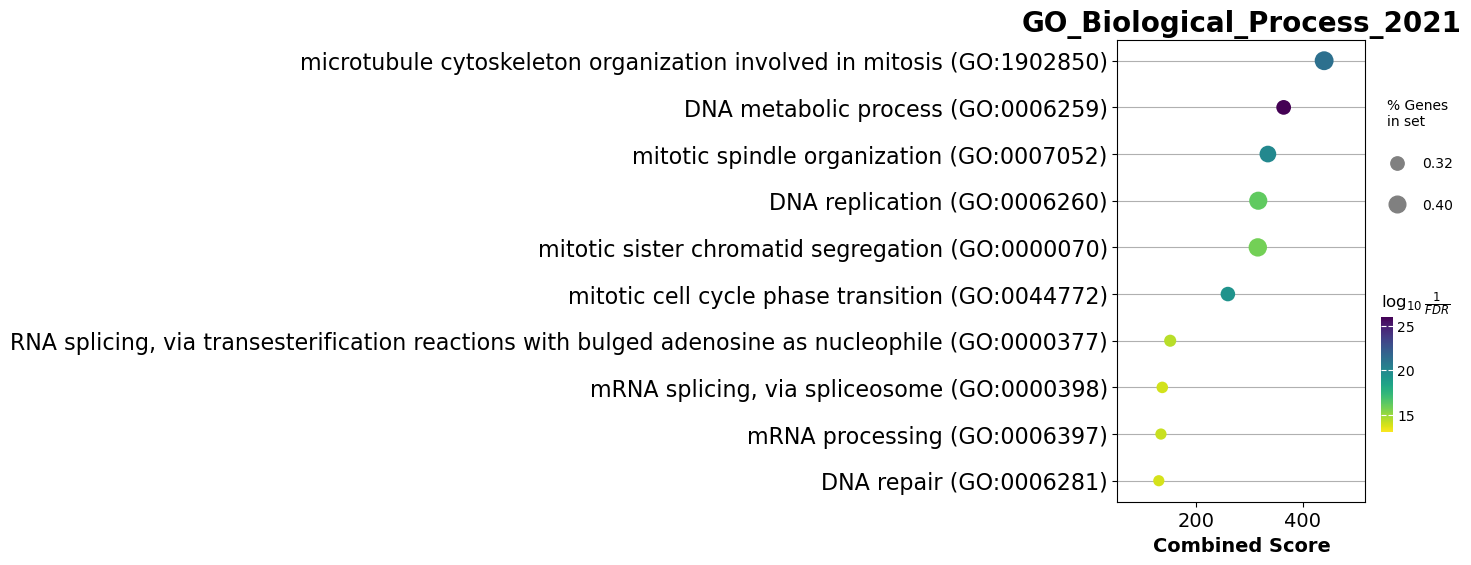

In [778]:
dotplot(enr_top_b1_b3.res2d, title = gene_sets[1],cmap='viridis_r')

In [779]:
enr_down_b1_b3 = gseapy.enrichr(gene_list=list(deseq_down_b1_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [780]:
enr_down_b1_b3.results.head(2)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   

                                                Term  Overlap       P-value  \
0  transmembrane receptor protein tyrosine kinase...  137/404  1.513777e-14   
1          regulation of cell migration (GO:0030334)  138/408  1.526563e-14   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      4.091189e-11            0                     0    2.364647   
1      4.091189e-11            0                     0    2.355676   

   Combined Score                                              Genes  
0       75.246797  CYFIP1;NCKAP1;CSF1;IRS2;PLAT;FGF1;SOGA1;FGFRL1...  
1       74.941541  SEMA5A;IFITM1;CSF1;FGF1;CLDN1;CXCL16;IGF1R;FGF...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

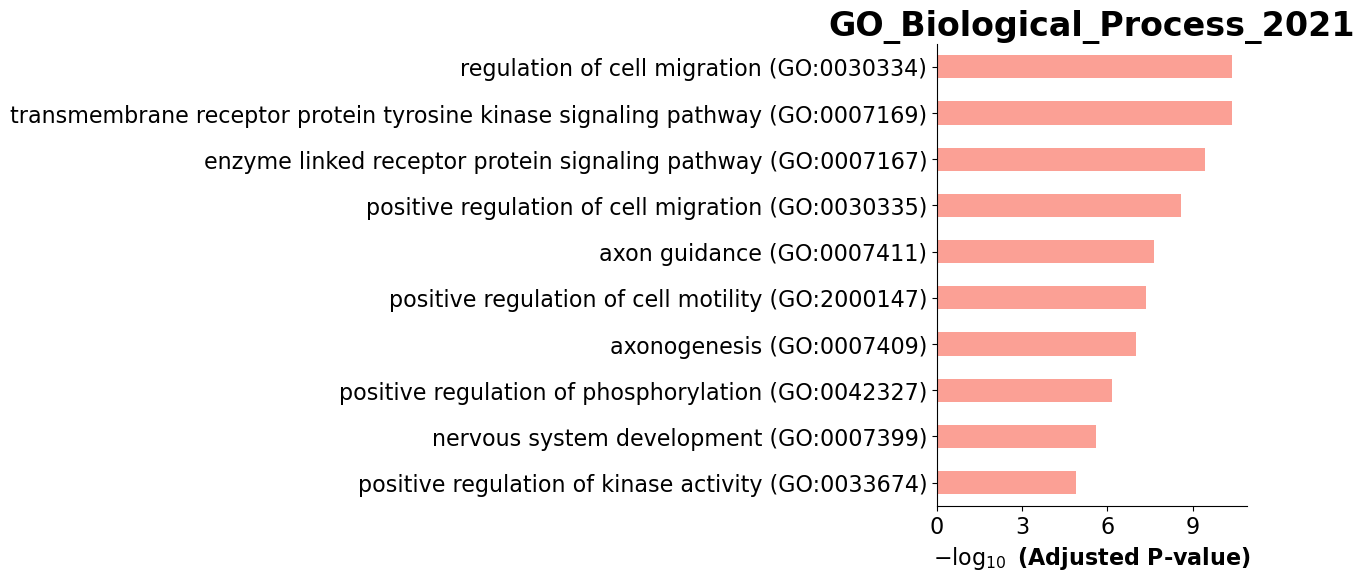

In [781]:
barplot(enr_down_b1_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

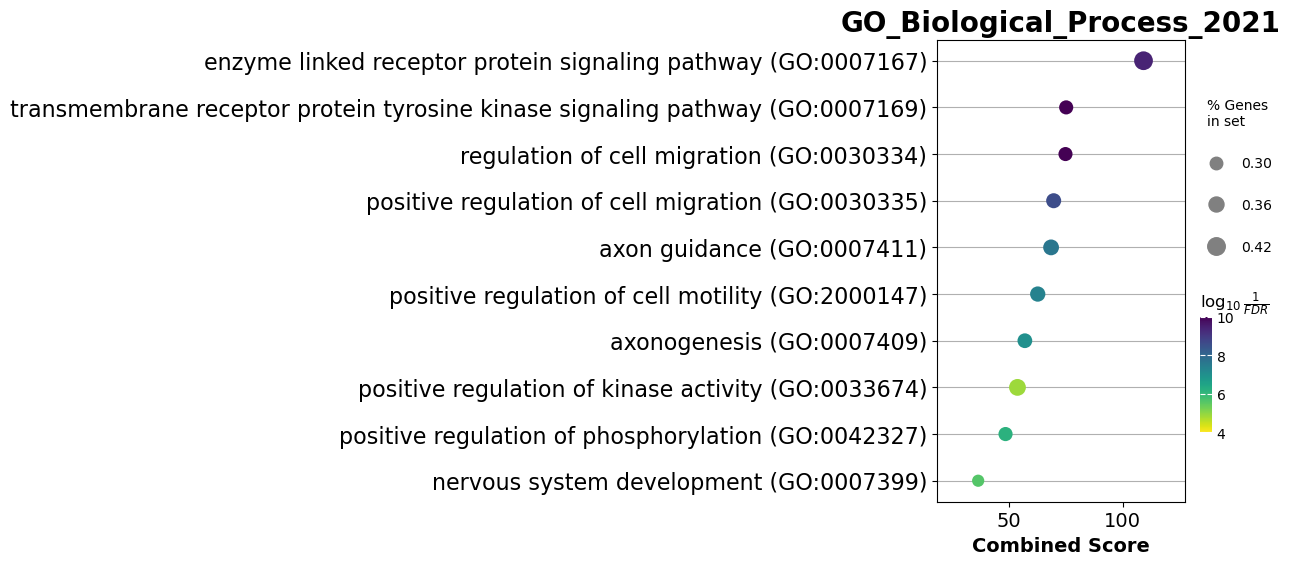

In [782]:
dotplot(enr_down_b1_b3.res2d, title = gene_sets[1],cmap='viridis_r')

### Histology C

In [793]:
deseq_top_c_b3 = deseq_res_c_b3[deseq_res_c_b3['log2FoldChange'] > 0].index
deseq_down_c_b3 = deseq_res_c_b3[deseq_res_c_b3['log2FoldChange'] < 0].index

enr_top_c_b3 = gseapy.enrichr(gene_list=list(deseq_top_c_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

In [794]:
enr_top_c_b3.results.head(5)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term  Overlap       P-value  \
0   cytokine-mediated signaling pathway (GO:0019221)  123/621  3.201709e-16   
1                 inflammatory response (GO:0006954)   62/230  6.876971e-15   
2     extracellular matrix organization (GO:0030198)   71/300  1.023326e-13   
3  cellular response to cytokine stimulus (GO:007...   96/482  4.516273e-13   
4  extracellular structure organization (GO:0043062)   54/216  9.641583e-12   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.524334e-12            0                     0    2.508556   
1      1.637063e-11            0                     0    3.688834   
2      1.624019e-10            0                     0    3.104076   
3      5.375494e-10            0                     0    2.503119   
4      9.180715e-09            0                     0    3.318199   

   Combined Score                                              Genes  
0       89.499443  CD86;CSF3;CD80;IL5RA;CXCL13;FGF2;ICAM1;IL27RA;...  
1      120.295088  CIITA;CXCL9;CXCL8;TNFAIP6;CXCL1;CXCL13;CXCL3;C...  
2       92.844616  VIT;COLGALT2;SPARC;ECM2;ITGAM;COL14A1;ITGB4;IT...  
3       71.153469  CD86;CSF3;ITGAM;CXCL8;CD80;IL5RA;CXCL1;FGF2;CX...  
4       84.165895  VIT;SPARC;ECM2;ITGAM;COL14A1;ITGB4;ITGB3;SERPI...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

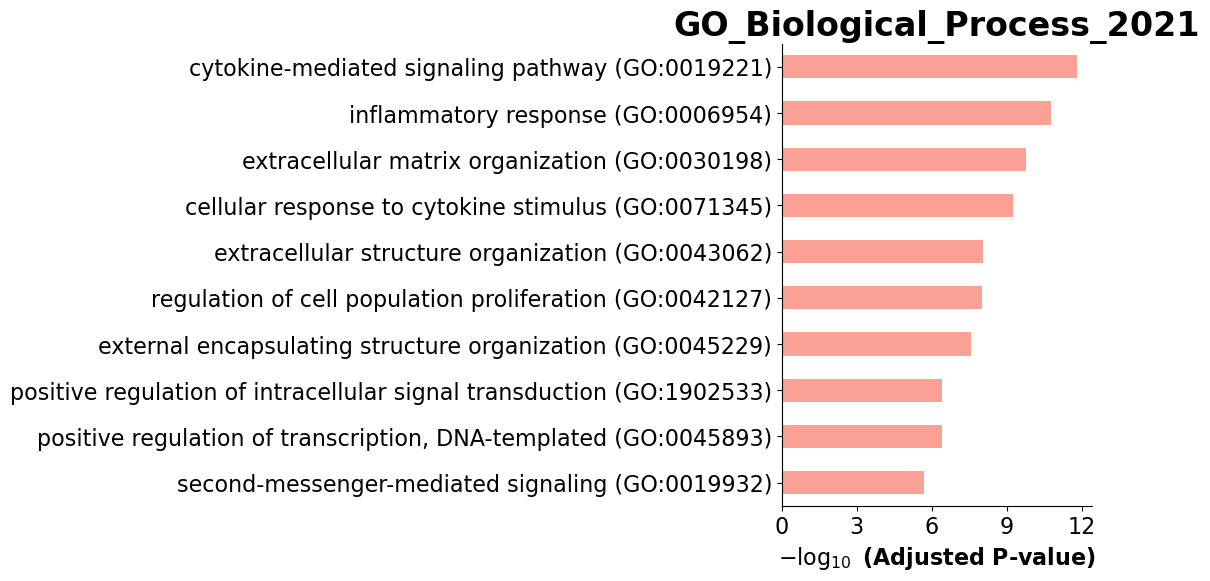

In [795]:
barplot(enr_top_c_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

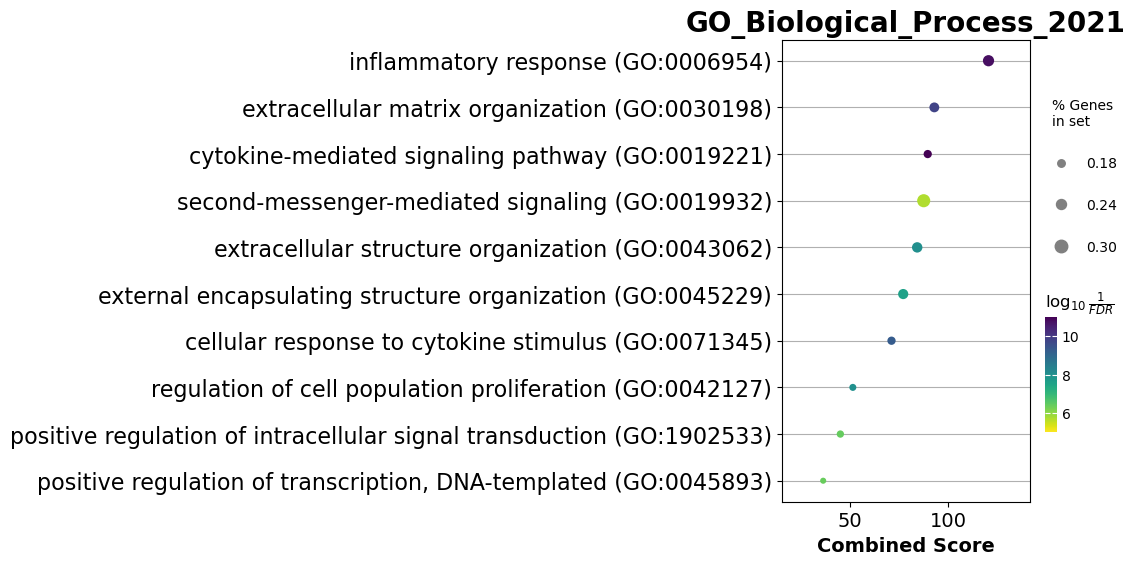

In [799]:
dotplot(enr_top_c_b3.res2d, title=gene_sets[1],cmap='viridis_r')

In [796]:
enr_down_c_b3 = gseapy.enrichr(gene_list=list(deseq_down_c_b3),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', 'a', 'c', 'd', 'e', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 37, 42, 50, 51, 66, 68, 70, 71, 72, 74, 76, 77, 79, 82, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'O', 'P', '

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

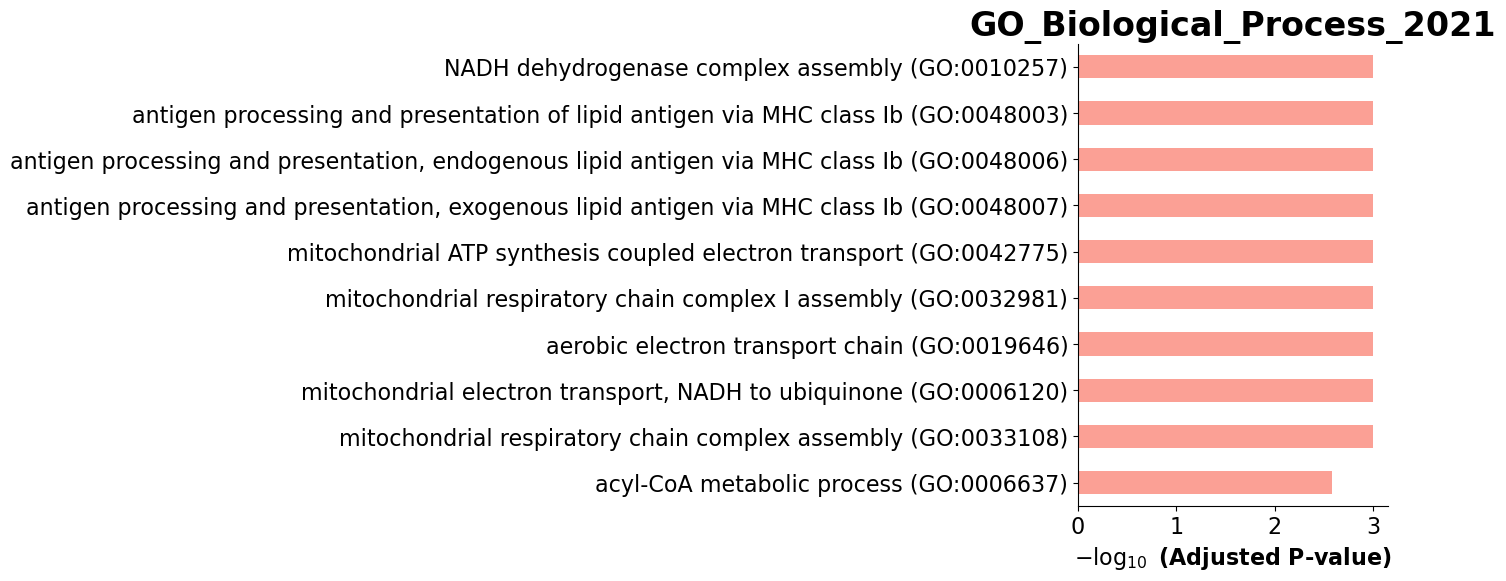

In [797]:
barplot(enr_down_c_b3.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

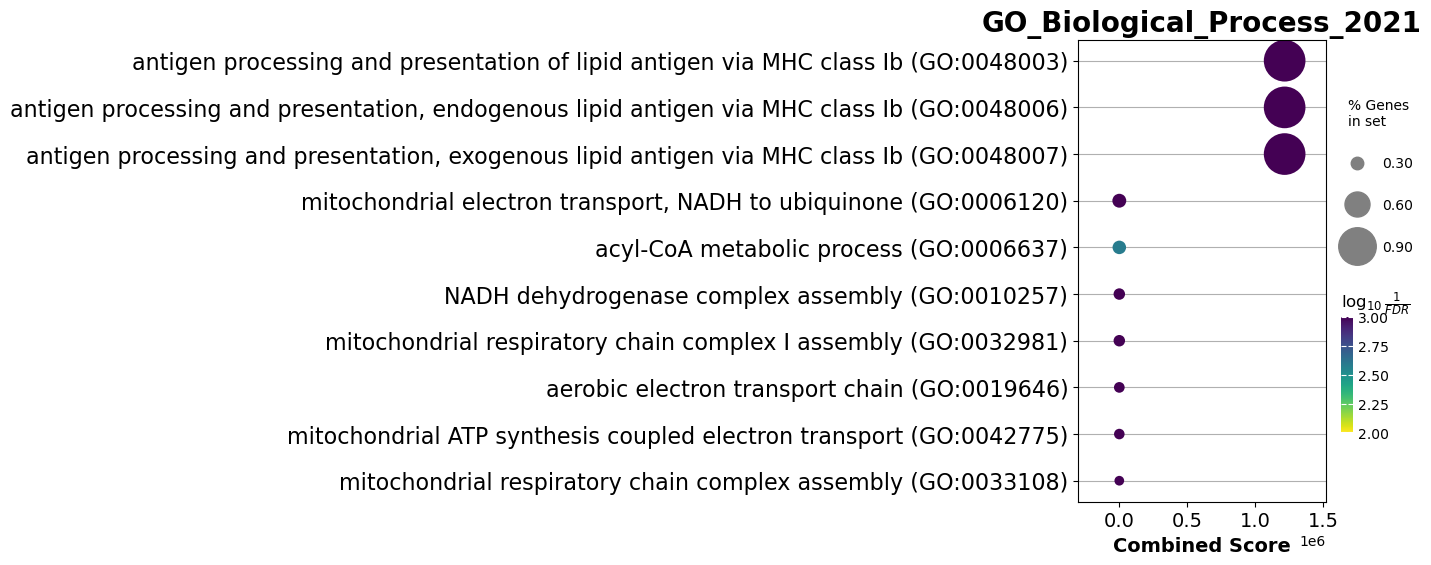

In [798]:
dotplot(enr_down_c_b3.res2d, title=gene_sets[1],cmap='viridis_r')

## Объяснение из статей

1. **Тимома типа A**
- Регуляция сигнального пути протеинкиназы C, гемопоэз, положительная регуляция клеточной дифференциации
- Сниженная регуляция - метаболический процесс монокарбоксильной кислоты, сборка пререпликативного комплекса, регуляция метаболического процесса клеточных аминов, регуляция транскрипции от РНК-полимеразы, регуляция клеточного метаболизма аминокислот
- Показанные маркеры: *FOXN1*, *CDH1* (связаны с клеточной адгезией и эпителиальной функцией)
  
2. **Тимома типа AB:**
- Показана повышенная регуляция транскрипции
- Сниженная регуляция: снижение активности процессов метаболизма ацил-КоА и монокарбоновых кислот
- Показанные маркеры: *CTLA4*, *PD-1* (участвуют в эпителиальных и иммунных функциях)
  
3. **Тимома типа B1:**
- Гены: *MUC1*, *ERBB2* (вовлечены в клеточный рост и пролиферацию)
- Пониженная: трансмембранная рецепторная белковая тирозинкиназа, регуляция клеточной миграции, сигнальные пути рецепторных белков с привязанной ферментной активностью, позитивная регуляция клеточной миграции, руководство осевыми процессами. Повышенная активность генов, вовлеченных в метаболизм ДНК, может указывать на усиленную клеточную пролиферацию и необходимость восстановления ДНК. 

4. **Тимома типа B2:**
- По сравнению с типом B1, этот тип более злокачественный и имеет больше признаков клеточной атипии
- Разделение сестринских хроматид во время митоза, активация Т-клеток, контроль перехода клеточного цикла из фазы G2 в фазу M, участие в формировании микротрубочек цитоскелета, организация митотического веретена
- Гены: *PIK3CA*, *AKT* (активация путей роста и выживания клеток)

5. **Тимома типа C:**
- Гены: *EGFR*, *MET*, *KRAS* (активация сигнальных путей роста, таких как EGFR)
- Этот тип характеризуется агрессивным ростом, инфильтрацией в окружающие ткани и высокой склонностью к метастазам.
- Увеличение экспрессии генов, связанных с воспалительными процессами и сигнальными путями цитокинов

  
Тимомы типов A и AB в основном доброкачественные, тогда как тимомы типов B1, B2 и B3 более агрессивны, причем тимомы B3 имеют наибольшую тенденцию к первичному интраторакальному распространению.
Показана роль супрессоров опухолей SFRP1, CXCL14 и CAV1 б среди генов с пониженной экспрессией в тимомах. В клетках немелкоклеточного рака легких SFRP1, как полагают, опосредует  пролиферацию, инвазию и миграцию опухоли.
### Источники

**Thymoma Subtypes and Gene Expression Profiles:**
1. Wang Y, et al. *Transcriptomic Analysis Reveals Distinct Molecular Subtypes of Thymic Carcinoma*. Cancer Research, 2020. [https://doi.org/10.1158/0008-5472.CAN-19-3032](https://doi.org/10.1158/0008-5472.CAN-19-3032)
2. Meng FJ, Wang S, Zhang J, Yan YJ, Wang CY, Yang CR, Guan ZY, Wang CL. Alteration in gene expression profiles of thymoma: Genetic differences and potential novel targets. Thorac Cancer. 2019 May;10(5):1129-1135. doi: 10.1111/1759-7714.13053. Epub 2019 Apr 1. PMID: 30932350; PMCID: PMC6500959.
3.  Petrini I, et al. *Thymic epithelial tumors: molecular pathology and therapeutic targets*. Annals of Oncology, 2014. [https://doi.org/10.1093/annonc/mdt576](https://doi.org/10.1093/annonc/mdt576)

# ssGSEA

In [275]:
%%R
ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
    row_names = rownames(X)
    num_genes = nrow(X)
    gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})

    # Ranks for genes
    R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')

    # Calculate enrichment score (es) for each sample (column)
    es = apply(R, 2, function(R_col) {
        gene_ranks = order(R_col, decreasing = TRUE)

        # Calc es for each gene set
        es_sample = sapply(gene_sets, function(gene_set_idx) {
            # pos: match (within the gene set)
            # neg: non-match (outside the gene set)
            indicator_pos = gene_ranks %in% gene_set_idx
            indicator_neg = !indicator_pos

            rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha

            step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
            step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)

            step_cdf_diff = step_cdf_pos - step_cdf_neg

            # Normalize by gene number
            if (scale) step_cdf_diff = step_cdf_diff / num_genes

            # Use ssGSEA or not
            if (single) {
                sum(step_cdf_diff)
            } else {
                step_cdf_diff[which.max(abs(step_cdf_diff))]
            }
        })
        unlist(es_sample)
    })

    if (length(gene_sets) == 1) es = matrix(es, nrow = 1)

    # Normalize by absolute diff between max and min
    if (norm) es = es / diff(range(es))

    # Prepare output
    rownames(es) = names(gene_sets)
    colnames(es) = colnames(X)
    return(es)
}

In [276]:
log2_expr = np.log2(expr_tpm + 1)

In [277]:
go_bp = gseapy.get_library(name='GO_Biological_Process_2021', organism='Human')
print(go_bp['glycoprotein catabolic process (GO:0006516)'])

INFO:root:Downloading and generating Enrichr library gene sets...
INFO:root:0002 gene_sets have been filtered out when max_size=2000 and min_size=0


['MANBA', 'EDEM1', 'EDEM2', 'FBXO17', 'NGLY1', 'FBXO2', 'FBXO27', 'OGA', 'FBXO44', 'ADAMTS12', 'NCCRP1', 'MMP12', 'NEU4', 'CTSL', 'NEU2', 'STT3B', 'FBXO6', 'ADAMTS9']


In [278]:
gene_set = pd.DataFrame(go_bp['response to type I interferon (GO:0034340)'])
gene_set.columns = ['response to type I interferon (GO:0034340)']

In [279]:
%%R -i gene_set
gene_set

  response to type I interferon (GO:0034340)
0                                        MX1
1                                      SP100
2                                      SHMT2
3                                      SMPD1
4                                      ISG15
5                                       SHFL
6                                      IFIT1
7                                      SETD2
8                                     TRIM56


In [280]:
%%R -i gene_set
gene_sets = as.list(as.data.frame(gene_set))

In [281]:
%%R
gene_sets

$`response to type I interferon (GO:0034340)`
[1] "MX1"    "SP100"  "SHMT2"  "SMPD1"  "ISG15"  "SHFL"   "IFIT1"  "SETD2" 
[9] "TRIM56"



In [282]:
%%R -i log2_expr

res <- ssgsea(as.matrix(log2_expr), gene_sets, scale = TRUE, norm = FALSE)
res1 = t(res)
head(res1)

                 response to type I interferon (GO:0034340)
TCGA-4V-A9QL-01A                                  0.2969542
TCGA-ZB-A96H-01A                                  0.2778414
TCGA-ZB-A964-01A                                  0.2785606
TCGA-XH-A853-01A                                  0.2865567
TCGA-4V-A9QU-01A                                  0.2492132
TCGA-ZB-A96L-01A                                  0.2763906


In [304]:
%%R
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
mat

                                           TCGA-4V-A9QL-01A TCGA-ZB-A96H-01A
response to type I interferon (GO:0034340)        0.0670976       -0.4772006
                                           TCGA-ZB-A964-01A TCGA-XH-A853-01A
response to type I interferon (GO:0034340)       -0.4567195       -0.2290061
                                           TCGA-4V-A9QU-01A TCGA-ZB-A96L-01A
response to type I interferon (GO:0034340)        -1.292481       -0.5185184
                                           TCGA-X7-A8DD-01A TCGA-ZB-A961-01A
response to type I interferon (GO:0034340)       -0.5109264         2.132372
                                           TCGA-4X-A9FC-01A TCGA-4V-A9QS-01A
response to type I interferon (GO:0034340)        -1.190137         -1.07778
                                           TCGA-4V-A9QM-01A TCGA-3G-AB0O-01A
response to type I interferon (GO:0034340)        0.2981269         1.070916
                                           TCGA-4V-A9QI-01A TCGA-5U-AB0F-01A

In [305]:
%%R -i ann
if (!requireNamespace("ComplexHeatmap", quietly = TRUE)) {
    BiocManager::install("ComplexHeatmap")
}
library(ComplexHeatmap)

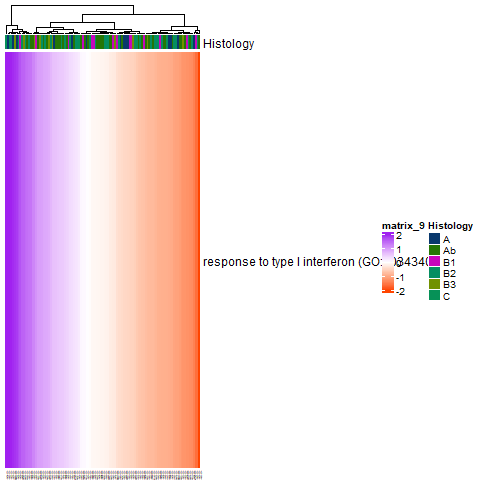

In [309]:
%%R -i ann
library(circlize)
df = as.data.frame(ann$Histology)
colnames(df) = "Histology"
ha = HeatmapAnnotation(df = df)
Heatmap(mat, top_annotation = ha, col = colorRamp2(c(-2,0,2), c("orangered", "white", "purple")),
        column_names_gp = gpar(fontsize = 0))

**Задача:** найти процессы, позволяющие объяснить разделение пациентов на гистологические типы

Если я правильно поняла вопрос, то *процессы в анализе данных* включают в себя:
1. Определение дифференциальную экспрессию генов (DEG) между различными гистологическими типами ткани (edgeR или DESeq2)
2. Анализ обогащения функциональных путей (например, с использованием Gene Ontology, KEGG, Reactome), чтобы определить, какие биологические процессы или сигнальные пути различаются между группами.
3. Интерпретация результатов по типам

Если речь идет о *биологических процессах*, то можно выделить отличия в *гистогенезе, клеточной дифференциацией клеток и реактивности ткани* (способности отвечать на внешние воздействия). Например, как было видно из полученных нами результатов, влияние на экспрессию генов, отвественных за иммунный ответ, способность к делению, взаимодействию с иммунной системой и пролиферативные процессы отличаются в разных типах ткани.